# PreProcessing


**Importing libraries and layers from tensorflow.**

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
import numpy as np
from PIL import Image
from tqdm import tqdm
import os 
import time
import matplotlib.pyplot as plt
from keras.models import load_model

Using TensorFlow backend.


**Mounting google drive**


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


 **DATASET for cropped castor semilooper insect-https://drive.google.com/drive/folders/1-49yefDb8kdqMRUnlVc58l8EElM6fnCp?usp=sharing This dataset has 1,360 cropped images of the castor semilooper insect and is of 69.7 MB(uncompressed).Download the dataset and upload to colab directly or upload zipped version of the file and mount your drive and later unzip them for using.**



**Unzipping dataset to the below mentioned path directory in google drive.**

In [3]:
!unzip "/content/drive/My Drive/cropped castor semilooper.zip" #link of compressed dataset

Archive:  /content/drive/My Drive/cropped castor semilooper.zip
   creating: cropped castor semilooper/
  inflating: cropped castor semilooper/00001IMG_00001_BURST20190913100006.jpg  
  inflating: cropped castor semilooper/00001IMG_00001_BURST20190913100127.jpg  
  inflating: cropped castor semilooper/00001IMG_00001_BURST20190913100240.jpg  
  inflating: cropped castor semilooper/00001IMG_00001_BURST20190913100358.jpg  
  inflating: cropped castor semilooper/00001IMG_00001_BURST20190913100514.jpg  
  inflating: cropped castor semilooper/00001IMG_00001_BURST20190913100639.jpg  
  inflating: cropped castor semilooper/00001IMG_00001_BURST20190913100809.jpg  
  inflating: cropped castor semilooper/00001IMG_00001_BURST20190913100944.jpg  
  inflating: cropped castor semilooper/00001IMG_00001_BURST20190913101150.jpg  
  inflating: cropped castor semilooper/00001IMG_00001_BURST20190913101301.jpg  
  inflating: cropped castor semilooper/00001IMG_00001_BURST20190913101518.jpg  
  inflating: cro

**Setting hyperparameters for computation.Here, we mention parameters for image resolution, preview image size details,seed size,epochs,batch size and buffer size.**


In [4]:
#resolution of images
GENERATE_SQUARE = 96 #96x96
IMAGE_CHANNELS = 3  #RGB

# Preview images for viewing samples during training
PREVIEW_ROWS = 4
PREVIEW_COLS = 7
PREVIEW_MARGIN = 16

# Size vector to generate images from (noise vector)
SEED_SIZE = 100  

# Configuration
DATA_PATH = '/content/cropped aloa lectinea' #copy file location of unzipped data
EPOCHS = 2000
BATCH_SIZE = 32
BUFFER_SIZE = 600

print(f"Will generate {GENERATE_SQUARE}px square images.")

Will generate 96px square images.


**Converting input images from the dataset to arrays. As the colored images have values of varying from (0,255) pixel values, scaling it to (-1, 1) as of generator's last layer's activation Tanh range.**

In [5]:
#loading training data from directory and pre processing
training_data = []
for filename in tqdm(os.listdir('/content/drive/My Drive/minor/cropped castor semilooper')):
    path = os.path.join('/content/drive/My Drive/minor/cropped castor semilooper',filename)
    image = Image.open(path).resize((GENERATE_SQUARE,GENERATE_SQUARE),Image.ANTIALIAS)
    training_data.append(np.asarray(image))
training_data = np.reshape(training_data,(-1,GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS))
training_data = training_data.astype(np.float32)
training_data = training_data / 127.5 - 1.



100%|██████████| 1360/1360 [05:34<00:00,  4.06it/s]


**Making batches of dataset for training the model in batches.**

In [6]:
#making batches of data
train_dataset = tf.data.Dataset.from_tensor_slices(training_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# GAN

**Making a generator network using Sequential model to add the following layers.**

In [7]:
#generator network
generator = keras.models.Sequential([
    keras.layers.Dense(6*6, input_shape=[SEED_SIZE]),
    keras.layers.Dense(6*6*256),
    keras.layers.Reshape([6, 6, 256]),
    keras.layers.Conv2DTranspose(64, (5,5), (2,2), padding="same"),
    keras.layers.LeakyReLU(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(32, (5,5), (2,2), padding="same"),
    keras.layers.LeakyReLU(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(16, (5,5), (2,2), padding="same"),
    keras.layers.LeakyReLU(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(3, (5,5), (2,2), padding="same", activation="tanh"),
])

**Input, output dimensions and parameters of every layer of generator**

In [ ]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 36)                3636      
_________________________________________________________________
dense_1 (Dense)              (None, 9216)              340992    
_________________________________________________________________
reshape (Reshape)            (None, 6, 6, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 12, 12, 64)        409664    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12, 12, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 12, 12, 64)        256       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 24, 24, 32)        5

**Making a discriminator network using Sequential model to add the following layers.**

In [8]:
#discriminator network
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(32, (5,5), (2,2), padding="same", input_shape=[96, 96, 3]),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, (5,5), (2,2), padding="same"),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, (5,5), (2,2), padding="same"),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, (5,5), (2,2), padding="same"),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation='sigmoid')
])

**Input,output dimensions and parameters of every layer of discriminator**

In [ ]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        2432      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 48, 48, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 48, 48, 32)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        51264     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 64)       

# Saving images

**OUT_PATH gives the destination to store the images that our deep-convolutional gan network will generate.**

In [9]:
mkdir '/content/drive/My Drive/minor/cropped castor semilooper_out'

In [10]:
OUT_PATH='/content/drive/My Drive/minor/cropped castor semilooper_out'

**Below cell has a function to save coloured images generated by dcgan in 7x4 grid to preview the images.** 

In [11]:
def save_images(cnt,noise):
  image_array = np.full(( 
      PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 
      PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 3), 
      255, dtype=np.uint8)
  
  generated_images = generator.predict(noise)

  generated_images = 0.5 * generated_images + 0.5

  image_count = 0
  for row in range(PREVIEW_ROWS):
      for col in range(PREVIEW_COLS):
        r = row * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        c = col * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] = generated_images[image_count] * 255
        image_count += 1

          
  output_path = os.path.join(OUT_PATH,f"output-{cnt}")
  if not os.path.exists(output_path):
    os.makedirs(output_path)
  
  filename = os.path.join(output_path,f"train-{cnt}.png")
  im = Image.fromarray(image_array)
  im.save(filename)
  generator.save(os.path.join(output_path,f"face_generator-{cnt}.h5"))

# Testing networks

**Before training the model, generate random sample by adding noise in generator network and specifying training as false.**

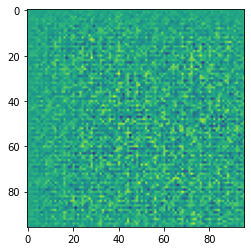

In [14]:
#generating random sample before training
noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

**Checking discriminator's decision on the random sample generated.**

In [15]:
image_shape = (GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS)
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.5002436]], shape=(1, 1), dtype=float32)


# Compiling Gan

**Defining loss for generator and discriminator networks. Binary crossentropy loss has been used. For the generator network the loss is only determined by the fake output that it generates.For discriminator network,total loss is the sum of loss for real and fake outputs.**

In [16]:
#defining losses
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

**In this cell optimizer for the generator and discriminator networks have been defined. Adam optimizer(with a learning rate of 1.5e-4) is used for both the networks.**

In [17]:
#defining otptimizer
generator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)

# Training the Gan


**Defining a fuction for train the dcgan. We train the model by giving randomly generated seed values to the generator. The generator gives an output image, this image along with real image is feeded to the discriminator network. Gradients are calculated for both these network in the basis of generator loss and discriminator loss. Later, optimization is done using these gradients.**

In [18]:
@tf.function
def train_step(images):
  seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(seed, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)#calculating gradients of generator
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)#calculating gradients of discriminator

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))#applying gradients with the optimizer
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))#applying gradients with the optimizer
  return gen_loss,disc_loss

In [19]:
def train(dataset, epochs):
  fixed_seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS, SEED_SIZE))

  for epoch in tqdm(range(epochs)):


    gen_loss_list = []
    disc_loss_list = []

    for image_batch in dataset:
      t = train_step(image_batch)
      gen_loss_list.append(t[0])
      disc_loss_list.append(t[1])

    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)


    print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss}')
    if epoch%100==0:
      save_images(epoch,fixed_seed)


  print (f'Training time: {hms_string(epoch_elapsed)}')

**Calling the train fuction to start train the gan model for desired number of epochs.**

In [20]:
train(train_dataset, EPOCHS)

  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 1, gen loss=0.5745388865470886,disc loss=1.321177363395691


  0%|          | 2/2000 [00:10<3:35:04,  6.46s/it]

Epoch 2, gen loss=0.6474106907844543,disc loss=1.1335221529006958


  0%|          | 3/2000 [00:13<2:56:36,  5.31s/it]

Epoch 3, gen loss=0.672135055065155,disc loss=1.0524239540100098


  0%|          | 4/2000 [00:16<2:29:43,  4.50s/it]

Epoch 4, gen loss=0.6834750771522522,disc loss=1.0259627103805542


  0%|          | 5/2000 [00:18<2:10:47,  3.93s/it]

Epoch 5, gen loss=0.689115583896637,disc loss=1.0149264335632324


  0%|          | 6/2000 [00:21<1:57:40,  3.54s/it]

Epoch 6, gen loss=0.6901693940162659,disc loss=1.0116947889328003


  0%|          | 7/2000 [00:23<1:48:20,  3.26s/it]

Epoch 7, gen loss=0.6909359097480774,disc loss=1.009801983833313


  0%|          | 8/2000 [00:26<1:41:52,  3.07s/it]

Epoch 8, gen loss=0.6911056637763977,disc loss=1.0093235969543457


  0%|          | 9/2000 [00:29<1:37:20,  2.93s/it]

Epoch 9, gen loss=0.6917070746421814,disc loss=1.0087292194366455


  0%|          | 10/2000 [00:31<1:34:15,  2.84s/it]

Epoch 10, gen loss=0.6923194527626038,disc loss=1.0076732635498047


  1%|          | 11/2000 [00:34<1:32:05,  2.78s/it]

Epoch 11, gen loss=0.6922194361686707,disc loss=1.0078152418136597


  1%|          | 12/2000 [00:36<1:30:29,  2.73s/it]

Epoch 12, gen loss=0.6925962567329407,disc loss=1.0073081254959106


  1%|          | 13/2000 [00:39<1:29:27,  2.70s/it]

Epoch 13, gen loss=0.6926449537277222,disc loss=1.007149577140808


  1%|          | 14/2000 [00:42<1:28:53,  2.69s/it]

Epoch 14, gen loss=0.6927396655082703,disc loss=1.0070712566375732


  1%|          | 15/2000 [00:44<1:28:21,  2.67s/it]

Epoch 15, gen loss=0.6926729679107666,disc loss=1.0070396661758423


  1%|          | 16/2000 [00:47<1:27:56,  2.66s/it]

Epoch 16, gen loss=0.6928420662879944,disc loss=1.0068697929382324


  1%|          | 17/2000 [00:50<1:27:47,  2.66s/it]

Epoch 17, gen loss=0.6928825974464417,disc loss=1.0068014860153198


  1%|          | 18/2000 [00:52<1:27:31,  2.65s/it]

Epoch 18, gen loss=0.6929440498352051,disc loss=1.0067142248153687


  1%|          | 19/2000 [00:55<1:27:24,  2.65s/it]

Epoch 19, gen loss=0.6929134726524353,disc loss=1.006731390953064


  1%|          | 20/2000 [00:58<1:27:17,  2.64s/it]

Epoch 20, gen loss=0.6929134726524353,disc loss=1.006738305091858


  1%|          | 21/2000 [01:00<1:27:06,  2.64s/it]

Epoch 21, gen loss=0.6928967237472534,disc loss=1.0067442655563354


  1%|          | 22/2000 [01:03<1:26:57,  2.64s/it]

Epoch 22, gen loss=0.6928904056549072,disc loss=1.006762981414795


  1%|          | 23/2000 [01:05<1:26:52,  2.64s/it]

Epoch 23, gen loss=0.6928932666778564,disc loss=1.0068039894104004


  1%|          | 24/2000 [01:08<1:26:46,  2.64s/it]

Epoch 24, gen loss=0.6927149891853333,disc loss=1.0069388151168823


  1%|▏         | 25/2000 [01:11<1:26:40,  2.63s/it]

Epoch 25, gen loss=0.692672848701477,disc loss=1.007033109664917


  1%|▏         | 26/2000 [01:13<1:26:43,  2.64s/it]

Epoch 26, gen loss=0.6929875612258911,disc loss=1.0066821575164795


  1%|▏         | 27/2000 [01:16<1:26:37,  2.63s/it]

Epoch 27, gen loss=0.6929932832717896,disc loss=1.0066661834716797


  1%|▏         | 28/2000 [01:19<1:26:37,  2.64s/it]

Epoch 28, gen loss=0.6930097341537476,disc loss=1.006664752960205


  1%|▏         | 29/2000 [01:21<1:26:39,  2.64s/it]

Epoch 29, gen loss=0.693035364151001,disc loss=1.006574273109436


  2%|▏         | 30/2000 [01:24<1:26:34,  2.64s/it]

Epoch 30, gen loss=0.6930211782455444,disc loss=1.006600022315979


  2%|▏         | 31/2000 [01:27<1:26:31,  2.64s/it]

Epoch 31, gen loss=0.6930673122406006,disc loss=1.006562352180481


  2%|▏         | 32/2000 [01:29<1:26:25,  2.64s/it]

Epoch 32, gen loss=0.6930398941040039,disc loss=1.0065418481826782


  2%|▏         | 33/2000 [01:32<1:26:20,  2.63s/it]

Epoch 33, gen loss=0.693067729473114,disc loss=1.006543755531311


  2%|▏         | 34/2000 [01:34<1:26:23,  2.64s/it]

Epoch 34, gen loss=0.6930441856384277,disc loss=1.0065455436706543


  2%|▏         | 35/2000 [01:37<1:26:24,  2.64s/it]

Epoch 35, gen loss=0.6930780410766602,disc loss=1.006507396697998


  2%|▏         | 36/2000 [01:40<1:26:28,  2.64s/it]

Epoch 36, gen loss=0.6930757761001587,disc loss=1.006527066230774


  2%|▏         | 37/2000 [01:42<1:26:25,  2.64s/it]

Epoch 37, gen loss=0.6930771470069885,disc loss=1.0065335035324097


  2%|▏         | 38/2000 [01:45<1:26:23,  2.64s/it]

Epoch 38, gen loss=0.6930426955223083,disc loss=1.006542682647705


  2%|▏         | 39/2000 [01:48<1:26:12,  2.64s/it]

Epoch 39, gen loss=0.6930974721908569,disc loss=1.0064847469329834


  2%|▏         | 40/2000 [01:50<1:26:11,  2.64s/it]

Epoch 40, gen loss=0.6930678486824036,disc loss=1.0065191984176636


  2%|▏         | 41/2000 [01:53<1:26:07,  2.64s/it]

Epoch 41, gen loss=0.6930723190307617,disc loss=1.0065264701843262


  2%|▏         | 42/2000 [01:56<1:25:58,  2.63s/it]

Epoch 42, gen loss=0.6930910348892212,disc loss=1.0064982175827026


  2%|▏         | 43/2000 [01:58<1:25:56,  2.63s/it]

Epoch 43, gen loss=0.6930752396583557,disc loss=1.006503939628601


  2%|▏         | 44/2000 [02:01<1:25:45,  2.63s/it]

Epoch 44, gen loss=0.69309401512146,disc loss=1.0064854621887207


  2%|▏         | 45/2000 [02:03<1:25:48,  2.63s/it]

Epoch 45, gen loss=0.6931043863296509,disc loss=1.0064826011657715


  2%|▏         | 46/2000 [02:06<1:25:48,  2.63s/it]

Epoch 46, gen loss=0.6931000351905823,disc loss=1.006487250328064


  2%|▏         | 47/2000 [02:09<1:25:39,  2.63s/it]

Epoch 47, gen loss=0.6931082010269165,disc loss=1.006471872329712


  2%|▏         | 48/2000 [02:11<1:25:31,  2.63s/it]

Epoch 48, gen loss=0.6931085586547852,disc loss=1.006463885307312


  2%|▏         | 49/2000 [02:14<1:25:24,  2.63s/it]

Epoch 49, gen loss=0.6930988430976868,disc loss=1.0064973831176758


  2%|▎         | 50/2000 [02:17<1:25:25,  2.63s/it]

Epoch 50, gen loss=0.6931169033050537,disc loss=1.0064496994018555


  3%|▎         | 51/2000 [02:19<1:25:21,  2.63s/it]

Epoch 51, gen loss=0.6931108832359314,disc loss=1.0064798593521118


  3%|▎         | 52/2000 [02:22<1:25:21,  2.63s/it]

Epoch 52, gen loss=0.6931169033050537,disc loss=1.0064830780029297


  3%|▎         | 53/2000 [02:25<1:25:22,  2.63s/it]

Epoch 53, gen loss=0.6931179165840149,disc loss=1.0064425468444824


  3%|▎         | 54/2000 [02:27<1:25:22,  2.63s/it]

Epoch 54, gen loss=0.6931118369102478,disc loss=1.0064518451690674


  3%|▎         | 55/2000 [02:30<1:25:27,  2.64s/it]

Epoch 55, gen loss=0.6931165456771851,disc loss=1.0064514875411987


  3%|▎         | 56/2000 [02:32<1:25:29,  2.64s/it]

Epoch 56, gen loss=0.6931163668632507,disc loss=1.0064566135406494


  3%|▎         | 57/2000 [02:35<1:25:34,  2.64s/it]

Epoch 57, gen loss=0.6931279897689819,disc loss=1.0064390897750854


  3%|▎         | 58/2000 [02:38<1:25:37,  2.65s/it]

Epoch 58, gen loss=0.693126916885376,disc loss=1.0064425468444824


  3%|▎         | 59/2000 [02:40<1:25:32,  2.64s/it]

Epoch 59, gen loss=0.6931304335594177,disc loss=1.0064401626586914


  3%|▎         | 60/2000 [02:43<1:25:27,  2.64s/it]

Epoch 60, gen loss=0.6931310892105103,disc loss=1.006434679031372


  3%|▎         | 61/2000 [02:46<1:25:25,  2.64s/it]

Epoch 61, gen loss=0.6931316256523132,disc loss=1.0064306259155273


  3%|▎         | 62/2000 [02:48<1:25:24,  2.64s/it]

Epoch 62, gen loss=0.6931313872337341,disc loss=1.0064338445663452


  3%|▎         | 63/2000 [02:51<1:25:27,  2.65s/it]

Epoch 63, gen loss=0.6931248307228088,disc loss=1.0064364671707153


  3%|▎         | 64/2000 [02:54<1:25:27,  2.65s/it]

Epoch 64, gen loss=0.6931253671646118,disc loss=1.006440281867981


  3%|▎         | 65/2000 [02:56<1:25:23,  2.65s/it]

Epoch 65, gen loss=0.6931350827217102,disc loss=1.0064259767532349


  3%|▎         | 66/2000 [02:59<1:25:25,  2.65s/it]

Epoch 66, gen loss=0.6931357383728027,disc loss=1.0064282417297363


  3%|▎         | 67/2000 [03:02<1:25:21,  2.65s/it]

Epoch 67, gen loss=0.69312584400177,disc loss=1.0064539909362793


  3%|▎         | 68/2000 [03:04<1:25:18,  2.65s/it]

Epoch 68, gen loss=0.6930978894233704,disc loss=1.006463885307312


  3%|▎         | 69/2000 [03:07<1:25:21,  2.65s/it]

Epoch 69, gen loss=0.6931389570236206,disc loss=1.0064241886138916


  4%|▎         | 70/2000 [03:10<1:25:14,  2.65s/it]

Epoch 70, gen loss=0.6931377649307251,disc loss=1.0064313411712646


  4%|▎         | 71/2000 [03:12<1:25:13,  2.65s/it]

Epoch 71, gen loss=0.693135142326355,disc loss=1.006425380706787


  4%|▎         | 72/2000 [03:15<1:25:09,  2.65s/it]

Epoch 72, gen loss=0.6931357383728027,disc loss=1.006426453590393


  4%|▎         | 73/2000 [03:17<1:25:09,  2.65s/it]

Epoch 73, gen loss=0.6931307315826416,disc loss=1.0064373016357422


  4%|▎         | 74/2000 [03:20<1:25:09,  2.65s/it]

Epoch 74, gen loss=0.6931381821632385,disc loss=1.0064256191253662


  4%|▍         | 75/2000 [03:23<1:25:05,  2.65s/it]

Epoch 75, gen loss=0.6931368112564087,disc loss=1.0064244270324707


  4%|▍         | 76/2000 [03:25<1:25:09,  2.66s/it]

Epoch 76, gen loss=0.6931360363960266,disc loss=1.0064308643341064


  4%|▍         | 77/2000 [03:28<1:25:01,  2.65s/it]

Epoch 77, gen loss=0.6931374073028564,disc loss=1.0064247846603394


  4%|▍         | 78/2000 [03:31<1:25:00,  2.65s/it]

Epoch 78, gen loss=0.6931381821632385,disc loss=1.006421685218811


  4%|▍         | 79/2000 [03:33<1:24:54,  2.65s/it]

Epoch 79, gen loss=0.6931406259536743,disc loss=1.0064177513122559


  4%|▍         | 80/2000 [03:36<1:24:46,  2.65s/it]

Epoch 80, gen loss=0.693137526512146,disc loss=1.0064231157302856


  4%|▍         | 81/2000 [03:39<1:24:43,  2.65s/it]

Epoch 81, gen loss=0.693136990070343,disc loss=1.0064324140548706


  4%|▍         | 82/2000 [03:41<1:24:40,  2.65s/it]

Epoch 82, gen loss=0.6931350827217102,disc loss=1.0064259767532349


  4%|▍         | 83/2000 [03:44<1:24:36,  2.65s/it]

Epoch 83, gen loss=0.6931384205818176,disc loss=1.006423830986023


  4%|▍         | 84/2000 [03:47<1:24:42,  2.65s/it]

Epoch 84, gen loss=0.6931377053260803,disc loss=1.0064209699630737


  4%|▍         | 85/2000 [03:49<1:24:39,  2.65s/it]

Epoch 85, gen loss=0.6931388974189758,disc loss=1.0064204931259155


  4%|▍         | 86/2000 [03:52<1:24:37,  2.65s/it]

Epoch 86, gen loss=0.6931383013725281,disc loss=1.006421685218811


  4%|▍         | 87/2000 [03:55<1:24:31,  2.65s/it]

Epoch 87, gen loss=0.693138837814331,disc loss=1.0064202547073364


  4%|▍         | 88/2000 [03:57<1:24:26,  2.65s/it]

Epoch 88, gen loss=0.6931416392326355,disc loss=1.0064163208007812


  4%|▍         | 89/2000 [04:00<1:24:30,  2.65s/it]

Epoch 89, gen loss=0.6931411027908325,disc loss=1.0064185857772827


  4%|▍         | 90/2000 [04:03<1:24:23,  2.65s/it]

Epoch 90, gen loss=0.6931427121162415,disc loss=1.006415843963623


  5%|▍         | 91/2000 [04:05<1:24:19,  2.65s/it]

Epoch 91, gen loss=0.6931416988372803,disc loss=1.00641667842865


  5%|▍         | 92/2000 [04:08<1:24:18,  2.65s/it]

Epoch 92, gen loss=0.6931421756744385,disc loss=1.0064152479171753


  5%|▍         | 93/2000 [04:11<1:24:16,  2.65s/it]

Epoch 93, gen loss=0.6931403875350952,disc loss=1.006418228149414


  5%|▍         | 94/2000 [04:13<1:24:17,  2.65s/it]

Epoch 94, gen loss=0.6931419968605042,disc loss=1.006417155265808


  5%|▍         | 95/2000 [04:16<1:24:16,  2.65s/it]

Epoch 95, gen loss=0.6931429505348206,disc loss=1.006415843963623


  5%|▍         | 96/2000 [04:18<1:24:09,  2.65s/it]

Epoch 96, gen loss=0.6931440234184265,disc loss=1.0064144134521484


  5%|▍         | 97/2000 [04:21<1:24:05,  2.65s/it]

Epoch 97, gen loss=0.6931362748146057,disc loss=1.0064284801483154


  5%|▍         | 98/2000 [04:24<1:24:05,  2.65s/it]

Epoch 98, gen loss=0.6931418180465698,disc loss=1.0064183473587036


  5%|▍         | 99/2000 [04:26<1:24:01,  2.65s/it]

Epoch 99, gen loss=0.6931419968605042,disc loss=1.0064154863357544


  5%|▌         | 100/2000 [04:29<1:23:56,  2.65s/it]

Epoch 100, gen loss=0.6931428909301758,disc loss=1.006418228149414


  5%|▌         | 101/2000 [04:32<1:25:43,  2.71s/it]

Epoch 101, gen loss=0.6931415796279907,disc loss=1.0064172744750977


  5%|▌         | 102/2000 [04:35<1:25:05,  2.69s/it]

Epoch 102, gen loss=0.6931421160697937,disc loss=1.0064162015914917


  5%|▌         | 103/2000 [04:37<1:24:48,  2.68s/it]

Epoch 103, gen loss=0.6931436061859131,disc loss=1.0064133405685425


  5%|▌         | 104/2000 [04:40<1:24:25,  2.67s/it]

Epoch 104, gen loss=0.693142294883728,disc loss=1.0064163208007812


  5%|▌         | 105/2000 [04:43<1:24:15,  2.67s/it]

Epoch 105, gen loss=0.693143904209137,disc loss=1.0064129829406738


  5%|▌         | 106/2000 [04:45<1:24:11,  2.67s/it]

Epoch 106, gen loss=0.6931430697441101,disc loss=1.0064141750335693


  5%|▌         | 107/2000 [04:48<1:23:56,  2.66s/it]

Epoch 107, gen loss=0.6931447982788086,disc loss=1.0064131021499634


  5%|▌         | 108/2000 [04:51<1:23:51,  2.66s/it]

Epoch 108, gen loss=0.6931442022323608,disc loss=1.0064135789871216


  5%|▌         | 109/2000 [04:53<1:23:41,  2.66s/it]

Epoch 109, gen loss=0.6931447386741638,disc loss=1.0064152479171753


  6%|▌         | 110/2000 [04:56<1:23:31,  2.65s/it]

Epoch 110, gen loss=0.6931445002555847,disc loss=1.0064120292663574


  6%|▌         | 111/2000 [04:58<1:23:29,  2.65s/it]

Epoch 111, gen loss=0.6931432485580444,disc loss=1.0064140558242798


  6%|▌         | 112/2000 [05:01<1:23:21,  2.65s/it]

Epoch 112, gen loss=0.6931443214416504,disc loss=1.0064131021499634


  6%|▌         | 113/2000 [05:04<1:23:17,  2.65s/it]

Epoch 113, gen loss=0.6931453347206116,disc loss=1.0064114332199097


  6%|▌         | 114/2000 [05:06<1:23:12,  2.65s/it]

Epoch 114, gen loss=0.6931441426277161,disc loss=1.006413221359253


  6%|▌         | 115/2000 [05:09<1:23:11,  2.65s/it]

Epoch 115, gen loss=0.6931423544883728,disc loss=1.006415843963623


  6%|▌         | 116/2000 [05:12<1:23:09,  2.65s/it]

Epoch 116, gen loss=0.6931445002555847,disc loss=1.006412386894226


  6%|▌         | 117/2000 [05:14<1:23:03,  2.65s/it]

Epoch 117, gen loss=0.6931444406509399,disc loss=1.006413459777832


  6%|▌         | 118/2000 [05:17<1:22:51,  2.64s/it]

Epoch 118, gen loss=0.6931440830230713,disc loss=1.0064144134521484


  6%|▌         | 119/2000 [05:20<1:22:48,  2.64s/it]

Epoch 119, gen loss=0.6931447386741638,disc loss=1.0064140558242798


  6%|▌         | 120/2000 [05:22<1:22:54,  2.65s/it]

Epoch 120, gen loss=0.6931448578834534,disc loss=1.0064116716384888


  6%|▌         | 121/2000 [05:25<1:22:58,  2.65s/it]

Epoch 121, gen loss=0.693145215511322,disc loss=1.0064117908477783


  6%|▌         | 122/2000 [05:28<1:22:56,  2.65s/it]

Epoch 122, gen loss=0.6931445598602295,disc loss=1.006412148475647


  6%|▌         | 123/2000 [05:30<1:22:54,  2.65s/it]

Epoch 123, gen loss=0.6931425333023071,disc loss=1.0064154863357544


  6%|▌         | 124/2000 [05:33<1:22:53,  2.65s/it]

Epoch 124, gen loss=0.6931448578834534,disc loss=1.0064116716384888


  6%|▋         | 125/2000 [05:36<1:23:06,  2.66s/it]

Epoch 125, gen loss=0.6931441426277161,disc loss=1.0064126253128052


  6%|▋         | 126/2000 [05:38<1:23:01,  2.66s/it]

Epoch 126, gen loss=0.6931455135345459,disc loss=1.0064111948013306


  6%|▋         | 127/2000 [05:41<1:22:55,  2.66s/it]

Epoch 127, gen loss=0.6931425333023071,disc loss=1.0064146518707275


  6%|▋         | 128/2000 [05:44<1:22:55,  2.66s/it]

Epoch 128, gen loss=0.6931455731391907,disc loss=1.0064125061035156


  6%|▋         | 129/2000 [05:46<1:22:45,  2.65s/it]

Epoch 129, gen loss=0.693145215511322,disc loss=1.0064113140106201


  6%|▋         | 130/2000 [05:49<1:22:39,  2.65s/it]

Epoch 130, gen loss=0.6931449770927429,disc loss=1.006417155265808


  7%|▋         | 131/2000 [05:51<1:22:31,  2.65s/it]

Epoch 131, gen loss=0.6931446194648743,disc loss=1.0064120292663574


  7%|▋         | 132/2000 [05:54<1:22:35,  2.65s/it]

Epoch 132, gen loss=0.6931447982788086,disc loss=1.0064133405685425


  7%|▋         | 133/2000 [05:57<1:22:28,  2.65s/it]

Epoch 133, gen loss=0.6931447982788086,disc loss=1.0064113140106201


  7%|▋         | 134/2000 [05:59<1:22:29,  2.65s/it]

Epoch 134, gen loss=0.693145215511322,disc loss=1.0064109563827515


  7%|▋         | 135/2000 [06:02<1:22:19,  2.65s/it]

Epoch 135, gen loss=0.6931458115577698,disc loss=1.006410837173462


  7%|▋         | 136/2000 [06:05<1:22:15,  2.65s/it]

Epoch 136, gen loss=0.6931447982788086,disc loss=1.0064119100570679


  7%|▋         | 137/2000 [06:07<1:22:07,  2.65s/it]

Epoch 137, gen loss=0.6931455135345459,disc loss=1.0064109563827515


  7%|▋         | 138/2000 [06:10<1:22:13,  2.65s/it]

Epoch 138, gen loss=0.6931455135345459,disc loss=1.0064105987548828


  7%|▋         | 139/2000 [06:13<1:22:02,  2.65s/it]

Epoch 139, gen loss=0.6931458711624146,disc loss=1.006410837173462


  7%|▋         | 140/2000 [06:15<1:21:55,  2.64s/it]

Epoch 140, gen loss=0.6931458115577698,disc loss=1.0064109563827515


  7%|▋         | 141/2000 [06:18<1:21:45,  2.64s/it]

Epoch 141, gen loss=0.6931456923484802,disc loss=1.0064105987548828


  7%|▋         | 142/2000 [06:21<1:21:36,  2.64s/it]

Epoch 142, gen loss=0.6931455135345459,disc loss=1.006411075592041


  7%|▋         | 143/2000 [06:23<1:21:33,  2.64s/it]

Epoch 143, gen loss=0.6931455135345459,disc loss=1.006410837173462


  7%|▋         | 144/2000 [06:26<1:21:33,  2.64s/it]

Epoch 144, gen loss=0.6931448578834534,disc loss=1.0064116716384888


  7%|▋         | 145/2000 [06:28<1:21:33,  2.64s/it]

Epoch 145, gen loss=0.693146288394928,disc loss=1.0064098834991455


  7%|▋         | 146/2000 [06:31<1:21:25,  2.63s/it]

Epoch 146, gen loss=0.6931459903717041,disc loss=1.0064101219177246


  7%|▋         | 147/2000 [06:34<1:21:32,  2.64s/it]

Epoch 147, gen loss=0.6931461691856384,disc loss=1.006410837173462


  7%|▋         | 148/2000 [06:36<1:21:30,  2.64s/it]

Epoch 148, gen loss=0.693144679069519,disc loss=1.0064116716384888


  7%|▋         | 149/2000 [06:39<1:21:36,  2.65s/it]

Epoch 149, gen loss=0.6931465864181519,disc loss=1.0064096450805664


  8%|▊         | 150/2000 [06:42<1:21:23,  2.64s/it]

Epoch 150, gen loss=0.6931465268135071,disc loss=1.0064105987548828


  8%|▊         | 151/2000 [06:44<1:21:11,  2.63s/it]

Epoch 151, gen loss=0.6931462287902832,disc loss=1.006410002708435


  8%|▊         | 152/2000 [06:47<1:21:01,  2.63s/it]

Epoch 152, gen loss=0.6931465268135071,disc loss=1.0064095258712769


  8%|▊         | 153/2000 [06:50<1:20:56,  2.63s/it]

Epoch 153, gen loss=0.6931464076042175,disc loss=1.0064098834991455


  8%|▊         | 154/2000 [06:52<1:20:59,  2.63s/it]

Epoch 154, gen loss=0.693145751953125,disc loss=1.006411075592041


  8%|▊         | 155/2000 [06:55<1:20:59,  2.63s/it]

Epoch 155, gen loss=0.6931464076042175,disc loss=1.0064098834991455


  8%|▊         | 156/2000 [06:57<1:20:58,  2.63s/it]

Epoch 156, gen loss=0.6931466460227966,disc loss=1.006409764289856


  8%|▊         | 157/2000 [07:00<1:20:52,  2.63s/it]

Epoch 157, gen loss=0.6931461691856384,disc loss=1.0064101219177246


  8%|▊         | 158/2000 [07:03<1:20:52,  2.63s/it]

Epoch 158, gen loss=0.693146288394928,disc loss=1.0064105987548828


  8%|▊         | 159/2000 [07:05<1:20:43,  2.63s/it]

Epoch 159, gen loss=0.6931465864181519,disc loss=1.0064098834991455


  8%|▊         | 160/2000 [07:08<1:20:44,  2.63s/it]

Epoch 160, gen loss=0.6931465268135071,disc loss=1.006409764289856


  8%|▊         | 161/2000 [07:11<1:20:40,  2.63s/it]

Epoch 161, gen loss=0.6931463479995728,disc loss=1.0064104795455933


  8%|▊         | 162/2000 [07:13<1:20:36,  2.63s/it]

Epoch 162, gen loss=0.6931461691856384,disc loss=1.006410002708435


  8%|▊         | 163/2000 [07:16<1:20:39,  2.63s/it]

Epoch 163, gen loss=0.6931465268135071,disc loss=1.006409764289856


  8%|▊         | 164/2000 [07:18<1:20:34,  2.63s/it]

Epoch 164, gen loss=0.6931466460227966,disc loss=1.0064104795455933


  8%|▊         | 165/2000 [07:21<1:20:36,  2.64s/it]

Epoch 165, gen loss=0.6931464672088623,disc loss=1.0064095258712769


  8%|▊         | 166/2000 [07:24<1:20:34,  2.64s/it]

Epoch 166, gen loss=0.6735979318618774,disc loss=1.2353988885879517


  8%|▊         | 167/2000 [07:26<1:20:26,  2.63s/it]

Epoch 167, gen loss=0.6637755632400513,disc loss=1.3236125707626343


  8%|▊         | 168/2000 [07:29<1:20:23,  2.63s/it]

Epoch 168, gen loss=0.6517255306243896,disc loss=1.1841732263565063


  8%|▊         | 169/2000 [07:32<1:20:14,  2.63s/it]

Epoch 169, gen loss=0.6642276644706726,disc loss=1.107382893562317


  8%|▊         | 170/2000 [07:34<1:20:23,  2.64s/it]

Epoch 170, gen loss=0.6733273863792419,disc loss=1.0599969625473022


  9%|▊         | 171/2000 [07:37<1:20:15,  2.63s/it]

Epoch 171, gen loss=0.6884990334510803,disc loss=1.0202292203903198


  9%|▊         | 172/2000 [07:40<1:20:15,  2.63s/it]

Epoch 172, gen loss=0.6914172768592834,disc loss=1.0119155645370483


  9%|▊         | 173/2000 [07:42<1:20:09,  2.63s/it]

Epoch 173, gen loss=0.689461350440979,disc loss=1.015246033668518


  9%|▊         | 174/2000 [07:45<1:20:09,  2.63s/it]

Epoch 174, gen loss=0.6710193157196045,disc loss=1.1106146574020386


  9%|▉         | 175/2000 [07:47<1:20:08,  2.63s/it]

Epoch 175, gen loss=0.6782948970794678,disc loss=1.044062614440918


  9%|▉         | 176/2000 [07:50<1:20:00,  2.63s/it]

Epoch 176, gen loss=0.6817308068275452,disc loss=1.0401216745376587


  9%|▉         | 177/2000 [07:53<1:19:56,  2.63s/it]

Epoch 177, gen loss=0.6769264340400696,disc loss=1.0594528913497925


  9%|▉         | 178/2000 [07:55<1:20:04,  2.64s/it]

Epoch 178, gen loss=0.6804782748222351,disc loss=1.0441197156906128


  9%|▉         | 179/2000 [07:58<1:19:58,  2.64s/it]

Epoch 179, gen loss=0.6692568063735962,disc loss=1.0800389051437378


  9%|▉         | 180/2000 [08:01<1:19:53,  2.63s/it]

Epoch 180, gen loss=0.6780661940574646,disc loss=1.0523823499679565


  9%|▉         | 181/2000 [08:03<1:19:49,  2.63s/it]

Epoch 181, gen loss=0.6768768429756165,disc loss=1.0529134273529053


  9%|▉         | 182/2000 [08:06<1:19:41,  2.63s/it]

Epoch 182, gen loss=0.6765785217285156,disc loss=1.0522695779800415


  9%|▉         | 183/2000 [08:09<1:19:39,  2.63s/it]

Epoch 183, gen loss=0.6710531711578369,disc loss=1.0925379991531372


  9%|▉         | 184/2000 [08:11<1:19:35,  2.63s/it]

Epoch 184, gen loss=0.6720110177993774,disc loss=1.0700485706329346


  9%|▉         | 185/2000 [08:14<1:19:40,  2.63s/it]

Epoch 185, gen loss=0.670161247253418,disc loss=1.079240083694458


  9%|▉         | 186/2000 [08:16<1:19:49,  2.64s/it]

Epoch 186, gen loss=0.6796835064888,disc loss=1.043528437614441


  9%|▉         | 187/2000 [08:19<1:19:36,  2.63s/it]

Epoch 187, gen loss=0.6766350269317627,disc loss=1.056483268737793


  9%|▉         | 188/2000 [08:22<1:19:31,  2.63s/it]

Epoch 188, gen loss=0.6707616448402405,disc loss=1.0782949924468994


  9%|▉         | 189/2000 [08:24<1:19:30,  2.63s/it]

Epoch 189, gen loss=0.6716797947883606,disc loss=1.089426875114441


 10%|▉         | 190/2000 [08:27<1:19:40,  2.64s/it]

Epoch 190, gen loss=0.6725037097930908,disc loss=1.0802079439163208


 10%|▉         | 191/2000 [08:30<1:19:24,  2.63s/it]

Epoch 191, gen loss=0.6688175797462463,disc loss=1.086658000946045


 10%|▉         | 192/2000 [08:32<1:19:16,  2.63s/it]

Epoch 192, gen loss=0.665142297744751,disc loss=1.100286841392517


 10%|▉         | 193/2000 [08:35<1:19:28,  2.64s/it]

Epoch 193, gen loss=0.6637417674064636,disc loss=1.0961899757385254


 10%|▉         | 194/2000 [08:38<1:19:20,  2.64s/it]

Epoch 194, gen loss=0.6579370498657227,disc loss=1.1141546964645386


 10%|▉         | 195/2000 [08:40<1:19:14,  2.63s/it]

Epoch 195, gen loss=0.6627774238586426,disc loss=1.1067943572998047


 10%|▉         | 196/2000 [08:43<1:19:12,  2.63s/it]

Epoch 196, gen loss=0.6507370471954346,disc loss=1.1569437980651855


 10%|▉         | 197/2000 [08:45<1:19:10,  2.63s/it]

Epoch 197, gen loss=0.6365641951560974,disc loss=1.1765024662017822


 10%|▉         | 198/2000 [08:48<1:19:03,  2.63s/it]

Epoch 198, gen loss=0.6457128524780273,disc loss=1.183016300201416


 10%|▉         | 199/2000 [08:51<1:19:01,  2.63s/it]

Epoch 199, gen loss=0.6410517692565918,disc loss=1.1731337308883667


 10%|█         | 200/2000 [08:53<1:18:57,  2.63s/it]

Epoch 200, gen loss=0.6509196162223816,disc loss=1.1660146713256836
Epoch 201, gen loss=0.6515429615974426,disc loss=1.1301862001419067


 10%|█         | 202/2000 [08:59<1:20:09,  2.68s/it]

Epoch 202, gen loss=0.6621148586273193,disc loss=1.1155582666397095


 10%|█         | 203/2000 [09:01<1:19:45,  2.66s/it]

Epoch 203, gen loss=0.6494303941726685,disc loss=1.1529840230941772


 10%|█         | 204/2000 [09:04<1:19:24,  2.65s/it]

Epoch 204, gen loss=0.6556047201156616,disc loss=1.1499049663543701


 10%|█         | 205/2000 [09:07<1:19:14,  2.65s/it]

Epoch 205, gen loss=0.6539974808692932,disc loss=1.127640962600708


 10%|█         | 206/2000 [09:09<1:19:15,  2.65s/it]

Epoch 206, gen loss=0.6571118831634521,disc loss=1.1249630451202393


 10%|█         | 207/2000 [09:12<1:19:07,  2.65s/it]

Epoch 207, gen loss=0.651369035243988,disc loss=1.1388506889343262


 10%|█         | 208/2000 [09:15<1:18:53,  2.64s/it]

Epoch 208, gen loss=0.6482842564582825,disc loss=1.1327000856399536


 10%|█         | 209/2000 [09:17<1:18:45,  2.64s/it]

Epoch 209, gen loss=0.6550729870796204,disc loss=1.1261944770812988


 10%|█         | 210/2000 [09:20<1:18:48,  2.64s/it]

Epoch 210, gen loss=0.6773251295089722,disc loss=1.0731946229934692


 11%|█         | 211/2000 [09:23<1:18:41,  2.64s/it]

Epoch 211, gen loss=0.6708099842071533,disc loss=1.0690877437591553


 11%|█         | 212/2000 [09:25<1:18:40,  2.64s/it]

Epoch 212, gen loss=0.6624442338943481,disc loss=1.1160868406295776


 11%|█         | 213/2000 [09:28<1:18:40,  2.64s/it]

Epoch 213, gen loss=0.6924314498901367,disc loss=1.0078712701797485


 11%|█         | 214/2000 [09:30<1:18:38,  2.64s/it]

Epoch 214, gen loss=0.6694607138633728,disc loss=1.0832833051681519


 11%|█         | 215/2000 [09:33<1:18:40,  2.64s/it]

Epoch 215, gen loss=0.6554218530654907,disc loss=1.1401631832122803


 11%|█         | 216/2000 [09:36<1:18:43,  2.65s/it]

Epoch 216, gen loss=0.6516254544258118,disc loss=1.1711233854293823


 11%|█         | 217/2000 [09:38<1:18:32,  2.64s/it]

Epoch 217, gen loss=0.6548284292221069,disc loss=1.1662847995758057


 11%|█         | 218/2000 [09:41<1:18:41,  2.65s/it]

Epoch 218, gen loss=0.6474767923355103,disc loss=1.1574856042861938


 11%|█         | 219/2000 [09:44<1:18:41,  2.65s/it]

Epoch 219, gen loss=0.6522544026374817,disc loss=1.1452128887176514


 11%|█         | 220/2000 [09:46<1:18:29,  2.65s/it]

Epoch 220, gen loss=0.644675612449646,disc loss=1.1571656465530396


 11%|█         | 221/2000 [09:49<1:18:19,  2.64s/it]

Epoch 221, gen loss=0.6481249332427979,disc loss=1.145704746246338


 11%|█         | 222/2000 [09:52<1:18:16,  2.64s/it]

Epoch 222, gen loss=0.6507663130760193,disc loss=1.1646480560302734


 11%|█         | 223/2000 [09:54<1:18:18,  2.64s/it]

Epoch 223, gen loss=0.6503898501396179,disc loss=1.1431794166564941


 11%|█         | 224/2000 [09:57<1:18:12,  2.64s/it]

Epoch 224, gen loss=0.6506052017211914,disc loss=1.1560744047164917


 11%|█▏        | 225/2000 [10:00<1:18:09,  2.64s/it]

Epoch 225, gen loss=0.6477599740028381,disc loss=1.159021019935608


 11%|█▏        | 226/2000 [10:02<1:18:01,  2.64s/it]

Epoch 226, gen loss=0.6515049338340759,disc loss=1.1401238441467285


 11%|█▏        | 227/2000 [10:05<1:17:55,  2.64s/it]

Epoch 227, gen loss=0.656017541885376,disc loss=1.1172351837158203


 11%|█▏        | 228/2000 [10:07<1:17:50,  2.64s/it]

Epoch 228, gen loss=0.658400297164917,disc loss=1.1163997650146484


 11%|█▏        | 229/2000 [10:10<1:18:03,  2.64s/it]

Epoch 229, gen loss=0.6562172770500183,disc loss=1.123164176940918


 12%|█▏        | 230/2000 [10:13<1:17:57,  2.64s/it]

Epoch 230, gen loss=0.6497102975845337,disc loss=1.1297404766082764


 12%|█▏        | 231/2000 [10:15<1:17:44,  2.64s/it]

Epoch 231, gen loss=0.6612786650657654,disc loss=1.1000515222549438


 12%|█▏        | 232/2000 [10:18<1:17:37,  2.63s/it]

Epoch 232, gen loss=0.6619114279747009,disc loss=1.0884525775909424


 12%|█▏        | 233/2000 [10:21<1:17:34,  2.63s/it]

Epoch 233, gen loss=0.6584197282791138,disc loss=1.1113629341125488


 12%|█▏        | 234/2000 [10:23<1:17:24,  2.63s/it]

Epoch 234, gen loss=0.6605038046836853,disc loss=1.108661413192749


 12%|█▏        | 235/2000 [10:26<1:17:27,  2.63s/it]

Epoch 235, gen loss=0.6783214211463928,disc loss=1.091508150100708


 12%|█▏        | 236/2000 [10:29<1:17:23,  2.63s/it]

Epoch 236, gen loss=0.6630885601043701,disc loss=1.0927441120147705


 12%|█▏        | 237/2000 [10:31<1:17:18,  2.63s/it]

Epoch 237, gen loss=0.6628443002700806,disc loss=1.1010463237762451


 12%|█▏        | 238/2000 [10:34<1:17:15,  2.63s/it]

Epoch 238, gen loss=0.6648784279823303,disc loss=1.0957577228546143


 12%|█▏        | 239/2000 [10:36<1:17:17,  2.63s/it]

Epoch 239, gen loss=0.6644867062568665,disc loss=1.088700532913208


 12%|█▏        | 240/2000 [10:39<1:17:19,  2.64s/it]

Epoch 240, gen loss=0.6797545552253723,disc loss=1.0519509315490723


 12%|█▏        | 241/2000 [10:42<1:17:18,  2.64s/it]

Epoch 241, gen loss=0.6930838227272034,disc loss=1.007042407989502


 12%|█▏        | 242/2000 [10:44<1:17:25,  2.64s/it]

Epoch 242, gen loss=0.6929968595504761,disc loss=1.0066089630126953


 12%|█▏        | 243/2000 [10:47<1:17:23,  2.64s/it]

Epoch 243, gen loss=0.6931057572364807,disc loss=1.00654137134552


 12%|█▏        | 244/2000 [10:50<1:17:22,  2.64s/it]

Epoch 244, gen loss=0.6930949687957764,disc loss=1.0065418481826782


 12%|█▏        | 245/2000 [10:52<1:17:20,  2.64s/it]

Epoch 245, gen loss=0.692997395992279,disc loss=1.006782054901123


 12%|█▏        | 246/2000 [10:55<1:17:18,  2.64s/it]

Epoch 246, gen loss=0.6832560896873474,disc loss=1.0289665460586548


 12%|█▏        | 247/2000 [10:58<1:17:19,  2.65s/it]

Epoch 247, gen loss=0.6662628054618835,disc loss=1.086470127105713


 12%|█▏        | 248/2000 [11:00<1:17:17,  2.65s/it]

Epoch 248, gen loss=0.6699838042259216,disc loss=1.07483971118927


 12%|█▏        | 249/2000 [11:03<1:17:13,  2.65s/it]

Epoch 249, gen loss=0.6653895974159241,disc loss=1.095129370689392


 12%|█▎        | 250/2000 [11:06<1:17:11,  2.65s/it]

Epoch 250, gen loss=0.6682174801826477,disc loss=1.0806193351745605


 13%|█▎        | 251/2000 [11:08<1:17:12,  2.65s/it]

Epoch 251, gen loss=0.6794214844703674,disc loss=1.0485925674438477


 13%|█▎        | 252/2000 [11:11<1:17:10,  2.65s/it]

Epoch 252, gen loss=0.6847378015518188,disc loss=1.0308669805526733


 13%|█▎        | 253/2000 [11:13<1:17:07,  2.65s/it]

Epoch 253, gen loss=0.6705480813980103,disc loss=1.079830527305603


 13%|█▎        | 254/2000 [11:16<1:17:03,  2.65s/it]

Epoch 254, gen loss=0.6663844585418701,disc loss=1.0835278034210205


 13%|█▎        | 255/2000 [11:19<1:17:03,  2.65s/it]

Epoch 255, gen loss=0.6647348403930664,disc loss=1.0893300771713257


 13%|█▎        | 256/2000 [11:21<1:17:04,  2.65s/it]

Epoch 256, gen loss=0.6680501103401184,disc loss=1.081002950668335


 13%|█▎        | 257/2000 [11:24<1:17:02,  2.65s/it]

Epoch 257, gen loss=0.6720113754272461,disc loss=1.067726969718933


 13%|█▎        | 258/2000 [11:27<1:16:58,  2.65s/it]

Epoch 258, gen loss=0.6717714667320251,disc loss=1.066088080406189


 13%|█▎        | 259/2000 [11:29<1:16:55,  2.65s/it]

Epoch 259, gen loss=0.6728610396385193,disc loss=1.0724725723266602


 13%|█▎        | 260/2000 [11:32<1:16:53,  2.65s/it]

Epoch 260, gen loss=0.6743104457855225,disc loss=1.0646748542785645


 13%|█▎        | 261/2000 [11:35<1:16:49,  2.65s/it]

Epoch 261, gen loss=0.6730442047119141,disc loss=1.0659416913986206


 13%|█▎        | 262/2000 [11:37<1:16:44,  2.65s/it]

Epoch 262, gen loss=0.6744906306266785,disc loss=1.0603795051574707


 13%|█▎        | 263/2000 [11:40<1:16:47,  2.65s/it]

Epoch 263, gen loss=0.6736331582069397,disc loss=1.069181203842163


 13%|█▎        | 264/2000 [11:43<1:16:47,  2.65s/it]

Epoch 264, gen loss=0.6728026270866394,disc loss=1.0705549716949463


 13%|█▎        | 265/2000 [11:45<1:16:38,  2.65s/it]

Epoch 265, gen loss=0.6760696768760681,disc loss=1.057466983795166


 13%|█▎        | 266/2000 [11:48<1:16:30,  2.65s/it]

Epoch 266, gen loss=0.675922155380249,disc loss=1.056650161743164


 13%|█▎        | 267/2000 [11:51<1:16:24,  2.65s/it]

Epoch 267, gen loss=0.6767286062240601,disc loss=1.057211995124817


 13%|█▎        | 268/2000 [11:53<1:16:20,  2.64s/it]

Epoch 268, gen loss=0.6756620407104492,disc loss=1.0542407035827637


 13%|█▎        | 269/2000 [11:56<1:16:24,  2.65s/it]

Epoch 269, gen loss=0.6785117983818054,disc loss=1.04948091506958


 14%|█▎        | 270/2000 [11:59<1:16:17,  2.65s/it]

Epoch 270, gen loss=0.6761135458946228,disc loss=1.0514434576034546


 14%|█▎        | 271/2000 [12:01<1:16:10,  2.64s/it]

Epoch 271, gen loss=0.6772669553756714,disc loss=1.0485166311264038


 14%|█▎        | 272/2000 [12:04<1:16:08,  2.64s/it]

Epoch 272, gen loss=0.677618682384491,disc loss=1.0504335165023804


 14%|█▎        | 273/2000 [12:06<1:16:03,  2.64s/it]

Epoch 273, gen loss=0.6765709519386292,disc loss=1.0600290298461914


 14%|█▎        | 274/2000 [12:09<1:15:55,  2.64s/it]

Epoch 274, gen loss=0.6929535865783691,disc loss=1.0072466135025024


 14%|█▍        | 275/2000 [12:12<1:15:48,  2.64s/it]

Epoch 275, gen loss=0.6931437849998474,disc loss=1.0066498517990112


 14%|█▍        | 276/2000 [12:14<1:15:50,  2.64s/it]

Epoch 276, gen loss=0.6931446194648743,disc loss=1.0065207481384277


 14%|█▍        | 277/2000 [12:17<1:15:48,  2.64s/it]

Epoch 277, gen loss=0.6931391358375549,disc loss=1.0064697265625


 14%|█▍        | 278/2000 [12:20<1:15:47,  2.64s/it]

Epoch 278, gen loss=0.6931427121162415,disc loss=1.006420373916626


 14%|█▍        | 279/2000 [12:22<1:15:42,  2.64s/it]

Epoch 279, gen loss=0.693136990070343,disc loss=1.006547451019287


 14%|█▍        | 280/2000 [12:25<1:15:38,  2.64s/it]

Epoch 280, gen loss=0.6931330561637878,disc loss=1.0064512491226196


 14%|█▍        | 281/2000 [12:28<1:15:34,  2.64s/it]

Epoch 281, gen loss=0.6931249499320984,disc loss=1.0064347982406616


 14%|█▍        | 282/2000 [12:30<1:15:35,  2.64s/it]

Epoch 282, gen loss=0.6931329965591431,disc loss=1.0064265727996826


 14%|█▍        | 283/2000 [12:33<1:15:39,  2.64s/it]

Epoch 283, gen loss=0.6931312084197998,disc loss=1.0064293146133423


 14%|█▍        | 284/2000 [12:35<1:15:33,  2.64s/it]

Epoch 284, gen loss=0.6931314468383789,disc loss=1.0064260959625244


 14%|█▍        | 285/2000 [12:38<1:15:30,  2.64s/it]

Epoch 285, gen loss=0.693134069442749,disc loss=1.0064259767532349


 14%|█▍        | 286/2000 [12:41<1:15:33,  2.64s/it]

Epoch 286, gen loss=0.6931444406509399,disc loss=1.0064427852630615


 14%|█▍        | 287/2000 [12:43<1:15:32,  2.65s/it]

Epoch 287, gen loss=0.6930936574935913,disc loss=1.0064702033996582


 14%|█▍        | 288/2000 [12:46<1:15:38,  2.65s/it]

Epoch 288, gen loss=0.6931222677230835,disc loss=1.0064424276351929


 14%|█▍        | 289/2000 [12:49<1:15:34,  2.65s/it]

Epoch 289, gen loss=0.6931230425834656,disc loss=1.0064401626586914


 14%|█▍        | 290/2000 [12:51<1:15:35,  2.65s/it]

Epoch 290, gen loss=0.692972719669342,disc loss=1.006645917892456


 15%|█▍        | 291/2000 [12:54<1:15:32,  2.65s/it]

Epoch 291, gen loss=0.6930398941040039,disc loss=1.0065746307373047


 15%|█▍        | 292/2000 [12:57<1:15:32,  2.65s/it]

Epoch 292, gen loss=0.6907625198364258,disc loss=1.0128674507141113


 15%|█▍        | 293/2000 [12:59<1:15:30,  2.65s/it]

Epoch 293, gen loss=0.6928760409355164,disc loss=1.0069775581359863


 15%|█▍        | 294/2000 [13:02<1:15:25,  2.65s/it]

Epoch 294, gen loss=0.6929122805595398,disc loss=1.0068024396896362


 15%|█▍        | 295/2000 [13:05<1:15:23,  2.65s/it]

Epoch 295, gen loss=0.6930922865867615,disc loss=1.0066419839859009


 15%|█▍        | 296/2000 [13:07<1:15:31,  2.66s/it]

Epoch 296, gen loss=0.6700608730316162,disc loss=1.0970155000686646


 15%|█▍        | 297/2000 [13:10<1:15:27,  2.66s/it]

Epoch 297, gen loss=0.6882583498954773,disc loss=1.0216038227081299


 15%|█▍        | 298/2000 [13:13<1:15:20,  2.66s/it]

Epoch 298, gen loss=0.6926406621932983,disc loss=1.007680892944336


 15%|█▍        | 299/2000 [13:15<1:15:16,  2.66s/it]

Epoch 299, gen loss=0.6842405796051025,disc loss=1.0355831384658813


 15%|█▌        | 300/2000 [13:18<1:15:16,  2.66s/it]

Epoch 300, gen loss=0.6931125521659851,disc loss=1.0066792964935303
Epoch 301, gen loss=0.6930299997329712,disc loss=1.0065724849700928


 15%|█▌        | 302/2000 [13:23<1:16:15,  2.69s/it]

Epoch 302, gen loss=0.6931231021881104,disc loss=1.0064870119094849


 15%|█▌        | 303/2000 [13:26<1:15:50,  2.68s/it]

Epoch 303, gen loss=0.6930458545684814,disc loss=1.0066288709640503


 15%|█▌        | 304/2000 [13:29<1:15:29,  2.67s/it]

Epoch 304, gen loss=0.6815529465675354,disc loss=1.040571689605713


 15%|█▌        | 305/2000 [13:31<1:15:08,  2.66s/it]

Epoch 305, gen loss=0.6781542301177979,disc loss=1.052633285522461


 15%|█▌        | 306/2000 [13:34<1:15:00,  2.66s/it]

Epoch 306, gen loss=0.6744760870933533,disc loss=1.0588608980178833


 15%|█▌        | 307/2000 [13:37<1:14:55,  2.66s/it]

Epoch 307, gen loss=0.6758050322532654,disc loss=1.0633217096328735


 15%|█▌        | 308/2000 [13:39<1:14:46,  2.65s/it]

Epoch 308, gen loss=0.6812695860862732,disc loss=1.043212652206421


 15%|█▌        | 309/2000 [13:42<1:14:36,  2.65s/it]

Epoch 309, gen loss=0.6846002340316772,disc loss=1.030801773071289


 16%|█▌        | 310/2000 [13:45<1:14:34,  2.65s/it]

Epoch 310, gen loss=0.6823188662528992,disc loss=1.0403194427490234


 16%|█▌        | 311/2000 [13:47<1:14:28,  2.65s/it]

Epoch 311, gen loss=0.6761638522148132,disc loss=1.0562796592712402


 16%|█▌        | 312/2000 [13:50<1:14:24,  2.64s/it]

Epoch 312, gen loss=0.683728039264679,disc loss=1.0319130420684814


 16%|█▌        | 313/2000 [13:53<1:14:19,  2.64s/it]

Epoch 313, gen loss=0.6837735772132874,disc loss=1.0327444076538086


 16%|█▌        | 314/2000 [13:55<1:14:20,  2.65s/it]

Epoch 314, gen loss=0.6824294924736023,disc loss=1.0396522283554077


 16%|█▌        | 315/2000 [13:58<1:14:30,  2.65s/it]

Epoch 315, gen loss=0.6847495436668396,disc loss=1.0288788080215454


 16%|█▌        | 316/2000 [14:00<1:14:26,  2.65s/it]

Epoch 316, gen loss=0.6746287941932678,disc loss=1.069740891456604


 16%|█▌        | 317/2000 [14:03<1:14:25,  2.65s/it]

Epoch 317, gen loss=0.6926285624504089,disc loss=1.0075030326843262


 16%|█▌        | 318/2000 [14:06<1:14:18,  2.65s/it]

Epoch 318, gen loss=0.6930222511291504,disc loss=1.0066834688186646


 16%|█▌        | 319/2000 [14:08<1:14:16,  2.65s/it]

Epoch 319, gen loss=0.6929972767829895,disc loss=1.0068844556808472


 16%|█▌        | 320/2000 [14:11<1:14:12,  2.65s/it]

Epoch 320, gen loss=0.6929476261138916,disc loss=1.0067169666290283


 16%|█▌        | 321/2000 [14:14<1:14:08,  2.65s/it]

Epoch 321, gen loss=0.6931354403495789,disc loss=1.0065103769302368


 16%|█▌        | 322/2000 [14:16<1:14:07,  2.65s/it]

Epoch 322, gen loss=0.6930629014968872,disc loss=1.006676435470581


 16%|█▌        | 323/2000 [14:19<1:13:59,  2.65s/it]

Epoch 323, gen loss=0.6930771470069885,disc loss=1.0065717697143555


 16%|█▌        | 324/2000 [14:22<1:13:56,  2.65s/it]

Epoch 324, gen loss=0.6873917579650879,disc loss=1.0213954448699951


 16%|█▋        | 325/2000 [14:24<1:13:48,  2.64s/it]

Epoch 325, gen loss=0.6791186332702637,disc loss=1.0474233627319336


 16%|█▋        | 326/2000 [14:27<1:13:40,  2.64s/it]

Epoch 326, gen loss=0.6886715292930603,disc loss=1.023719310760498


 16%|█▋        | 327/2000 [14:30<1:13:41,  2.64s/it]

Epoch 327, gen loss=0.6893461346626282,disc loss=1.0197535753250122


 16%|█▋        | 328/2000 [14:32<1:13:33,  2.64s/it]

Epoch 328, gen loss=0.684397280216217,disc loss=1.031679391860962


 16%|█▋        | 329/2000 [14:35<1:13:25,  2.64s/it]

Epoch 329, gen loss=0.6802312135696411,disc loss=1.0424379110336304


 16%|█▋        | 330/2000 [14:37<1:13:22,  2.64s/it]

Epoch 330, gen loss=0.682395339012146,disc loss=1.0349316596984863


 17%|█▋        | 331/2000 [14:40<1:13:13,  2.63s/it]

Epoch 331, gen loss=0.6830207705497742,disc loss=1.0358222723007202


 17%|█▋        | 332/2000 [14:43<1:13:11,  2.63s/it]

Epoch 332, gen loss=0.687257707118988,disc loss=1.022966742515564


 17%|█▋        | 333/2000 [14:45<1:13:09,  2.63s/it]

Epoch 333, gen loss=0.6863250136375427,disc loss=1.0253249406814575


 17%|█▋        | 334/2000 [14:48<1:13:06,  2.63s/it]

Epoch 334, gen loss=0.6843652725219727,disc loss=1.029513955116272


 17%|█▋        | 335/2000 [14:51<1:13:03,  2.63s/it]

Epoch 335, gen loss=0.6853063106536865,disc loss=1.0288571119308472


 17%|█▋        | 336/2000 [14:53<1:13:01,  2.63s/it]

Epoch 336, gen loss=0.6879876852035522,disc loss=1.0201427936553955


 17%|█▋        | 337/2000 [14:56<1:13:12,  2.64s/it]

Epoch 337, gen loss=0.6844179630279541,disc loss=1.0346908569335938


 17%|█▋        | 338/2000 [14:59<1:12:59,  2.64s/it]

Epoch 338, gen loss=0.6885505318641663,disc loss=1.0219950675964355


 17%|█▋        | 339/2000 [15:01<1:12:47,  2.63s/it]

Epoch 339, gen loss=0.6864405274391174,disc loss=1.0244773626327515


 17%|█▋        | 340/2000 [15:04<1:12:44,  2.63s/it]

Epoch 340, gen loss=0.6857201457023621,disc loss=1.0318763256072998


 17%|█▋        | 341/2000 [15:06<1:12:38,  2.63s/it]

Epoch 341, gen loss=0.6930990219116211,disc loss=1.0066789388656616


 17%|█▋        | 342/2000 [15:09<1:12:40,  2.63s/it]

Epoch 342, gen loss=0.6931434869766235,disc loss=1.0064347982406616


 17%|█▋        | 343/2000 [15:12<1:12:40,  2.63s/it]

Epoch 343, gen loss=0.6931428909301758,disc loss=1.0064970254898071


 17%|█▋        | 344/2000 [15:14<1:12:32,  2.63s/it]

Epoch 344, gen loss=0.6931458115577698,disc loss=1.0064162015914917


 17%|█▋        | 345/2000 [15:17<1:12:26,  2.63s/it]

Epoch 345, gen loss=0.6931437849998474,disc loss=1.006413459777832


 17%|█▋        | 346/2000 [15:20<1:12:20,  2.62s/it]

Epoch 346, gen loss=0.6931447386741638,disc loss=1.0064129829406738


 17%|█▋        | 347/2000 [15:22<1:12:23,  2.63s/it]

Epoch 347, gen loss=0.6931442618370056,disc loss=1.006414771080017


 17%|█▋        | 348/2000 [15:25<1:12:19,  2.63s/it]

Epoch 348, gen loss=0.6931385397911072,disc loss=1.0064201354980469


 17%|█▋        | 349/2000 [15:27<1:12:15,  2.63s/it]

Epoch 349, gen loss=0.6931467056274414,disc loss=1.0064167976379395


 18%|█▊        | 350/2000 [15:30<1:12:11,  2.63s/it]

Epoch 350, gen loss=0.693145751953125,disc loss=1.0064114332199097


 18%|█▊        | 351/2000 [15:33<1:12:05,  2.62s/it]

Epoch 351, gen loss=0.6931464076042175,disc loss=1.006410837173462


 18%|█▊        | 352/2000 [15:35<1:12:00,  2.62s/it]

Epoch 352, gen loss=0.6931460499763489,disc loss=1.0064128637313843


 18%|█▊        | 353/2000 [15:38<1:11:59,  2.62s/it]

Epoch 353, gen loss=0.6931350827217102,disc loss=1.0064218044281006


 18%|█▊        | 354/2000 [15:41<1:12:04,  2.63s/it]

Epoch 354, gen loss=0.6931461095809937,disc loss=1.0064126253128052


 18%|█▊        | 355/2000 [15:43<1:12:02,  2.63s/it]

Epoch 355, gen loss=0.6931438446044922,disc loss=1.006418228149414


 18%|█▊        | 356/2000 [15:46<1:11:54,  2.62s/it]

Epoch 356, gen loss=0.6931385397911072,disc loss=1.006418228149414


 18%|█▊        | 357/2000 [15:48<1:11:52,  2.62s/it]

Epoch 357, gen loss=0.6931459307670593,disc loss=1.0064138174057007


 18%|█▊        | 358/2000 [15:51<1:11:51,  2.63s/it]

Epoch 358, gen loss=0.6931465268135071,disc loss=1.0064105987548828


 18%|█▊        | 359/2000 [15:54<1:11:48,  2.63s/it]

Epoch 359, gen loss=0.6931465268135071,disc loss=1.0064101219177246


 18%|█▊        | 360/2000 [15:56<1:11:44,  2.62s/it]

Epoch 360, gen loss=0.6931467056274414,disc loss=1.0064146518707275


 18%|█▊        | 361/2000 [15:59<1:11:38,  2.62s/it]

Epoch 361, gen loss=0.6931278109550476,disc loss=1.0064297914505005


 18%|█▊        | 362/2000 [16:02<1:11:29,  2.62s/it]

Epoch 362, gen loss=0.6931470036506653,disc loss=1.0064122676849365


 18%|█▊        | 363/2000 [16:04<1:11:23,  2.62s/it]

Epoch 363, gen loss=0.6931448578834534,disc loss=1.006414771080017


 18%|█▊        | 364/2000 [16:07<1:11:24,  2.62s/it]

Epoch 364, gen loss=0.6931217312812805,disc loss=1.0064373016357422


 18%|█▊        | 365/2000 [16:09<1:11:22,  2.62s/it]

Epoch 365, gen loss=0.6931472420692444,disc loss=1.0064105987548828


 18%|█▊        | 366/2000 [16:12<1:11:23,  2.62s/it]

Epoch 366, gen loss=0.6931466460227966,disc loss=1.0064126253128052


 18%|█▊        | 367/2000 [16:15<1:11:18,  2.62s/it]

Epoch 367, gen loss=0.6931470632553101,disc loss=1.0064152479171753


 18%|█▊        | 368/2000 [16:17<1:11:28,  2.63s/it]

Epoch 368, gen loss=0.6931471824645996,disc loss=1.0064111948013306


 18%|█▊        | 369/2000 [16:20<1:11:19,  2.62s/it]

Epoch 369, gen loss=0.6931474208831787,disc loss=1.0064095258712769


 18%|█▊        | 370/2000 [16:23<1:11:15,  2.62s/it]

Epoch 370, gen loss=0.6931468844413757,disc loss=1.0064098834991455


 19%|█▊        | 371/2000 [16:25<1:11:06,  2.62s/it]

Epoch 371, gen loss=0.6931466460227966,disc loss=1.0064102411270142


 19%|█▊        | 372/2000 [16:28<1:11:04,  2.62s/it]

Epoch 372, gen loss=0.6931465268135071,disc loss=1.0064644813537598


 19%|█▊        | 373/2000 [16:30<1:11:02,  2.62s/it]

Epoch 373, gen loss=0.6931467056274414,disc loss=1.0064095258712769


 19%|█▊        | 374/2000 [16:33<1:11:00,  2.62s/it]

Epoch 374, gen loss=0.6931470632553101,disc loss=1.0064094066619873


 19%|█▉        | 375/2000 [16:36<1:10:58,  2.62s/it]

Epoch 375, gen loss=0.6931467056274414,disc loss=1.006412148475647


 19%|█▉        | 376/2000 [16:38<1:10:51,  2.62s/it]

Epoch 376, gen loss=0.6931268572807312,disc loss=1.00642991065979


 19%|█▉        | 377/2000 [16:41<1:10:48,  2.62s/it]

Epoch 377, gen loss=0.6931465268135071,disc loss=1.0064098834991455


 19%|█▉        | 378/2000 [16:43<1:10:44,  2.62s/it]

Epoch 378, gen loss=0.6931470036506653,disc loss=1.0064094066619873


 19%|█▉        | 379/2000 [16:46<1:10:41,  2.62s/it]

Epoch 379, gen loss=0.6931463479995728,disc loss=1.0064116716384888


 19%|█▉        | 380/2000 [16:49<1:10:38,  2.62s/it]

Epoch 380, gen loss=0.6931461095809937,disc loss=1.0064133405685425


 19%|█▉        | 381/2000 [16:51<1:10:34,  2.62s/it]

Epoch 381, gen loss=0.6931446194648743,disc loss=1.006412386894226


 19%|█▉        | 382/2000 [16:54<1:10:38,  2.62s/it]

Epoch 382, gen loss=0.6931465864181519,disc loss=1.0064101219177246


 19%|█▉        | 383/2000 [16:57<1:10:34,  2.62s/it]

Epoch 383, gen loss=0.6931466460227966,disc loss=1.0064095258712769


 19%|█▉        | 384/2000 [16:59<1:10:32,  2.62s/it]

Epoch 384, gen loss=0.6931463479995728,disc loss=1.006409764289856


 19%|█▉        | 385/2000 [17:02<1:10:33,  2.62s/it]

Epoch 385, gen loss=0.6931408047676086,disc loss=1.0064159631729126


 19%|█▉        | 386/2000 [17:04<1:10:28,  2.62s/it]

Epoch 386, gen loss=0.6931454539299011,disc loss=1.0064120292663574


 19%|█▉        | 387/2000 [17:07<1:10:24,  2.62s/it]

Epoch 387, gen loss=0.6931454539299011,disc loss=1.0064109563827515


 19%|█▉        | 388/2000 [17:10<1:10:18,  2.62s/it]

Epoch 388, gen loss=0.6931464672088623,disc loss=1.0064098834991455


 19%|█▉        | 389/2000 [17:12<1:10:18,  2.62s/it]

Epoch 389, gen loss=0.6931465268135071,disc loss=1.0064115524291992


 20%|█▉        | 390/2000 [17:15<1:10:16,  2.62s/it]

Epoch 390, gen loss=0.6931467652320862,disc loss=1.0064091682434082


 20%|█▉        | 391/2000 [17:18<1:10:09,  2.62s/it]

Epoch 391, gen loss=0.6929619908332825,disc loss=1.0067708492279053


 20%|█▉        | 392/2000 [17:20<1:10:09,  2.62s/it]

Epoch 392, gen loss=0.6931384205818176,disc loss=1.0064181089401245


 20%|█▉        | 393/2000 [17:23<1:10:00,  2.61s/it]

Epoch 393, gen loss=0.6931407451629639,disc loss=1.0064245462417603


 20%|█▉        | 394/2000 [17:25<1:10:00,  2.62s/it]

Epoch 394, gen loss=0.6931440234184265,disc loss=1.0064529180526733


 20%|█▉        | 395/2000 [17:28<1:09:54,  2.61s/it]

Epoch 395, gen loss=0.6931184530258179,disc loss=1.00643789768219


 20%|█▉        | 396/2000 [17:31<1:09:52,  2.61s/it]

Epoch 396, gen loss=0.6931467056274414,disc loss=1.0064092874526978


 20%|█▉        | 397/2000 [17:33<1:09:54,  2.62s/it]

Epoch 397, gen loss=0.693145751953125,disc loss=1.0064103603363037


 20%|█▉        | 398/2000 [17:36<1:09:55,  2.62s/it]

Epoch 398, gen loss=0.6931452751159668,disc loss=1.006411075592041


 20%|█▉        | 399/2000 [17:38<1:09:50,  2.62s/it]

Epoch 399, gen loss=0.6931464076042175,disc loss=1.006409764289856


 20%|██        | 400/2000 [17:41<1:09:51,  2.62s/it]

Epoch 400, gen loss=0.693146824836731,disc loss=1.0064095258712769


 20%|██        | 401/2000 [17:44<1:11:20,  2.68s/it]

Epoch 401, gen loss=0.6931468844413757,disc loss=1.0064095258712769


 20%|██        | 402/2000 [17:46<1:10:54,  2.66s/it]

Epoch 402, gen loss=0.6931470632553101,disc loss=1.0064092874526978


 20%|██        | 403/2000 [17:49<1:10:24,  2.65s/it]

Epoch 403, gen loss=0.6931467056274414,disc loss=1.0064094066619873


 20%|██        | 404/2000 [17:52<1:10:07,  2.64s/it]

Epoch 404, gen loss=0.6931454539299011,disc loss=1.0064109563827515


 20%|██        | 405/2000 [17:54<1:09:59,  2.63s/it]

Epoch 405, gen loss=0.6931471228599548,disc loss=1.0064095258712769


 20%|██        | 406/2000 [17:57<1:09:52,  2.63s/it]

Epoch 406, gen loss=0.6931472420692444,disc loss=1.0064088106155396


 20%|██        | 407/2000 [18:00<1:09:44,  2.63s/it]

Epoch 407, gen loss=0.6931461691856384,disc loss=1.0064104795455933


 20%|██        | 408/2000 [18:02<1:09:31,  2.62s/it]

Epoch 408, gen loss=0.6931427121162415,disc loss=1.006413459777832


 20%|██        | 409/2000 [18:05<1:09:28,  2.62s/it]

Epoch 409, gen loss=0.6931461691856384,disc loss=1.0064104795455933


 20%|██        | 410/2000 [18:07<1:09:27,  2.62s/it]

Epoch 410, gen loss=0.6931459903717041,disc loss=1.0064098834991455


 21%|██        | 411/2000 [18:10<1:09:28,  2.62s/it]

Epoch 411, gen loss=0.6931468844413757,disc loss=1.0064094066619873


 21%|██        | 412/2000 [18:13<1:09:20,  2.62s/it]

Epoch 412, gen loss=0.6931424140930176,disc loss=1.0064140558242798


 21%|██        | 413/2000 [18:15<1:09:14,  2.62s/it]

Epoch 413, gen loss=0.6931461691856384,disc loss=1.006409764289856


 21%|██        | 414/2000 [18:18<1:09:11,  2.62s/it]

Epoch 414, gen loss=0.6931466460227966,disc loss=1.0064095258712769


 21%|██        | 415/2000 [18:21<1:09:10,  2.62s/it]

Epoch 415, gen loss=0.6931459903717041,disc loss=1.0064103603363037


 21%|██        | 416/2000 [18:23<1:09:08,  2.62s/it]

Epoch 416, gen loss=0.6931459903717041,disc loss=1.006410002708435


 21%|██        | 417/2000 [18:26<1:09:08,  2.62s/it]

Epoch 417, gen loss=0.6931471824645996,disc loss=1.0064102411270142


 21%|██        | 418/2000 [18:28<1:09:04,  2.62s/it]

Epoch 418, gen loss=0.6931471228599548,disc loss=1.006408929824829


 21%|██        | 419/2000 [18:31<1:08:59,  2.62s/it]

Epoch 419, gen loss=0.6931460499763489,disc loss=1.0064102411270142


 21%|██        | 420/2000 [18:34<1:08:53,  2.62s/it]

Epoch 420, gen loss=0.6931467652320862,disc loss=1.0064094066619873


 21%|██        | 421/2000 [18:36<1:08:54,  2.62s/it]

Epoch 421, gen loss=0.6931467652320862,disc loss=1.006409764289856


 21%|██        | 422/2000 [18:39<1:08:51,  2.62s/it]

Epoch 422, gen loss=0.6931470036506653,disc loss=1.0064091682434082


 21%|██        | 423/2000 [18:41<1:08:55,  2.62s/it]

Epoch 423, gen loss=0.6931472420692444,disc loss=1.0064088106155396


 21%|██        | 424/2000 [18:44<1:08:49,  2.62s/it]

Epoch 424, gen loss=0.6931455135345459,disc loss=1.0064107179641724


 21%|██▏       | 425/2000 [18:47<1:08:46,  2.62s/it]

Epoch 425, gen loss=0.6931461691856384,disc loss=1.0064098834991455


 21%|██▏       | 426/2000 [18:49<1:08:43,  2.62s/it]

Epoch 426, gen loss=0.6931470632553101,disc loss=1.0064091682434082


 21%|██▏       | 427/2000 [18:52<1:08:46,  2.62s/it]

Epoch 427, gen loss=0.6931474208831787,disc loss=1.006408929824829


 21%|██▏       | 428/2000 [18:55<1:08:42,  2.62s/it]

Epoch 428, gen loss=0.6931449770927429,disc loss=1.0064114332199097


 21%|██▏       | 429/2000 [18:57<1:08:43,  2.62s/it]

Epoch 429, gen loss=0.6931466460227966,disc loss=1.0064095258712769


 22%|██▏       | 430/2000 [19:00<1:08:36,  2.62s/it]

Epoch 430, gen loss=0.6931471228599548,disc loss=1.0064164400100708


 22%|██▏       | 431/2000 [19:02<1:08:27,  2.62s/it]

Epoch 431, gen loss=0.6931463479995728,disc loss=1.0064098834991455


 22%|██▏       | 432/2000 [19:05<1:08:15,  2.61s/it]

Epoch 432, gen loss=0.6931468844413757,disc loss=1.0064091682434082


 22%|██▏       | 433/2000 [19:08<1:08:12,  2.61s/it]

Epoch 433, gen loss=0.6931453943252563,disc loss=1.006410837173462


 22%|██▏       | 434/2000 [19:10<1:08:15,  2.62s/it]

Epoch 434, gen loss=0.6931472420692444,disc loss=1.0064090490341187


 22%|██▏       | 435/2000 [19:13<1:08:20,  2.62s/it]

Epoch 435, gen loss=0.6931413412094116,disc loss=1.00641667842865


 22%|██▏       | 436/2000 [19:16<1:08:10,  2.62s/it]

Epoch 436, gen loss=0.6931473612785339,disc loss=1.0064088106155396


 22%|██▏       | 437/2000 [19:18<1:08:05,  2.61s/it]

Epoch 437, gen loss=0.6931471824645996,disc loss=1.0064090490341187


 22%|██▏       | 438/2000 [19:21<1:08:03,  2.61s/it]

Epoch 438, gen loss=0.6931471228599548,disc loss=1.0064090490341187


 22%|██▏       | 439/2000 [19:23<1:08:01,  2.61s/it]

Epoch 439, gen loss=0.6931464076042175,disc loss=1.006409764289856


 22%|██▏       | 440/2000 [19:26<1:08:01,  2.62s/it]

Epoch 440, gen loss=0.6931474208831787,disc loss=1.0064088106155396


 22%|██▏       | 441/2000 [19:29<1:07:59,  2.62s/it]

Epoch 441, gen loss=0.6931468844413757,disc loss=1.0064092874526978


 22%|██▏       | 442/2000 [19:31<1:07:57,  2.62s/it]

Epoch 442, gen loss=0.6931473612785339,disc loss=1.0064088106155396


 22%|██▏       | 443/2000 [19:34<1:07:49,  2.61s/it]

Epoch 443, gen loss=0.6931440830230713,disc loss=1.006412386894226


 22%|██▏       | 444/2000 [19:36<1:07:44,  2.61s/it]

Epoch 444, gen loss=0.6931472420692444,disc loss=1.0064091682434082


 22%|██▏       | 445/2000 [19:39<1:07:33,  2.61s/it]

Epoch 445, gen loss=0.6931473612785339,disc loss=1.0064088106155396


 22%|██▏       | 446/2000 [19:42<1:07:32,  2.61s/it]

Epoch 446, gen loss=0.6931474208831787,disc loss=1.0064088106155396


 22%|██▏       | 447/2000 [19:44<1:07:29,  2.61s/it]

Epoch 447, gen loss=0.6931465268135071,disc loss=1.006409764289856


 22%|██▏       | 448/2000 [19:47<1:07:29,  2.61s/it]

Epoch 448, gen loss=0.6931471824645996,disc loss=1.0064090490341187


 22%|██▏       | 449/2000 [19:49<1:07:30,  2.61s/it]

Epoch 449, gen loss=0.6931474208831787,disc loss=1.006408929824829


 22%|██▎       | 450/2000 [19:52<1:07:24,  2.61s/it]

Epoch 450, gen loss=0.6931470632553101,disc loss=1.0064091682434082


 23%|██▎       | 451/2000 [19:55<1:07:26,  2.61s/it]

Epoch 451, gen loss=0.6931471824645996,disc loss=1.0064092874526978


 23%|██▎       | 452/2000 [19:57<1:07:25,  2.61s/it]

Epoch 452, gen loss=0.6931473016738892,disc loss=1.006408929824829


 23%|██▎       | 453/2000 [20:00<1:07:28,  2.62s/it]

Epoch 453, gen loss=0.6931473016738892,disc loss=1.0064088106155396


 23%|██▎       | 454/2000 [20:03<1:07:24,  2.62s/it]

Epoch 454, gen loss=0.6931473016738892,disc loss=1.0064088106155396


 23%|██▎       | 455/2000 [20:05<1:07:27,  2.62s/it]

Epoch 455, gen loss=0.6931474208831787,disc loss=1.0064088106155396


 23%|██▎       | 456/2000 [20:08<1:07:26,  2.62s/it]

Epoch 456, gen loss=0.6931473612785339,disc loss=1.0064088106155396


 23%|██▎       | 457/2000 [20:10<1:07:29,  2.62s/it]

Epoch 457, gen loss=0.6931472420692444,disc loss=1.0064107179641724


 23%|██▎       | 458/2000 [20:13<1:07:29,  2.63s/it]

Epoch 458, gen loss=0.6931469440460205,disc loss=1.0064091682434082


 23%|██▎       | 459/2000 [20:16<1:07:27,  2.63s/it]

Epoch 459, gen loss=0.6931473016738892,disc loss=1.006408929824829


 23%|██▎       | 460/2000 [20:18<1:07:25,  2.63s/it]

Epoch 460, gen loss=0.6931467056274414,disc loss=1.0064095258712769


 23%|██▎       | 461/2000 [20:21<1:07:21,  2.63s/it]

Epoch 461, gen loss=0.6931473612785339,disc loss=1.0064088106155396


 23%|██▎       | 462/2000 [20:24<1:07:18,  2.63s/it]

Epoch 462, gen loss=0.6931474208831787,disc loss=1.0064088106155396


 23%|██▎       | 463/2000 [20:26<1:07:12,  2.62s/it]

Epoch 463, gen loss=0.6931471228599548,disc loss=1.0064090490341187


 23%|██▎       | 464/2000 [20:29<1:07:07,  2.62s/it]

Epoch 464, gen loss=0.6931473612785339,disc loss=1.0064088106155396


 23%|██▎       | 465/2000 [20:31<1:07:06,  2.62s/it]

Epoch 465, gen loss=0.6931473016738892,disc loss=1.0064094066619873


 23%|██▎       | 466/2000 [20:34<1:07:01,  2.62s/it]

Epoch 466, gen loss=0.6931473612785339,disc loss=1.006408929824829


 23%|██▎       | 467/2000 [20:37<1:07:01,  2.62s/it]

Epoch 467, gen loss=0.6931474208831787,disc loss=1.0064088106155396


 23%|██▎       | 468/2000 [20:39<1:07:03,  2.63s/it]

Epoch 468, gen loss=0.6931470632553101,disc loss=1.0064090490341187


 23%|██▎       | 469/2000 [20:42<1:06:58,  2.62s/it]

Epoch 469, gen loss=0.6931474804878235,disc loss=1.0064088106155396


 24%|██▎       | 470/2000 [20:45<1:06:55,  2.62s/it]

Epoch 470, gen loss=0.6931473016738892,disc loss=1.0064088106155396


 24%|██▎       | 471/2000 [20:47<1:06:51,  2.62s/it]

Epoch 471, gen loss=0.6931473612785339,disc loss=1.0064088106155396


 24%|██▎       | 472/2000 [20:50<1:06:46,  2.62s/it]

Epoch 472, gen loss=0.6931473016738892,disc loss=1.0064088106155396


 24%|██▎       | 473/2000 [20:52<1:06:44,  2.62s/it]

Epoch 473, gen loss=0.6931473612785339,disc loss=1.0064088106155396


 24%|██▎       | 474/2000 [20:55<1:06:45,  2.62s/it]

Epoch 474, gen loss=0.6931467652320862,disc loss=1.0064092874526978


 24%|██▍       | 475/2000 [20:58<1:06:40,  2.62s/it]

Epoch 475, gen loss=0.6931474208831787,disc loss=1.006408929824829


 24%|██▍       | 476/2000 [21:00<1:06:42,  2.63s/it]

Epoch 476, gen loss=0.6931473612785339,disc loss=1.0064103603363037


 24%|██▍       | 477/2000 [21:03<1:06:37,  2.62s/it]

Epoch 477, gen loss=0.6931458115577698,disc loss=1.0064102411270142


 24%|██▍       | 478/2000 [21:06<1:06:30,  2.62s/it]

Epoch 478, gen loss=0.6931474208831787,disc loss=1.0064088106155396


 24%|██▍       | 479/2000 [21:08<1:06:25,  2.62s/it]

Epoch 479, gen loss=0.6931418776512146,disc loss=1.006414771080017


 24%|██▍       | 480/2000 [21:11<1:06:29,  2.62s/it]

Epoch 480, gen loss=0.6931472420692444,disc loss=1.006408929824829


 24%|██▍       | 481/2000 [21:13<1:06:31,  2.63s/it]

Epoch 481, gen loss=0.6931472420692444,disc loss=1.006408929824829


 24%|██▍       | 482/2000 [21:16<1:06:26,  2.63s/it]

Epoch 482, gen loss=0.6931473612785339,disc loss=1.0064090490341187


 24%|██▍       | 483/2000 [21:19<1:06:24,  2.63s/it]

Epoch 483, gen loss=0.6931474208831787,disc loss=1.0064088106155396


 24%|██▍       | 484/2000 [21:21<1:06:20,  2.63s/it]

Epoch 484, gen loss=0.6931472420692444,disc loss=1.0064091682434082


 24%|██▍       | 485/2000 [21:24<1:06:22,  2.63s/it]

Epoch 485, gen loss=0.6931471824645996,disc loss=1.0064091682434082


 24%|██▍       | 486/2000 [21:27<1:06:17,  2.63s/it]

Epoch 486, gen loss=0.6931472420692444,disc loss=1.0064090490341187


 24%|██▍       | 487/2000 [21:29<1:06:14,  2.63s/it]

Epoch 487, gen loss=0.6931473016738892,disc loss=1.0064088106155396


 24%|██▍       | 488/2000 [21:32<1:06:10,  2.63s/it]

Epoch 488, gen loss=0.6931473612785339,disc loss=1.0064088106155396


 24%|██▍       | 489/2000 [21:34<1:06:10,  2.63s/it]

Epoch 489, gen loss=0.6931430697441101,disc loss=1.006413221359253


 24%|██▍       | 490/2000 [21:37<1:06:13,  2.63s/it]

Epoch 490, gen loss=0.6931471228599548,disc loss=1.0064091682434082


 25%|██▍       | 491/2000 [21:40<1:06:09,  2.63s/it]

Epoch 491, gen loss=0.6931474208831787,disc loss=1.0064088106155396


 25%|██▍       | 492/2000 [21:42<1:06:04,  2.63s/it]

Epoch 492, gen loss=0.6931472420692444,disc loss=1.006408929824829


 25%|██▍       | 493/2000 [21:45<1:06:01,  2.63s/it]

Epoch 493, gen loss=0.6931474804878235,disc loss=1.0064088106155396


 25%|██▍       | 494/2000 [21:48<1:05:53,  2.63s/it]

Epoch 494, gen loss=0.6931474208831787,disc loss=1.0064088106155396


 25%|██▍       | 495/2000 [21:50<1:05:51,  2.63s/it]

Epoch 495, gen loss=0.6931473016738892,disc loss=1.0064116716384888


 25%|██▍       | 496/2000 [21:53<1:05:45,  2.62s/it]

Epoch 496, gen loss=0.6931472420692444,disc loss=1.0064102411270142


 25%|██▍       | 497/2000 [21:55<1:05:43,  2.62s/it]

Epoch 497, gen loss=0.6931472420692444,disc loss=1.0064088106155396


 25%|██▍       | 498/2000 [21:58<1:05:41,  2.62s/it]

Epoch 498, gen loss=0.6931468844413757,disc loss=1.0064092874526978


 25%|██▍       | 499/2000 [22:01<1:05:40,  2.63s/it]

Epoch 499, gen loss=0.6931469440460205,disc loss=1.0064091682434082


 25%|██▌       | 500/2000 [22:03<1:05:34,  2.62s/it]

Epoch 500, gen loss=0.6931471228599548,disc loss=1.0064090490341187


 25%|██▌       | 501/2000 [22:06<1:06:53,  2.68s/it]

Epoch 501, gen loss=0.6931473016738892,disc loss=1.0064088106155396


 25%|██▌       | 502/2000 [22:09<1:06:23,  2.66s/it]

Epoch 502, gen loss=0.6931471228599548,disc loss=1.0064091682434082


 25%|██▌       | 503/2000 [22:11<1:06:03,  2.65s/it]

Epoch 503, gen loss=0.6931474208831787,disc loss=1.0064088106155396


 25%|██▌       | 504/2000 [22:14<1:05:51,  2.64s/it]

Epoch 504, gen loss=0.6931473612785339,disc loss=1.0064088106155396


 25%|██▌       | 505/2000 [22:17<1:05:39,  2.64s/it]

Epoch 505, gen loss=0.6931474208831787,disc loss=1.0064088106155396


 25%|██▌       | 506/2000 [22:19<1:05:35,  2.63s/it]

Epoch 506, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 25%|██▌       | 507/2000 [22:22<1:05:27,  2.63s/it]

Epoch 507, gen loss=0.6931465268135071,disc loss=1.0064096450805664


 25%|██▌       | 508/2000 [22:24<1:05:20,  2.63s/it]

Epoch 508, gen loss=0.6931472420692444,disc loss=1.0064088106155396


 25%|██▌       | 509/2000 [22:27<1:05:19,  2.63s/it]

Epoch 509, gen loss=0.6931474208831787,disc loss=1.0064088106155396


 26%|██▌       | 510/2000 [22:30<1:05:15,  2.63s/it]

Epoch 510, gen loss=0.6931473016738892,disc loss=1.006408929824829


 26%|██▌       | 511/2000 [22:32<1:05:04,  2.62s/it]

Epoch 511, gen loss=0.6931473612785339,disc loss=1.0064088106155396


 26%|██▌       | 512/2000 [22:35<1:05:01,  2.62s/it]

Epoch 512, gen loss=0.6931474804878235,disc loss=1.0064088106155396


 26%|██▌       | 513/2000 [22:38<1:04:59,  2.62s/it]

Epoch 513, gen loss=0.6931472420692444,disc loss=1.0064090490341187


 26%|██▌       | 514/2000 [22:40<1:04:54,  2.62s/it]

Epoch 514, gen loss=0.6931474208831787,disc loss=1.0064088106155396


 26%|██▌       | 515/2000 [22:43<1:04:56,  2.62s/it]

Epoch 515, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 26%|██▌       | 516/2000 [22:45<1:04:57,  2.63s/it]

Epoch 516, gen loss=0.6931469440460205,disc loss=1.0064091682434082


 26%|██▌       | 517/2000 [22:48<1:04:50,  2.62s/it]

Epoch 517, gen loss=0.6931474804878235,disc loss=1.0064088106155396


 26%|██▌       | 518/2000 [22:51<1:04:46,  2.62s/it]

Epoch 518, gen loss=0.6931474208831787,disc loss=1.0064088106155396


 26%|██▌       | 519/2000 [22:53<1:04:46,  2.62s/it]

Epoch 519, gen loss=0.6931474208831787,disc loss=1.0064088106155396


 26%|██▌       | 520/2000 [22:56<1:04:46,  2.63s/it]

Epoch 520, gen loss=0.6931474804878235,disc loss=1.0064088106155396


 26%|██▌       | 521/2000 [22:59<1:04:42,  2.63s/it]

Epoch 521, gen loss=0.6931474804878235,disc loss=1.0064088106155396


 26%|██▌       | 522/2000 [23:01<1:04:46,  2.63s/it]

Epoch 522, gen loss=0.6931474804878235,disc loss=1.0064088106155396


 26%|██▌       | 523/2000 [23:04<1:04:44,  2.63s/it]

Epoch 523, gen loss=0.6931473612785339,disc loss=1.0064107179641724


 26%|██▌       | 524/2000 [23:06<1:04:40,  2.63s/it]

Epoch 524, gen loss=0.6931473612785339,disc loss=1.0064088106155396


 26%|██▋       | 525/2000 [23:09<1:04:39,  2.63s/it]

Epoch 525, gen loss=0.6931474208831787,disc loss=1.0064088106155396


 26%|██▋       | 526/2000 [23:12<1:04:38,  2.63s/it]

Epoch 526, gen loss=0.6931468844413757,disc loss=1.0064091682434082


 26%|██▋       | 527/2000 [23:14<1:04:32,  2.63s/it]

Epoch 527, gen loss=0.6931474804878235,disc loss=1.0064088106155396


 26%|██▋       | 528/2000 [23:17<1:04:29,  2.63s/it]

Epoch 528, gen loss=0.6931474208831787,disc loss=1.0064088106155396


 26%|██▋       | 529/2000 [23:20<1:04:39,  2.64s/it]

Epoch 529, gen loss=0.6931473612785339,disc loss=1.0064088106155396


 26%|██▋       | 530/2000 [23:22<1:04:27,  2.63s/it]

Epoch 530, gen loss=0.6931474208831787,disc loss=1.0064088106155396


 27%|██▋       | 531/2000 [23:25<1:04:26,  2.63s/it]

Epoch 531, gen loss=0.6931443810462952,disc loss=1.0064119100570679


 27%|██▋       | 532/2000 [23:28<1:04:26,  2.63s/it]

Epoch 532, gen loss=0.6931472420692444,disc loss=1.006408929824829


 27%|██▋       | 533/2000 [23:30<1:04:21,  2.63s/it]

Epoch 533, gen loss=0.6931474208831787,disc loss=1.0064088106155396


 27%|██▋       | 534/2000 [23:33<1:04:13,  2.63s/it]

Epoch 534, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 27%|██▋       | 535/2000 [23:35<1:04:06,  2.63s/it]

Epoch 535, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 27%|██▋       | 536/2000 [23:38<1:04:05,  2.63s/it]

Epoch 536, gen loss=0.6931474208831787,disc loss=1.0064088106155396


 27%|██▋       | 537/2000 [23:41<1:04:01,  2.63s/it]

Epoch 537, gen loss=0.6931473612785339,disc loss=1.0064098834991455


 27%|██▋       | 538/2000 [23:43<1:03:58,  2.63s/it]

Epoch 538, gen loss=0.6931473016738892,disc loss=1.0064088106155396


 27%|██▋       | 539/2000 [23:46<1:03:49,  2.62s/it]

Epoch 539, gen loss=0.6931470632553101,disc loss=1.0064091682434082


 27%|██▋       | 540/2000 [23:49<1:03:43,  2.62s/it]

Epoch 540, gen loss=0.6931473016738892,disc loss=1.0064090490341187


 27%|██▋       | 541/2000 [23:51<1:03:36,  2.62s/it]

Epoch 541, gen loss=0.6931473612785339,disc loss=1.0064088106155396


 27%|██▋       | 542/2000 [23:54<1:03:29,  2.61s/it]

Epoch 542, gen loss=0.6931473612785339,disc loss=1.0064090490341187


 27%|██▋       | 543/2000 [23:56<1:03:28,  2.61s/it]

Epoch 543, gen loss=0.6931474208831787,disc loss=1.0064088106155396


 27%|██▋       | 544/2000 [23:59<1:03:22,  2.61s/it]

Epoch 544, gen loss=0.6931474804878235,disc loss=1.0064088106155396


 27%|██▋       | 545/2000 [24:02<1:03:19,  2.61s/it]

Epoch 545, gen loss=0.6931474208831787,disc loss=1.0064088106155396


 27%|██▋       | 546/2000 [24:04<1:03:18,  2.61s/it]

Epoch 546, gen loss=0.6931474208831787,disc loss=1.0064088106155396


 27%|██▋       | 547/2000 [24:07<1:03:16,  2.61s/it]

Epoch 547, gen loss=0.6931474208831787,disc loss=1.0064088106155396


 27%|██▋       | 548/2000 [24:09<1:03:17,  2.62s/it]

Epoch 548, gen loss=0.6931474208831787,disc loss=1.0064088106155396


 27%|██▋       | 549/2000 [24:12<1:03:17,  2.62s/it]

Epoch 549, gen loss=0.6931474208831787,disc loss=1.0064088106155396


 28%|██▊       | 550/2000 [24:15<1:03:12,  2.62s/it]

Epoch 550, gen loss=0.6931474804878235,disc loss=1.0064088106155396


 28%|██▊       | 551/2000 [24:17<1:03:09,  2.61s/it]

Epoch 551, gen loss=0.6931474804878235,disc loss=1.0064088106155396


 28%|██▊       | 552/2000 [24:20<1:02:59,  2.61s/it]

Epoch 552, gen loss=0.6931471824645996,disc loss=1.0064090490341187


 28%|██▊       | 553/2000 [24:22<1:02:58,  2.61s/it]

Epoch 553, gen loss=0.6931474804878235,disc loss=1.0064088106155396


 28%|██▊       | 554/2000 [24:25<1:02:51,  2.61s/it]

Epoch 554, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 28%|██▊       | 555/2000 [24:28<1:02:48,  2.61s/it]

Epoch 555, gen loss=0.6931474804878235,disc loss=1.0064088106155396


 28%|██▊       | 556/2000 [24:30<1:02:49,  2.61s/it]

Epoch 556, gen loss=0.6931474208831787,disc loss=1.0064088106155396


 28%|██▊       | 557/2000 [24:33<1:02:43,  2.61s/it]

Epoch 557, gen loss=0.6931474208831787,disc loss=1.0064088106155396


 28%|██▊       | 558/2000 [24:36<1:02:41,  2.61s/it]

Epoch 558, gen loss=0.6931474804878235,disc loss=1.0064088106155396


 28%|██▊       | 559/2000 [24:38<1:02:39,  2.61s/it]

Epoch 559, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 28%|██▊       | 560/2000 [24:41<1:02:34,  2.61s/it]

Epoch 560, gen loss=0.6931472420692444,disc loss=1.006408929824829


 28%|██▊       | 561/2000 [24:43<1:02:34,  2.61s/it]

Epoch 561, gen loss=0.6931467056274414,disc loss=1.0064095258712769


 28%|██▊       | 562/2000 [24:46<1:02:34,  2.61s/it]

Epoch 562, gen loss=0.6931474208831787,disc loss=1.0064088106155396


 28%|██▊       | 563/2000 [24:49<1:02:30,  2.61s/it]

Epoch 563, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 28%|██▊       | 564/2000 [24:51<1:02:31,  2.61s/it]

Epoch 564, gen loss=0.6931475400924683,disc loss=1.006409764289856


 28%|██▊       | 565/2000 [24:54<1:02:23,  2.61s/it]

Epoch 565, gen loss=0.6931472420692444,disc loss=1.006408929824829


 28%|██▊       | 566/2000 [24:56<1:02:18,  2.61s/it]

Epoch 566, gen loss=0.6931474208831787,disc loss=1.0064088106155396


 28%|██▊       | 567/2000 [24:59<1:02:18,  2.61s/it]

Epoch 567, gen loss=0.6931474804878235,disc loss=1.0064088106155396


 28%|██▊       | 568/2000 [25:02<1:02:13,  2.61s/it]

Epoch 568, gen loss=0.693146824836731,disc loss=1.0064095258712769


 28%|██▊       | 569/2000 [25:04<1:02:12,  2.61s/it]

Epoch 569, gen loss=0.6931474804878235,disc loss=1.0064088106155396


 28%|██▊       | 570/2000 [25:07<1:02:11,  2.61s/it]

Epoch 570, gen loss=0.6931471824645996,disc loss=1.0064090490341187


 29%|██▊       | 571/2000 [25:09<1:02:11,  2.61s/it]

Epoch 571, gen loss=0.6931474804878235,disc loss=1.0064088106155396


 29%|██▊       | 572/2000 [25:12<1:02:04,  2.61s/it]

Epoch 572, gen loss=0.6931474208831787,disc loss=1.0064088106155396


 29%|██▊       | 573/2000 [25:15<1:01:59,  2.61s/it]

Epoch 573, gen loss=0.6931474804878235,disc loss=1.0064088106155396


 29%|██▊       | 574/2000 [25:17<1:01:55,  2.61s/it]

Epoch 574, gen loss=0.6931474804878235,disc loss=1.0064088106155396


 29%|██▉       | 575/2000 [25:20<1:01:54,  2.61s/it]

Epoch 575, gen loss=0.6931474208831787,disc loss=1.0064088106155396


 29%|██▉       | 576/2000 [25:22<1:01:53,  2.61s/it]

Epoch 576, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 29%|██▉       | 577/2000 [25:25<1:01:52,  2.61s/it]

Epoch 577, gen loss=0.6309273838996887,disc loss=1.2810386419296265


 29%|██▉       | 578/2000 [25:28<1:01:58,  2.61s/it]

Epoch 578, gen loss=0.6474800705909729,disc loss=1.1356196403503418


 29%|██▉       | 579/2000 [25:30<1:01:58,  2.62s/it]

Epoch 579, gen loss=0.6851171255111694,disc loss=1.2913923263549805


 29%|██▉       | 580/2000 [25:33<1:02:04,  2.62s/it]

Epoch 580, gen loss=0.6603463888168335,disc loss=1.309280276298523


 29%|██▉       | 581/2000 [25:36<1:01:57,  2.62s/it]

Epoch 581, gen loss=0.6514666080474854,disc loss=1.1935466527938843


 29%|██▉       | 582/2000 [25:38<1:01:59,  2.62s/it]

Epoch 582, gen loss=0.6661762595176697,disc loss=1.1009433269500732


 29%|██▉       | 583/2000 [25:41<1:01:51,  2.62s/it]

Epoch 583, gen loss=0.6654693484306335,disc loss=1.1333143711090088


 29%|██▉       | 584/2000 [25:43<1:01:52,  2.62s/it]

Epoch 584, gen loss=0.670221209526062,disc loss=1.1450051069259644


 29%|██▉       | 585/2000 [25:46<1:01:49,  2.62s/it]

Epoch 585, gen loss=0.6787310838699341,disc loss=1.1025952100753784


 29%|██▉       | 586/2000 [25:49<1:01:45,  2.62s/it]

Epoch 586, gen loss=0.6931475400924683,disc loss=1.3862944841384888


 29%|██▉       | 587/2000 [25:51<1:01:41,  2.62s/it]

Epoch 587, gen loss=0.6931475400924683,disc loss=1.3862923383712769


 29%|██▉       | 588/2000 [25:54<1:01:39,  2.62s/it]

Epoch 588, gen loss=0.6931475400924683,disc loss=1.3861297369003296


 29%|██▉       | 589/2000 [25:57<1:01:37,  2.62s/it]

Epoch 589, gen loss=0.6862719655036926,disc loss=1.2069188356399536


 30%|██▉       | 590/2000 [25:59<1:01:39,  2.62s/it]

Epoch 590, gen loss=0.6749982833862305,disc loss=1.0543843507766724


 30%|██▉       | 591/2000 [26:02<1:01:38,  2.62s/it]

Epoch 591, gen loss=0.6737721562385559,disc loss=1.0787965059280396


 30%|██▉       | 592/2000 [26:04<1:01:33,  2.62s/it]

Epoch 592, gen loss=0.6792792677879333,disc loss=1.0593162775039673


 30%|██▉       | 593/2000 [26:07<1:01:31,  2.62s/it]

Epoch 593, gen loss=0.683448851108551,disc loss=1.0343612432479858


 30%|██▉       | 594/2000 [26:10<1:01:25,  2.62s/it]

Epoch 594, gen loss=0.6853908896446228,disc loss=1.0313047170639038


 30%|██▉       | 595/2000 [26:12<1:01:24,  2.62s/it]

Epoch 595, gen loss=0.6859483122825623,disc loss=1.024048924446106


 30%|██▉       | 596/2000 [26:15<1:01:21,  2.62s/it]

Epoch 596, gen loss=0.6890727877616882,disc loss=1.0205645561218262


 30%|██▉       | 597/2000 [26:18<1:01:22,  2.63s/it]

Epoch 597, gen loss=0.6775783896446228,disc loss=1.0661547183990479


 30%|██▉       | 598/2000 [26:20<1:01:21,  2.63s/it]

Epoch 598, gen loss=0.6892907023429871,disc loss=1.0188297033309937


 30%|██▉       | 599/2000 [26:23<1:01:17,  2.63s/it]

Epoch 599, gen loss=0.6865424513816833,disc loss=1.0272305011749268


 30%|███       | 600/2000 [26:25<1:01:11,  2.62s/it]

Epoch 600, gen loss=0.6832588911056519,disc loss=1.0348087549209595
Epoch 601, gen loss=0.6810060739517212,disc loss=1.0447651147842407


 30%|███       | 602/2000 [26:31<1:02:09,  2.67s/it]

Epoch 602, gen loss=0.6837135553359985,disc loss=1.0384328365325928


 30%|███       | 603/2000 [26:33<1:01:50,  2.66s/it]

Epoch 603, gen loss=0.6845223903656006,disc loss=1.0322185754776


 30%|███       | 604/2000 [26:36<1:01:31,  2.64s/it]

Epoch 604, gen loss=0.6841428875923157,disc loss=1.032349705696106


 30%|███       | 605/2000 [26:39<1:01:15,  2.64s/it]

Epoch 605, gen loss=0.6779166460037231,disc loss=1.0528472661972046


 30%|███       | 606/2000 [26:41<1:01:08,  2.63s/it]

Epoch 606, gen loss=0.6836926341056824,disc loss=1.038127064704895


 30%|███       | 607/2000 [26:44<1:01:02,  2.63s/it]

Epoch 607, gen loss=0.6930985450744629,disc loss=1.0064936876296997


 30%|███       | 608/2000 [26:47<1:00:52,  2.62s/it]

Epoch 608, gen loss=0.6931145787239075,disc loss=1.0067051649093628


 30%|███       | 609/2000 [26:49<1:00:41,  2.62s/it]

Epoch 609, gen loss=0.6931416392326355,disc loss=1.0064692497253418


 30%|███       | 610/2000 [26:52<1:00:37,  2.62s/it]

Epoch 610, gen loss=0.6931329965591431,disc loss=1.0065065622329712


 31%|███       | 611/2000 [26:54<1:00:34,  2.62s/it]

Epoch 611, gen loss=0.6931472420692444,disc loss=1.0064111948013306


 31%|███       | 612/2000 [26:57<1:00:40,  2.62s/it]

Epoch 612, gen loss=0.6931328177452087,disc loss=1.006433129310608


 31%|███       | 613/2000 [27:00<1:00:36,  2.62s/it]

Epoch 613, gen loss=0.6931112408638,disc loss=1.0067070722579956


 31%|███       | 614/2000 [27:02<1:00:30,  2.62s/it]

Epoch 614, gen loss=0.693132221698761,disc loss=1.0064243078231812


 31%|███       | 615/2000 [27:05<1:00:27,  2.62s/it]

Epoch 615, gen loss=0.6930733323097229,disc loss=1.0065160989761353


 31%|███       | 616/2000 [27:08<1:00:27,  2.62s/it]

Epoch 616, gen loss=0.6931421756744385,disc loss=1.0064791440963745


 31%|███       | 617/2000 [27:10<1:00:20,  2.62s/it]

Epoch 617, gen loss=0.6931471824645996,disc loss=1.0064265727996826


 31%|███       | 618/2000 [27:13<1:00:15,  2.62s/it]

Epoch 618, gen loss=0.6931470632553101,disc loss=1.0064224004745483


 31%|███       | 619/2000 [27:15<1:00:15,  2.62s/it]

Epoch 619, gen loss=0.6931465268135071,disc loss=1.0064595937728882


 31%|███       | 620/2000 [27:18<1:00:09,  2.62s/it]

Epoch 620, gen loss=0.6931467056274414,disc loss=1.0064096450805664


 31%|███       | 621/2000 [27:21<1:00:07,  2.62s/it]

Epoch 621, gen loss=0.6931466460227966,disc loss=1.006410002708435


 31%|███       | 622/2000 [27:23<1:00:06,  2.62s/it]

Epoch 622, gen loss=0.6931471228599548,disc loss=1.0064091682434082


 31%|███       | 623/2000 [27:26<59:59,  2.61s/it]  

Epoch 623, gen loss=0.6931150555610657,disc loss=1.0064595937728882


 31%|███       | 624/2000 [27:28<59:56,  2.61s/it]

Epoch 624, gen loss=0.6930727362632751,disc loss=1.0065014362335205


 31%|███▏      | 625/2000 [27:31<59:51,  2.61s/it]

Epoch 625, gen loss=0.6931470632553101,disc loss=1.0064374208450317


 31%|███▏      | 626/2000 [27:34<59:48,  2.61s/it]

Epoch 626, gen loss=0.6931474208831787,disc loss=1.0064092874526978


 31%|███▏      | 627/2000 [27:36<59:48,  2.61s/it]

Epoch 627, gen loss=0.6931467056274414,disc loss=1.006412148475647


 31%|███▏      | 628/2000 [27:39<59:41,  2.61s/it]

Epoch 628, gen loss=0.6931442618370056,disc loss=1.0064234733581543


 31%|███▏      | 629/2000 [27:42<59:40,  2.61s/it]

Epoch 629, gen loss=0.6931473016738892,disc loss=1.006408929824829


 32%|███▏      | 630/2000 [27:44<59:39,  2.61s/it]

Epoch 630, gen loss=0.6931470632553101,disc loss=1.006409764289856


 32%|███▏      | 631/2000 [27:47<59:36,  2.61s/it]

Epoch 631, gen loss=0.6930131912231445,disc loss=1.0065808296203613


 32%|███▏      | 632/2000 [27:49<59:38,  2.62s/it]

Epoch 632, gen loss=0.6931469440460205,disc loss=1.0064345598220825


 32%|███▏      | 633/2000 [27:52<59:40,  2.62s/it]

Epoch 633, gen loss=0.6931474804878235,disc loss=1.006463885307312


 32%|███▏      | 634/2000 [27:55<59:39,  2.62s/it]

Epoch 634, gen loss=0.6931455731391907,disc loss=1.006412386894226


 32%|███▏      | 635/2000 [27:57<59:38,  2.62s/it]

Epoch 635, gen loss=0.6931474208831787,disc loss=1.0064090490341187


 32%|███▏      | 636/2000 [28:00<59:38,  2.62s/it]

Epoch 636, gen loss=0.6931459307670593,disc loss=1.0064103603363037


 32%|███▏      | 637/2000 [28:02<59:35,  2.62s/it]

Epoch 637, gen loss=0.6931449770927429,disc loss=1.0064116716384888


 32%|███▏      | 638/2000 [28:05<59:32,  2.62s/it]

Epoch 638, gen loss=0.6931472420692444,disc loss=1.0064270496368408


 32%|███▏      | 639/2000 [28:08<59:25,  2.62s/it]

Epoch 639, gen loss=0.6931472420692444,disc loss=1.0064142942428589


 32%|███▏      | 640/2000 [28:10<59:17,  2.62s/it]

Epoch 640, gen loss=0.6931094527244568,disc loss=1.006448745727539


 32%|███▏      | 641/2000 [28:13<59:11,  2.61s/it]

Epoch 641, gen loss=0.693146288394928,disc loss=1.0064176321029663


 32%|███▏      | 642/2000 [28:16<59:03,  2.61s/it]

Epoch 642, gen loss=0.693144679069519,disc loss=1.0064396858215332


 32%|███▏      | 643/2000 [28:18<59:01,  2.61s/it]

Epoch 643, gen loss=0.6931172013282776,disc loss=1.0064396858215332


 32%|███▏      | 644/2000 [28:21<59:07,  2.62s/it]

Epoch 644, gen loss=0.6892046928405762,disc loss=1.0218316316604614


 32%|███▏      | 645/2000 [28:23<59:04,  2.62s/it]

Epoch 645, gen loss=0.6930615305900574,disc loss=1.0065875053405762


 32%|███▏      | 646/2000 [28:26<58:59,  2.61s/it]

Epoch 646, gen loss=0.6931474804878235,disc loss=1.0064111948013306


 32%|███▏      | 647/2000 [28:29<59:01,  2.62s/it]

Epoch 647, gen loss=0.6931459903717041,disc loss=1.0064135789871216


 32%|███▏      | 648/2000 [28:31<58:56,  2.62s/it]

Epoch 648, gen loss=0.6931474208831787,disc loss=1.0064157247543335


 32%|███▏      | 649/2000 [28:34<58:57,  2.62s/it]

Epoch 649, gen loss=0.6931474208831787,disc loss=1.0064116716384888


 32%|███▎      | 650/2000 [28:36<58:54,  2.62s/it]

Epoch 650, gen loss=0.6931474804878235,disc loss=1.0064120292663574


 33%|███▎      | 651/2000 [28:39<58:48,  2.62s/it]

Epoch 651, gen loss=0.6931474208831787,disc loss=1.0064160823822021


 33%|███▎      | 652/2000 [28:42<58:57,  2.62s/it]

Epoch 652, gen loss=0.6931474208831787,disc loss=1.0064185857772827


 33%|███▎      | 653/2000 [28:44<58:51,  2.62s/it]

Epoch 653, gen loss=0.6931467056274414,disc loss=1.0064146518707275


 33%|███▎      | 654/2000 [28:47<58:44,  2.62s/it]

Epoch 654, gen loss=0.6931474804878235,disc loss=1.0064091682434082


 33%|███▎      | 655/2000 [28:50<58:35,  2.61s/it]

Epoch 655, gen loss=0.6931473016738892,disc loss=1.0064090490341187


 33%|███▎      | 656/2000 [28:52<58:35,  2.62s/it]

Epoch 656, gen loss=0.6931474804878235,disc loss=1.006408929824829


 33%|███▎      | 657/2000 [28:55<58:31,  2.61s/it]

Epoch 657, gen loss=0.6931473612785339,disc loss=1.0064091682434082


 33%|███▎      | 658/2000 [28:57<58:25,  2.61s/it]

Epoch 658, gen loss=0.6931474208831787,disc loss=1.0064091682434082


 33%|███▎      | 659/2000 [29:00<58:20,  2.61s/it]

Epoch 659, gen loss=0.6931474804878235,disc loss=1.0064102411270142


 33%|███▎      | 660/2000 [29:03<58:15,  2.61s/it]

Epoch 660, gen loss=0.6931474804878235,disc loss=1.0064088106155396


 33%|███▎      | 661/2000 [29:05<58:14,  2.61s/it]

Epoch 661, gen loss=0.6931471228599548,disc loss=1.006412386894226


 33%|███▎      | 662/2000 [29:08<58:10,  2.61s/it]

Epoch 662, gen loss=0.6931472420692444,disc loss=1.0064091682434082


 33%|███▎      | 663/2000 [29:10<58:10,  2.61s/it]

Epoch 663, gen loss=0.6931470036506653,disc loss=1.0064091682434082


 33%|███▎      | 664/2000 [29:13<58:04,  2.61s/it]

Epoch 664, gen loss=0.6931460499763489,disc loss=1.0064102411270142


 33%|███▎      | 665/2000 [29:16<58:01,  2.61s/it]

Epoch 665, gen loss=0.6931468844413757,disc loss=1.0064092874526978


 33%|███▎      | 666/2000 [29:18<57:54,  2.60s/it]

Epoch 666, gen loss=0.6931474208831787,disc loss=1.0064090490341187


 33%|███▎      | 667/2000 [29:21<57:51,  2.60s/it]

Epoch 667, gen loss=0.6931471824645996,disc loss=1.0064090490341187


 33%|███▎      | 668/2000 [29:23<57:50,  2.61s/it]

Epoch 668, gen loss=0.6931470632553101,disc loss=1.0064091682434082


 33%|███▎      | 669/2000 [29:26<57:45,  2.60s/it]

Epoch 669, gen loss=0.6931453347206116,disc loss=1.0064115524291992


 34%|███▎      | 670/2000 [29:29<57:45,  2.61s/it]

Epoch 670, gen loss=0.6931474208831787,disc loss=1.0064131021499634


 34%|███▎      | 671/2000 [29:31<57:45,  2.61s/it]

Epoch 671, gen loss=0.6931472420692444,disc loss=1.006408929824829


 34%|███▎      | 672/2000 [29:34<57:50,  2.61s/it]

Epoch 672, gen loss=0.6931474208831787,disc loss=1.0064092874526978


 34%|███▎      | 673/2000 [29:37<57:48,  2.61s/it]

Epoch 673, gen loss=0.6931473612785339,disc loss=1.0064088106155396


 34%|███▎      | 674/2000 [29:39<57:48,  2.62s/it]

Epoch 674, gen loss=0.6931472420692444,disc loss=1.0064409971237183


 34%|███▍      | 675/2000 [29:42<57:47,  2.62s/it]

Epoch 675, gen loss=0.6931473612785339,disc loss=1.0064088106155396


 34%|███▍      | 676/2000 [29:44<57:41,  2.61s/it]

Epoch 676, gen loss=0.6931447386741638,disc loss=1.0064113140106201


 34%|███▍      | 677/2000 [29:47<57:34,  2.61s/it]

Epoch 677, gen loss=0.6931470632553101,disc loss=1.0064091682434082


 34%|███▍      | 678/2000 [29:50<57:35,  2.61s/it]

Epoch 678, gen loss=0.6931472420692444,disc loss=1.006408929824829


 34%|███▍      | 679/2000 [29:52<57:31,  2.61s/it]

Epoch 679, gen loss=0.6931470036506653,disc loss=1.0064090490341187


 34%|███▍      | 680/2000 [29:55<57:26,  2.61s/it]

Epoch 680, gen loss=0.6931434273719788,disc loss=1.0064129829406738


 34%|███▍      | 681/2000 [29:57<57:26,  2.61s/it]

Epoch 681, gen loss=0.6931474208831787,disc loss=1.0064088106155396


 34%|███▍      | 682/2000 [30:00<57:27,  2.62s/it]

Epoch 682, gen loss=0.6931470036506653,disc loss=1.0064091682434082


 34%|███▍      | 683/2000 [30:03<57:26,  2.62s/it]

Epoch 683, gen loss=0.6931474208831787,disc loss=1.006408929824829


 34%|███▍      | 684/2000 [30:05<57:21,  2.61s/it]

Epoch 684, gen loss=0.6931439638137817,disc loss=1.006412148475647


 34%|███▍      | 685/2000 [30:08<57:21,  2.62s/it]

Epoch 685, gen loss=0.6931473016738892,disc loss=1.0064088106155396


 34%|███▍      | 686/2000 [30:11<57:21,  2.62s/it]

Epoch 686, gen loss=0.6931471824645996,disc loss=1.006408929824829


 34%|███▍      | 687/2000 [30:13<57:19,  2.62s/it]

Epoch 687, gen loss=0.693140983581543,disc loss=1.0064152479171753


 34%|███▍      | 688/2000 [30:16<57:14,  2.62s/it]

Epoch 688, gen loss=0.6931472420692444,disc loss=1.0064088106155396


 34%|███▍      | 689/2000 [30:18<57:12,  2.62s/it]

Epoch 689, gen loss=0.6931474208831787,disc loss=1.0064088106155396


 34%|███▍      | 690/2000 [30:21<57:11,  2.62s/it]

Epoch 690, gen loss=0.6931474208831787,disc loss=1.0064088106155396


 35%|███▍      | 691/2000 [30:24<57:05,  2.62s/it]

Epoch 691, gen loss=0.6931445002555847,disc loss=1.0064116716384888


 35%|███▍      | 692/2000 [30:26<57:05,  2.62s/it]

Epoch 692, gen loss=0.6931474208831787,disc loss=1.0064088106155396


 35%|███▍      | 693/2000 [30:29<57:04,  2.62s/it]

Epoch 693, gen loss=0.6931437253952026,disc loss=1.0064126253128052


 35%|███▍      | 694/2000 [30:31<57:01,  2.62s/it]

Epoch 694, gen loss=0.6931473612785339,disc loss=1.0064088106155396


 35%|███▍      | 695/2000 [30:34<56:59,  2.62s/it]

Epoch 695, gen loss=0.6931442022323608,disc loss=1.0064120292663574


 35%|███▍      | 696/2000 [30:37<57:00,  2.62s/it]

Epoch 696, gen loss=0.6931474208831787,disc loss=1.0064090490341187


 35%|███▍      | 697/2000 [30:39<56:55,  2.62s/it]

Epoch 697, gen loss=0.6931472420692444,disc loss=1.006408929824829


 35%|███▍      | 698/2000 [30:42<56:49,  2.62s/it]

Epoch 698, gen loss=0.6931473016738892,disc loss=1.0064164400100708


 35%|███▍      | 699/2000 [30:45<56:55,  2.63s/it]

Epoch 699, gen loss=0.6931473612785339,disc loss=1.0064088106155396


 35%|███▌      | 700/2000 [30:47<56:48,  2.62s/it]

Epoch 700, gen loss=0.6931474804878235,disc loss=1.0064088106155396


 35%|███▌      | 701/2000 [30:50<57:57,  2.68s/it]

Epoch 701, gen loss=0.6931472420692444,disc loss=1.0064088106155396


 35%|███▌      | 702/2000 [30:53<57:29,  2.66s/it]

Epoch 702, gen loss=0.6931450366973877,disc loss=1.0064109563827515


 35%|███▌      | 703/2000 [30:55<57:11,  2.65s/it]

Epoch 703, gen loss=0.6931466460227966,disc loss=1.0064095258712769


 35%|███▌      | 704/2000 [30:58<57:01,  2.64s/it]

Epoch 704, gen loss=0.6931455135345459,disc loss=1.0064107179641724


 35%|███▌      | 705/2000 [31:01<56:52,  2.64s/it]

Epoch 705, gen loss=0.6931473016738892,disc loss=1.0064088106155396


 35%|███▌      | 706/2000 [31:03<56:46,  2.63s/it]

Epoch 706, gen loss=0.6931471824645996,disc loss=1.006408929824829


 35%|███▌      | 707/2000 [31:06<56:40,  2.63s/it]

Epoch 707, gen loss=0.6931474208831787,disc loss=1.0064088106155396


 35%|███▌      | 708/2000 [31:08<56:34,  2.63s/it]

Epoch 708, gen loss=0.6931412816047668,disc loss=1.0064150094985962


 35%|███▌      | 709/2000 [31:11<56:29,  2.63s/it]

Epoch 709, gen loss=0.6931473016738892,disc loss=1.0064088106155396


 36%|███▌      | 710/2000 [31:14<56:25,  2.62s/it]

Epoch 710, gen loss=0.6931472420692444,disc loss=1.0064094066619873


 36%|███▌      | 711/2000 [31:16<56:23,  2.63s/it]

Epoch 711, gen loss=0.6931472420692444,disc loss=1.0064090490341187


 36%|███▌      | 712/2000 [31:19<56:19,  2.62s/it]

Epoch 712, gen loss=0.6931444406509399,disc loss=1.006412148475647


 36%|███▌      | 713/2000 [31:22<56:20,  2.63s/it]

Epoch 713, gen loss=0.6931463479995728,disc loss=1.0064244270324707


 36%|███▌      | 714/2000 [31:24<56:17,  2.63s/it]

Epoch 714, gen loss=0.6931392550468445,disc loss=1.0064167976379395


 36%|███▌      | 715/2000 [31:27<56:25,  2.63s/it]

Epoch 715, gen loss=0.6660792827606201,disc loss=1.3756295442581177


 36%|███▌      | 716/2000 [31:29<56:25,  2.64s/it]

Epoch 716, gen loss=0.6734554171562195,disc loss=1.1834819316864014


 36%|███▌      | 717/2000 [31:32<56:18,  2.63s/it]

Epoch 717, gen loss=0.6930391788482666,disc loss=1.0068378448486328


 36%|███▌      | 718/2000 [31:35<56:12,  2.63s/it]

Epoch 718, gen loss=0.6928704977035522,disc loss=1.0069175958633423


 36%|███▌      | 719/2000 [31:37<56:05,  2.63s/it]

Epoch 719, gen loss=0.6928994059562683,disc loss=1.0068080425262451


 36%|███▌      | 720/2000 [31:40<55:58,  2.62s/it]

Epoch 720, gen loss=0.6931471228599548,disc loss=1.0064091682434082


 36%|███▌      | 721/2000 [31:43<55:55,  2.62s/it]

Epoch 721, gen loss=0.6931475400924683,disc loss=1.006408929824829


 36%|███▌      | 722/2000 [31:45<55:54,  2.62s/it]

Epoch 722, gen loss=0.6931474804878235,disc loss=1.0064094066619873


 36%|███▌      | 723/2000 [31:48<55:49,  2.62s/it]

Epoch 723, gen loss=0.6931473612785339,disc loss=1.006447672843933


 36%|███▌      | 724/2000 [31:50<55:46,  2.62s/it]

Epoch 724, gen loss=0.6931469440460205,disc loss=1.0064091682434082


 36%|███▋      | 725/2000 [31:53<55:41,  2.62s/it]

Epoch 725, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 36%|███▋      | 726/2000 [31:56<55:38,  2.62s/it]

Epoch 726, gen loss=0.6931474208831787,disc loss=1.0064088106155396


 36%|███▋      | 727/2000 [31:58<55:32,  2.62s/it]

Epoch 727, gen loss=0.6931465864181519,disc loss=1.0064096450805664


 36%|███▋      | 728/2000 [32:01<55:29,  2.62s/it]

Epoch 728, gen loss=0.6931470632553101,disc loss=1.0064091682434082


 36%|███▋      | 729/2000 [32:03<55:24,  2.62s/it]

Epoch 729, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 36%|███▋      | 730/2000 [32:06<55:21,  2.62s/it]

Epoch 730, gen loss=0.6931396722793579,disc loss=1.0064164400100708


 37%|███▋      | 731/2000 [32:09<55:16,  2.61s/it]

Epoch 731, gen loss=0.6930028200149536,disc loss=1.0065895318984985


 37%|███▋      | 732/2000 [32:11<55:13,  2.61s/it]

Epoch 732, gen loss=0.6931474804878235,disc loss=1.0064162015914917


 37%|███▋      | 733/2000 [32:14<55:12,  2.61s/it]

Epoch 733, gen loss=0.6931474804878235,disc loss=1.0064088106155396


 37%|███▋      | 734/2000 [32:17<55:10,  2.62s/it]

Epoch 734, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 37%|███▋      | 735/2000 [32:19<55:11,  2.62s/it]

Epoch 735, gen loss=0.6931475400924683,disc loss=1.0064142942428589


 37%|███▋      | 736/2000 [32:22<55:04,  2.61s/it]

Epoch 736, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 37%|███▋      | 737/2000 [32:24<54:58,  2.61s/it]

Epoch 737, gen loss=0.6931464672088623,disc loss=1.006409764289856


 37%|███▋      | 738/2000 [32:27<54:56,  2.61s/it]

Epoch 738, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 37%|███▋      | 739/2000 [32:30<54:54,  2.61s/it]

Epoch 739, gen loss=0.6931474804878235,disc loss=1.0064088106155396


 37%|███▋      | 740/2000 [32:32<55:00,  2.62s/it]

Epoch 740, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 37%|███▋      | 741/2000 [32:35<54:57,  2.62s/it]

Epoch 741, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 37%|███▋      | 742/2000 [32:37<55:02,  2.63s/it]

Epoch 742, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 37%|███▋      | 743/2000 [32:40<55:02,  2.63s/it]

Epoch 743, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 37%|███▋      | 744/2000 [32:43<54:58,  2.63s/it]

Epoch 744, gen loss=0.6931474208831787,disc loss=1.0064088106155396


 37%|███▋      | 745/2000 [32:45<55:00,  2.63s/it]

Epoch 745, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 37%|███▋      | 746/2000 [32:48<55:01,  2.63s/it]

Epoch 746, gen loss=0.6931475400924683,disc loss=1.0064210891723633


 37%|███▋      | 747/2000 [32:51<54:55,  2.63s/it]

Epoch 747, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 37%|███▋      | 748/2000 [32:53<54:50,  2.63s/it]

Epoch 748, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 37%|███▋      | 749/2000 [32:56<54:46,  2.63s/it]

Epoch 749, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 38%|███▊      | 750/2000 [32:59<54:42,  2.63s/it]

Epoch 750, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 38%|███▊      | 751/2000 [33:01<54:35,  2.62s/it]

Epoch 751, gen loss=0.6931474804878235,disc loss=1.0064088106155396


 38%|███▊      | 752/2000 [33:04<54:34,  2.62s/it]

Epoch 752, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 38%|███▊      | 753/2000 [33:06<54:31,  2.62s/it]

Epoch 753, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 38%|███▊      | 754/2000 [33:09<54:32,  2.63s/it]

Epoch 754, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 38%|███▊      | 755/2000 [33:12<54:22,  2.62s/it]

Epoch 755, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 38%|███▊      | 756/2000 [33:14<54:19,  2.62s/it]

Epoch 756, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 38%|███▊      | 757/2000 [33:17<54:17,  2.62s/it]

Epoch 757, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 38%|███▊      | 758/2000 [33:19<54:12,  2.62s/it]

Epoch 758, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 38%|███▊      | 759/2000 [33:22<54:06,  2.62s/it]

Epoch 759, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 38%|███▊      | 760/2000 [33:25<54:00,  2.61s/it]

Epoch 760, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 38%|███▊      | 761/2000 [33:27<53:56,  2.61s/it]

Epoch 761, gen loss=0.6931474804878235,disc loss=1.0064088106155396


 38%|███▊      | 762/2000 [33:30<53:52,  2.61s/it]

Epoch 762, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 38%|███▊      | 763/2000 [33:33<53:52,  2.61s/it]

Epoch 763, gen loss=0.6931463479995728,disc loss=1.0064170360565186


 38%|███▊      | 764/2000 [33:35<53:48,  2.61s/it]

Epoch 764, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 38%|███▊      | 765/2000 [33:38<53:44,  2.61s/it]

Epoch 765, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 38%|███▊      | 766/2000 [33:40<53:41,  2.61s/it]

Epoch 766, gen loss=0.6931474804878235,disc loss=1.0064088106155396


 38%|███▊      | 767/2000 [33:43<53:36,  2.61s/it]

Epoch 767, gen loss=0.6931472420692444,disc loss=1.0064090490341187


 38%|███▊      | 768/2000 [33:46<53:35,  2.61s/it]

Epoch 768, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 38%|███▊      | 769/2000 [33:48<53:36,  2.61s/it]

Epoch 769, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 38%|███▊      | 770/2000 [33:51<53:30,  2.61s/it]

Epoch 770, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 39%|███▊      | 771/2000 [33:53<53:26,  2.61s/it]

Epoch 771, gen loss=0.6931470036506653,disc loss=1.0064092874526978


 39%|███▊      | 772/2000 [33:56<53:20,  2.61s/it]

Epoch 772, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 39%|███▊      | 773/2000 [33:59<53:15,  2.60s/it]

Epoch 773, gen loss=0.6931474804878235,disc loss=1.006683588027954


 39%|███▊      | 774/2000 [34:01<53:11,  2.60s/it]

Epoch 774, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 39%|███▉      | 775/2000 [34:04<53:06,  2.60s/it]

Epoch 775, gen loss=0.6931474208831787,disc loss=1.0064088106155396


 39%|███▉      | 776/2000 [34:06<53:01,  2.60s/it]

Epoch 776, gen loss=0.6931474804878235,disc loss=1.0064088106155396


 39%|███▉      | 777/2000 [34:09<53:01,  2.60s/it]

Epoch 777, gen loss=0.6931466460227966,disc loss=1.0064096450805664


 39%|███▉      | 778/2000 [34:12<52:56,  2.60s/it]

Epoch 778, gen loss=0.6931473016738892,disc loss=1.006408929824829


 39%|███▉      | 779/2000 [34:14<52:54,  2.60s/it]

Epoch 779, gen loss=0.6931474208831787,disc loss=1.0064088106155396


 39%|███▉      | 780/2000 [34:17<52:54,  2.60s/it]

Epoch 780, gen loss=0.6931474804878235,disc loss=1.0064088106155396


 39%|███▉      | 781/2000 [34:19<52:51,  2.60s/it]

Epoch 781, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 39%|███▉      | 782/2000 [34:22<52:54,  2.61s/it]

Epoch 782, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 39%|███▉      | 783/2000 [34:25<52:51,  2.61s/it]

Epoch 783, gen loss=0.6931474208831787,disc loss=1.0064088106155396


 39%|███▉      | 784/2000 [34:27<52:48,  2.61s/it]

Epoch 784, gen loss=0.6931474804878235,disc loss=1.0064088106155396


 39%|███▉      | 785/2000 [34:30<52:46,  2.61s/it]

Epoch 785, gen loss=0.6931472420692444,disc loss=1.0064090490341187


 39%|███▉      | 786/2000 [34:32<52:45,  2.61s/it]

Epoch 786, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 39%|███▉      | 787/2000 [34:35<52:43,  2.61s/it]

Epoch 787, gen loss=0.6931474804878235,disc loss=1.0064088106155396


 39%|███▉      | 788/2000 [34:38<52:37,  2.61s/it]

Epoch 788, gen loss=0.6931474804878235,disc loss=1.0064088106155396


 39%|███▉      | 789/2000 [34:40<52:34,  2.60s/it]

Epoch 789, gen loss=0.6931474208831787,disc loss=1.006408929824829


 40%|███▉      | 790/2000 [34:43<52:32,  2.61s/it]

Epoch 790, gen loss=0.6931470632553101,disc loss=1.0064091682434082


 40%|███▉      | 791/2000 [34:45<52:32,  2.61s/it]

Epoch 791, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 40%|███▉      | 792/2000 [34:48<52:28,  2.61s/it]

Epoch 792, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 40%|███▉      | 793/2000 [34:51<52:26,  2.61s/it]

Epoch 793, gen loss=0.6931474804878235,disc loss=1.0064088106155396


 40%|███▉      | 794/2000 [34:53<52:21,  2.60s/it]

Epoch 794, gen loss=0.6931474208831787,disc loss=1.0064088106155396


 40%|███▉      | 795/2000 [34:56<52:20,  2.61s/it]

Epoch 795, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 40%|███▉      | 796/2000 [34:59<52:19,  2.61s/it]

Epoch 796, gen loss=0.6931474208831787,disc loss=1.0064088106155396


 40%|███▉      | 797/2000 [35:01<52:14,  2.61s/it]

Epoch 797, gen loss=0.6931474804878235,disc loss=1.0064088106155396


 40%|███▉      | 798/2000 [35:04<52:12,  2.61s/it]

Epoch 798, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 40%|███▉      | 799/2000 [35:06<52:08,  2.61s/it]

Epoch 799, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 40%|████      | 800/2000 [35:09<52:04,  2.60s/it]

Epoch 800, gen loss=0.6931474804878235,disc loss=1.0064088106155396


 40%|████      | 801/2000 [35:12<53:10,  2.66s/it]

Epoch 801, gen loss=0.6931474804878235,disc loss=1.0064088106155396


 40%|████      | 802/2000 [35:14<52:47,  2.64s/it]

Epoch 802, gen loss=0.6931383013725281,disc loss=1.006417989730835


 40%|████      | 803/2000 [35:17<52:29,  2.63s/it]

Epoch 803, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 40%|████      | 804/2000 [35:20<52:18,  2.62s/it]

Epoch 804, gen loss=0.6931475400924683,disc loss=1.006408929824829


 40%|████      | 805/2000 [35:22<52:07,  2.62s/it]

Epoch 805, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 40%|████      | 806/2000 [35:25<51:59,  2.61s/it]

Epoch 806, gen loss=0.6931473612785339,disc loss=1.006408929824829


 40%|████      | 807/2000 [35:27<51:54,  2.61s/it]

Epoch 807, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 40%|████      | 808/2000 [35:30<51:47,  2.61s/it]

Epoch 808, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 40%|████      | 809/2000 [35:33<51:44,  2.61s/it]

Epoch 809, gen loss=0.6931473016738892,disc loss=1.006408929824829


 40%|████      | 810/2000 [35:35<51:42,  2.61s/it]

Epoch 810, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 41%|████      | 811/2000 [35:38<51:40,  2.61s/it]

Epoch 811, gen loss=0.6869202852249146,disc loss=1.0268696546554565


 41%|████      | 812/2000 [35:40<51:43,  2.61s/it]

Epoch 812, gen loss=0.6483612656593323,disc loss=1.3051193952560425


 41%|████      | 813/2000 [35:43<51:43,  2.61s/it]

Epoch 813, gen loss=0.6118017435073853,disc loss=1.2540416717529297


 41%|████      | 814/2000 [35:46<51:46,  2.62s/it]

Epoch 814, gen loss=0.666175901889801,disc loss=1.0995204448699951


 41%|████      | 815/2000 [35:48<51:44,  2.62s/it]

Epoch 815, gen loss=0.6873168349266052,disc loss=1.0262064933776855


 41%|████      | 816/2000 [35:51<51:39,  2.62s/it]

Epoch 816, gen loss=0.6784305572509766,disc loss=1.0534870624542236


 41%|████      | 817/2000 [35:54<51:41,  2.62s/it]

Epoch 817, gen loss=0.6899992227554321,disc loss=1.0158330202102661


 41%|████      | 818/2000 [35:56<51:34,  2.62s/it]

Epoch 818, gen loss=0.6898059844970703,disc loss=1.0188206434249878


 41%|████      | 819/2000 [35:59<51:35,  2.62s/it]

Epoch 819, gen loss=0.6906128525733948,disc loss=1.0124101638793945


 41%|████      | 820/2000 [36:01<51:33,  2.62s/it]

Epoch 820, gen loss=0.6924613118171692,disc loss=1.0094043016433716


 41%|████      | 821/2000 [36:04<51:32,  2.62s/it]

Epoch 821, gen loss=0.6922715306282043,disc loss=1.010278344154358


 41%|████      | 822/2000 [36:07<51:35,  2.63s/it]

Epoch 822, gen loss=0.6921332478523254,disc loss=1.009268879890442


 41%|████      | 823/2000 [36:09<51:28,  2.62s/it]

Epoch 823, gen loss=0.6880750060081482,disc loss=1.0246247053146362


 41%|████      | 824/2000 [36:12<51:22,  2.62s/it]

Epoch 824, gen loss=0.6920214295387268,disc loss=1.0093518495559692


 41%|████▏     | 825/2000 [36:14<51:21,  2.62s/it]

Epoch 825, gen loss=0.6918191909790039,disc loss=1.010138988494873


 41%|████▏     | 826/2000 [36:17<51:15,  2.62s/it]

Epoch 826, gen loss=0.6920804381370544,disc loss=1.0094643831253052


 41%|████▏     | 827/2000 [36:20<51:14,  2.62s/it]

Epoch 827, gen loss=0.6930888295173645,disc loss=1.0065348148345947


 41%|████▏     | 828/2000 [36:22<51:11,  2.62s/it]

Epoch 828, gen loss=0.692611813545227,disc loss=1.0076146125793457


 41%|████▏     | 829/2000 [36:25<51:18,  2.63s/it]

Epoch 829, gen loss=0.6920211315155029,disc loss=1.0092074871063232


 42%|████▏     | 830/2000 [36:28<51:16,  2.63s/it]

Epoch 830, gen loss=0.6930685043334961,disc loss=1.0069022178649902


 42%|████▏     | 831/2000 [36:30<51:12,  2.63s/it]

Epoch 831, gen loss=0.6918349862098694,disc loss=1.0104196071624756


 42%|████▏     | 832/2000 [36:33<51:03,  2.62s/it]

Epoch 832, gen loss=0.6924253702163696,disc loss=1.0090441703796387


 42%|████▏     | 833/2000 [36:36<51:08,  2.63s/it]

Epoch 833, gen loss=0.6700503826141357,disc loss=1.1728590726852417


 42%|████▏     | 834/2000 [36:38<51:09,  2.63s/it]

Epoch 834, gen loss=0.6799460053443909,disc loss=1.0425200462341309


 42%|████▏     | 835/2000 [36:41<51:03,  2.63s/it]

Epoch 835, gen loss=0.6919103860855103,disc loss=1.0120631456375122


 42%|████▏     | 836/2000 [36:43<50:52,  2.62s/it]

Epoch 836, gen loss=0.6931451559066772,disc loss=1.0064113140106201


 42%|████▏     | 837/2000 [36:46<50:47,  2.62s/it]

Epoch 837, gen loss=0.6929022073745728,disc loss=1.0067936182022095


 42%|████▏     | 838/2000 [36:49<50:52,  2.63s/it]

Epoch 838, gen loss=0.6863114833831787,disc loss=1.0242829322814941


 42%|████▏     | 839/2000 [36:51<50:46,  2.62s/it]

Epoch 839, gen loss=0.6931449770927429,disc loss=1.0064884424209595


 42%|████▏     | 840/2000 [36:54<50:36,  2.62s/it]

Epoch 840, gen loss=0.6931463479995728,disc loss=1.0065550804138184


 42%|████▏     | 841/2000 [36:56<50:34,  2.62s/it]

Epoch 841, gen loss=0.6911503076553345,disc loss=1.0211833715438843


 42%|████▏     | 842/2000 [36:59<50:33,  2.62s/it]

Epoch 842, gen loss=0.6863017678260803,disc loss=1.0240932703018188


 42%|████▏     | 843/2000 [37:02<50:31,  2.62s/it]

Epoch 843, gen loss=0.6894124746322632,disc loss=1.018203616142273


 42%|████▏     | 844/2000 [37:04<50:29,  2.62s/it]

Epoch 844, gen loss=0.6836559176445007,disc loss=1.0468723773956299


 42%|████▏     | 845/2000 [37:07<50:25,  2.62s/it]

Epoch 845, gen loss=0.6887264847755432,disc loss=1.0180814266204834


 42%|████▏     | 846/2000 [37:10<50:28,  2.62s/it]

Epoch 846, gen loss=0.6879112124443054,disc loss=1.0187214612960815


 42%|████▏     | 847/2000 [37:12<50:27,  2.63s/it]

Epoch 847, gen loss=0.6931450366973877,disc loss=1.006710171699524


 42%|████▏     | 848/2000 [37:15<50:21,  2.62s/it]

Epoch 848, gen loss=0.6866204142570496,disc loss=1.0320277214050293


 42%|████▏     | 849/2000 [37:17<50:22,  2.63s/it]

Epoch 849, gen loss=0.6893703937530518,disc loss=1.0193836688995361


 42%|████▎     | 850/2000 [37:20<50:17,  2.62s/it]

Epoch 850, gen loss=0.6917239427566528,disc loss=1.0095162391662598


 43%|████▎     | 851/2000 [37:23<50:14,  2.62s/it]

Epoch 851, gen loss=0.6895425319671631,disc loss=1.017128825187683


 43%|████▎     | 852/2000 [37:25<50:17,  2.63s/it]

Epoch 852, gen loss=0.6898070573806763,disc loss=1.0182032585144043


 43%|████▎     | 853/2000 [37:28<50:19,  2.63s/it]

Epoch 853, gen loss=0.6892947554588318,disc loss=1.018670916557312


 43%|████▎     | 854/2000 [37:31<50:15,  2.63s/it]

Epoch 854, gen loss=0.6852747201919556,disc loss=1.0257813930511475


 43%|████▎     | 855/2000 [37:33<50:11,  2.63s/it]

Epoch 855, gen loss=0.6866530179977417,disc loss=1.0293924808502197


 43%|████▎     | 856/2000 [37:36<50:03,  2.63s/it]

Epoch 856, gen loss=0.6702611446380615,disc loss=1.0630228519439697


 43%|████▎     | 857/2000 [37:38<49:57,  2.62s/it]

Epoch 857, gen loss=0.6906969547271729,disc loss=1.016238808631897


 43%|████▎     | 858/2000 [37:41<49:53,  2.62s/it]

Epoch 858, gen loss=0.6928495168685913,disc loss=1.0069079399108887


 43%|████▎     | 859/2000 [37:44<49:53,  2.62s/it]

Epoch 859, gen loss=0.6930919289588928,disc loss=1.0070022344589233


 43%|████▎     | 860/2000 [37:46<49:49,  2.62s/it]

Epoch 860, gen loss=0.6931195855140686,disc loss=1.0064377784729004


 43%|████▎     | 861/2000 [37:49<49:44,  2.62s/it]

Epoch 861, gen loss=0.6931421756744385,disc loss=1.00644052028656


 43%|████▎     | 862/2000 [37:52<49:41,  2.62s/it]

Epoch 862, gen loss=0.6931443810462952,disc loss=1.0064682960510254


 43%|████▎     | 863/2000 [37:54<49:40,  2.62s/it]

Epoch 863, gen loss=0.6931360363960266,disc loss=1.0064200162887573


 43%|████▎     | 864/2000 [37:57<49:34,  2.62s/it]

Epoch 864, gen loss=0.6928812265396118,disc loss=1.0068439245224


 43%|████▎     | 865/2000 [37:59<49:41,  2.63s/it]

Epoch 865, gen loss=0.6931474208831787,disc loss=1.0064303874969482


 43%|████▎     | 866/2000 [38:02<49:36,  2.62s/it]

Epoch 866, gen loss=0.6931460499763489,disc loss=1.006424903869629


 43%|████▎     | 867/2000 [38:05<49:28,  2.62s/it]

Epoch 867, gen loss=0.6931472420692444,disc loss=1.0064090490341187


 43%|████▎     | 868/2000 [38:07<49:26,  2.62s/it]

Epoch 868, gen loss=0.6931341886520386,disc loss=1.006423830986023


 43%|████▎     | 869/2000 [38:10<49:23,  2.62s/it]

Epoch 869, gen loss=0.693146288394928,disc loss=1.0064126253128052


 44%|████▎     | 870/2000 [38:13<49:17,  2.62s/it]

Epoch 870, gen loss=0.6931399703025818,disc loss=1.0064657926559448


 44%|████▎     | 871/2000 [38:15<49:11,  2.61s/it]

Epoch 871, gen loss=0.6931385397911072,disc loss=1.0064865350723267


 44%|████▎     | 872/2000 [38:18<49:12,  2.62s/it]

Epoch 872, gen loss=0.6931384205818176,disc loss=1.0064176321029663


 44%|████▎     | 873/2000 [38:20<49:06,  2.61s/it]

Epoch 873, gen loss=0.693145751953125,disc loss=1.0064160823822021


 44%|████▎     | 874/2000 [38:23<49:04,  2.62s/it]

Epoch 874, gen loss=0.6798826456069946,disc loss=1.0378057956695557


 44%|████▍     | 875/2000 [38:26<49:01,  2.61s/it]

Epoch 875, gen loss=0.6705994606018066,disc loss=1.098265290260315


 44%|████▍     | 876/2000 [38:28<48:57,  2.61s/it]

Epoch 876, gen loss=0.6855774521827698,disc loss=1.0262032747268677


 44%|████▍     | 877/2000 [38:31<48:56,  2.61s/it]

Epoch 877, gen loss=0.6880418062210083,disc loss=1.0212148427963257


 44%|████▍     | 878/2000 [38:33<48:52,  2.61s/it]

Epoch 878, gen loss=0.6899108290672302,disc loss=1.021807074546814


 44%|████▍     | 879/2000 [38:36<48:52,  2.62s/it]

Epoch 879, gen loss=0.6697978973388672,disc loss=1.0725575685501099


 44%|████▍     | 880/2000 [38:39<48:48,  2.62s/it]

Epoch 880, gen loss=0.6851487755775452,disc loss=1.0269652605056763


 44%|████▍     | 881/2000 [38:41<48:47,  2.62s/it]

Epoch 881, gen loss=0.6867910623550415,disc loss=1.0311943292617798


 44%|████▍     | 882/2000 [38:44<48:46,  2.62s/it]

Epoch 882, gen loss=0.6814016103744507,disc loss=1.0400662422180176


 44%|████▍     | 883/2000 [38:47<48:52,  2.63s/it]

Epoch 883, gen loss=0.6899609565734863,disc loss=1.0187360048294067


 44%|████▍     | 884/2000 [38:49<48:50,  2.63s/it]

Epoch 884, gen loss=0.6869619488716125,disc loss=1.033208966255188


 44%|████▍     | 885/2000 [38:52<48:52,  2.63s/it]

Epoch 885, gen loss=0.6871344447135925,disc loss=1.0252898931503296


 44%|████▍     | 886/2000 [38:54<48:51,  2.63s/it]

Epoch 886, gen loss=0.6829781532287598,disc loss=1.057377815246582


 44%|████▍     | 887/2000 [38:57<48:49,  2.63s/it]

Epoch 887, gen loss=0.6899322867393494,disc loss=1.0155197381973267


 44%|████▍     | 888/2000 [39:00<48:47,  2.63s/it]

Epoch 888, gen loss=0.6834266185760498,disc loss=1.0359458923339844


 44%|████▍     | 889/2000 [39:02<48:47,  2.64s/it]

Epoch 889, gen loss=0.6836494207382202,disc loss=1.034066081047058


 44%|████▍     | 890/2000 [39:05<48:45,  2.64s/it]

Epoch 890, gen loss=0.684101402759552,disc loss=1.0308400392532349


 45%|████▍     | 891/2000 [39:08<48:41,  2.63s/it]

Epoch 891, gen loss=0.6931421756744385,disc loss=1.006433129310608


 45%|████▍     | 892/2000 [39:10<48:38,  2.63s/it]

Epoch 892, gen loss=0.6931443214416504,disc loss=1.00641667842865


 45%|████▍     | 893/2000 [39:13<48:34,  2.63s/it]

Epoch 893, gen loss=0.6912829279899597,disc loss=1.0133299827575684


 45%|████▍     | 894/2000 [39:16<48:32,  2.63s/it]

Epoch 894, gen loss=0.6919638514518738,disc loss=1.0092761516571045


 45%|████▍     | 895/2000 [39:18<48:30,  2.63s/it]

Epoch 895, gen loss=0.6882379055023193,disc loss=1.0221617221832275


 45%|████▍     | 896/2000 [39:21<48:29,  2.64s/it]

Epoch 896, gen loss=0.6858681440353394,disc loss=1.0291790962219238


 45%|████▍     | 897/2000 [39:23<48:30,  2.64s/it]

Epoch 897, gen loss=0.6868911385536194,disc loss=1.0266605615615845


 45%|████▍     | 898/2000 [39:26<48:27,  2.64s/it]

Epoch 898, gen loss=0.6844347715377808,disc loss=1.0330486297607422


 45%|████▍     | 899/2000 [39:29<48:27,  2.64s/it]

Epoch 899, gen loss=0.6898565292358398,disc loss=1.0156594514846802


 45%|████▌     | 900/2000 [39:31<48:23,  2.64s/it]

Epoch 900, gen loss=0.6879501342773438,disc loss=1.01964271068573


 45%|████▌     | 901/2000 [39:34<49:18,  2.69s/it]

Epoch 901, gen loss=0.6879474520683289,disc loss=1.0232608318328857


 45%|████▌     | 902/2000 [39:37<48:59,  2.68s/it]

Epoch 902, gen loss=0.6880924105644226,disc loss=1.021581768989563


 45%|████▌     | 903/2000 [39:39<48:42,  2.66s/it]

Epoch 903, gen loss=0.6884317994117737,disc loss=1.017883062362671


 45%|████▌     | 904/2000 [39:42<48:34,  2.66s/it]

Epoch 904, gen loss=0.6901662349700928,disc loss=1.0184385776519775


 45%|████▌     | 905/2000 [39:45<48:22,  2.65s/it]

Epoch 905, gen loss=0.686284065246582,disc loss=1.0268261432647705


 45%|████▌     | 906/2000 [39:47<48:15,  2.65s/it]

Epoch 906, gen loss=0.6871494650840759,disc loss=1.0218777656555176


 45%|████▌     | 907/2000 [39:50<48:10,  2.64s/it]

Epoch 907, gen loss=0.6912169456481934,disc loss=1.0140013694763184


 45%|████▌     | 908/2000 [39:53<48:06,  2.64s/it]

Epoch 908, gen loss=0.6871211528778076,disc loss=1.0262360572814941


 45%|████▌     | 909/2000 [39:55<48:05,  2.65s/it]

Epoch 909, gen loss=0.6901275515556335,disc loss=1.0189152956008911


 46%|████▌     | 910/2000 [39:58<47:56,  2.64s/it]

Epoch 910, gen loss=0.6931366324424744,disc loss=1.0064457654953003


 46%|████▌     | 911/2000 [40:01<47:53,  2.64s/it]

Epoch 911, gen loss=0.6931267380714417,disc loss=1.0064343214035034


 46%|████▌     | 912/2000 [40:03<47:49,  2.64s/it]

Epoch 912, gen loss=0.6919269561767578,disc loss=1.00917387008667


 46%|████▌     | 913/2000 [40:06<47:43,  2.63s/it]

Epoch 913, gen loss=0.6931329369544983,disc loss=1.006766438484192


 46%|████▌     | 914/2000 [40:08<47:41,  2.63s/it]

Epoch 914, gen loss=0.6931465268135071,disc loss=1.00642728805542


 46%|████▌     | 915/2000 [40:11<47:40,  2.64s/it]

Epoch 915, gen loss=0.6931473612785339,disc loss=1.0064140558242798


 46%|████▌     | 916/2000 [40:14<47:36,  2.63s/it]

Epoch 916, gen loss=0.6931475400924683,disc loss=1.0064090490341187


 46%|████▌     | 917/2000 [40:16<47:32,  2.63s/it]

Epoch 917, gen loss=0.6931475400924683,disc loss=1.0064091682434082


 46%|████▌     | 918/2000 [40:19<47:31,  2.64s/it]

Epoch 918, gen loss=0.6931468844413757,disc loss=1.0066683292388916


 46%|████▌     | 919/2000 [40:22<47:27,  2.63s/it]

Epoch 919, gen loss=0.6931473016738892,disc loss=1.0064823627471924


 46%|████▌     | 920/2000 [40:24<47:22,  2.63s/it]

Epoch 920, gen loss=0.6931473016738892,disc loss=1.006408929824829


 46%|████▌     | 921/2000 [40:27<47:13,  2.63s/it]

Epoch 921, gen loss=0.6931451559066772,disc loss=1.0064111948013306


 46%|████▌     | 922/2000 [40:30<47:11,  2.63s/it]

Epoch 922, gen loss=0.6931474208831787,disc loss=1.0064090490341187


 46%|████▌     | 923/2000 [40:32<47:07,  2.63s/it]

Epoch 923, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 46%|████▌     | 924/2000 [40:35<47:08,  2.63s/it]

Epoch 924, gen loss=0.6931465864181519,disc loss=1.006412148475647


 46%|████▋     | 925/2000 [40:37<47:03,  2.63s/it]

Epoch 925, gen loss=0.6931473612785339,disc loss=1.0064088106155396


 46%|████▋     | 926/2000 [40:40<47:00,  2.63s/it]

Epoch 926, gen loss=0.6931440830230713,disc loss=1.0064125061035156


 46%|████▋     | 927/2000 [40:43<46:57,  2.63s/it]

Epoch 927, gen loss=0.6931474208831787,disc loss=1.0064104795455933


 46%|████▋     | 928/2000 [40:45<46:53,  2.62s/it]

Epoch 928, gen loss=0.6931470632553101,disc loss=1.0064088106155396


 46%|████▋     | 929/2000 [40:48<46:51,  2.62s/it]

Epoch 929, gen loss=0.6931425929069519,disc loss=1.0064148902893066


 46%|████▋     | 930/2000 [40:51<46:48,  2.62s/it]

Epoch 930, gen loss=0.6931471824645996,disc loss=1.0064090490341187


 47%|████▋     | 931/2000 [40:53<46:46,  2.63s/it]

Epoch 931, gen loss=0.6931472420692444,disc loss=1.0064102411270142


 47%|████▋     | 932/2000 [40:56<46:45,  2.63s/it]

Epoch 932, gen loss=0.6931469440460205,disc loss=1.0064094066619873


 47%|████▋     | 933/2000 [40:58<46:43,  2.63s/it]

Epoch 933, gen loss=0.6931469440460205,disc loss=1.0064091682434082


 47%|████▋     | 934/2000 [41:01<46:44,  2.63s/it]

Epoch 934, gen loss=0.6931415796279907,disc loss=1.0064146518707275


 47%|████▋     | 935/2000 [41:04<46:38,  2.63s/it]

Epoch 935, gen loss=0.6931473016738892,disc loss=1.0064095258712769


 47%|████▋     | 936/2000 [41:06<46:29,  2.62s/it]

Epoch 936, gen loss=0.6931462287902832,disc loss=1.0064122676849365


 47%|████▋     | 937/2000 [41:09<46:28,  2.62s/it]

Epoch 937, gen loss=0.6931444406509399,disc loss=1.006455659866333


 47%|████▋     | 938/2000 [41:12<46:24,  2.62s/it]

Epoch 938, gen loss=0.6928528547286987,disc loss=1.0072822570800781


 47%|████▋     | 939/2000 [41:14<46:23,  2.62s/it]

Epoch 939, gen loss=0.6929671764373779,disc loss=1.0069977045059204


 47%|████▋     | 940/2000 [41:17<46:26,  2.63s/it]

Epoch 940, gen loss=0.691528856754303,disc loss=1.0116981267929077


 47%|████▋     | 941/2000 [41:19<46:28,  2.63s/it]

Epoch 941, gen loss=0.6891494393348694,disc loss=1.0193660259246826


 47%|████▋     | 942/2000 [41:22<46:28,  2.64s/it]

Epoch 942, gen loss=0.6704660654067993,disc loss=1.0752516984939575


 47%|████▋     | 943/2000 [41:25<46:23,  2.63s/it]

Epoch 943, gen loss=0.6824821829795837,disc loss=1.0353347063064575


 47%|████▋     | 944/2000 [41:27<46:20,  2.63s/it]

Epoch 944, gen loss=0.6847813129425049,disc loss=1.027922511100769


 47%|████▋     | 945/2000 [41:30<46:17,  2.63s/it]

Epoch 945, gen loss=0.6924352049827576,disc loss=1.0112709999084473


 47%|████▋     | 946/2000 [41:33<46:16,  2.63s/it]

Epoch 946, gen loss=0.6930683255195618,disc loss=1.0065112113952637


 47%|████▋     | 947/2000 [41:35<46:13,  2.63s/it]

Epoch 947, gen loss=0.693141520023346,disc loss=1.006447672843933


 47%|████▋     | 948/2000 [41:38<46:15,  2.64s/it]

Epoch 948, gen loss=0.6931454539299011,disc loss=1.006420373916626


 47%|████▋     | 949/2000 [41:41<46:06,  2.63s/it]

Epoch 949, gen loss=0.6929582357406616,disc loss=1.0067782402038574


 48%|████▊     | 950/2000 [41:43<46:06,  2.63s/it]

Epoch 950, gen loss=0.6931058168411255,disc loss=1.006473422050476


 48%|████▊     | 951/2000 [41:46<46:02,  2.63s/it]

Epoch 951, gen loss=0.6931458711624146,disc loss=1.006432294845581


 48%|████▊     | 952/2000 [41:48<45:59,  2.63s/it]

Epoch 952, gen loss=0.6931475400924683,disc loss=1.0066720247268677


 48%|████▊     | 953/2000 [41:51<45:58,  2.63s/it]

Epoch 953, gen loss=0.6931470036506653,disc loss=1.0064092874526978


 48%|████▊     | 954/2000 [41:54<45:52,  2.63s/it]

Epoch 954, gen loss=0.6931475400924683,disc loss=1.0064164400100708


 48%|████▊     | 955/2000 [41:56<45:48,  2.63s/it]

Epoch 955, gen loss=0.6930686235427856,disc loss=1.0065008401870728


 48%|████▊     | 956/2000 [41:59<45:46,  2.63s/it]

Epoch 956, gen loss=0.6931475400924683,disc loss=1.006413221359253


 48%|████▊     | 957/2000 [42:02<45:47,  2.63s/it]

Epoch 957, gen loss=0.6931475400924683,disc loss=1.0064520835876465


 48%|████▊     | 958/2000 [42:04<45:44,  2.63s/it]

Epoch 958, gen loss=0.6931474208831787,disc loss=1.0064377784729004


 48%|████▊     | 959/2000 [42:07<45:39,  2.63s/it]

Epoch 959, gen loss=0.6931475400924683,disc loss=1.006408929824829


 48%|████▊     | 960/2000 [42:09<45:36,  2.63s/it]

Epoch 960, gen loss=0.6931474208831787,disc loss=1.0064088106155396


 48%|████▊     | 961/2000 [42:12<45:34,  2.63s/it]

Epoch 961, gen loss=0.6931474804878235,disc loss=1.0064088106155396


 48%|████▊     | 962/2000 [42:15<45:29,  2.63s/it]

Epoch 962, gen loss=0.693146824836731,disc loss=1.0064094066619873


 48%|████▊     | 963/2000 [42:17<45:25,  2.63s/it]

Epoch 963, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 48%|████▊     | 964/2000 [42:20<45:20,  2.63s/it]

Epoch 964, gen loss=0.6931468844413757,disc loss=1.0064095258712769


 48%|████▊     | 965/2000 [42:23<45:17,  2.63s/it]

Epoch 965, gen loss=0.6931474208831787,disc loss=1.0064090490341187


 48%|████▊     | 966/2000 [42:25<45:09,  2.62s/it]

Epoch 966, gen loss=0.6931473612785339,disc loss=1.0064088106155396


 48%|████▊     | 967/2000 [42:28<45:04,  2.62s/it]

Epoch 967, gen loss=0.6931474804878235,disc loss=1.0064088106155396


 48%|████▊     | 968/2000 [42:30<45:00,  2.62s/it]

Epoch 968, gen loss=0.6931474208831787,disc loss=1.0064088106155396


 48%|████▊     | 969/2000 [42:33<44:54,  2.61s/it]

Epoch 969, gen loss=0.6931472420692444,disc loss=1.0064090490341187


 48%|████▊     | 970/2000 [42:36<44:56,  2.62s/it]

Epoch 970, gen loss=0.6931375861167908,disc loss=1.0064189434051514


 49%|████▊     | 971/2000 [42:38<44:53,  2.62s/it]

Epoch 971, gen loss=0.6931474804878235,disc loss=1.0064088106155396


 49%|████▊     | 972/2000 [42:41<44:45,  2.61s/it]

Epoch 972, gen loss=0.6931474208831787,disc loss=1.0064088106155396


 49%|████▊     | 973/2000 [42:44<44:44,  2.61s/it]

Epoch 973, gen loss=0.6931473016738892,disc loss=1.006408929824829


 49%|████▊     | 974/2000 [42:46<44:38,  2.61s/it]

Epoch 974, gen loss=0.6931474804878235,disc loss=1.0064095258712769


 49%|████▉     | 975/2000 [42:49<44:37,  2.61s/it]

Epoch 975, gen loss=0.6931474208831787,disc loss=1.0064090490341187


 49%|████▉     | 976/2000 [42:51<44:33,  2.61s/it]

Epoch 976, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 49%|████▉     | 977/2000 [42:54<44:35,  2.62s/it]

Epoch 977, gen loss=0.693146824836731,disc loss=1.0064095258712769


 49%|████▉     | 978/2000 [42:57<44:28,  2.61s/it]

Epoch 978, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 49%|████▉     | 979/2000 [42:59<44:22,  2.61s/it]

Epoch 979, gen loss=0.6931474208831787,disc loss=1.0064095258712769


 49%|████▉     | 980/2000 [43:02<44:19,  2.61s/it]

Epoch 980, gen loss=0.6931475400924683,disc loss=1.0064090490341187


 49%|████▉     | 981/2000 [43:04<44:15,  2.61s/it]

Epoch 981, gen loss=0.6931472420692444,disc loss=1.0064098834991455


 49%|████▉     | 982/2000 [43:07<44:10,  2.60s/it]

Epoch 982, gen loss=0.6931474804878235,disc loss=1.006408929824829


 49%|████▉     | 983/2000 [43:10<44:07,  2.60s/it]

Epoch 983, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 49%|████▉     | 984/2000 [43:12<44:04,  2.60s/it]

Epoch 984, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 49%|████▉     | 985/2000 [43:15<44:02,  2.60s/it]

Epoch 985, gen loss=0.6931475400924683,disc loss=1.0064090490341187


 49%|████▉     | 986/2000 [43:17<44:02,  2.61s/it]

Epoch 986, gen loss=0.6931458115577698,disc loss=1.006414532661438


 49%|████▉     | 987/2000 [43:20<43:59,  2.61s/it]

Epoch 987, gen loss=0.6931474804878235,disc loss=1.0064088106155396


 49%|████▉     | 988/2000 [43:23<43:57,  2.61s/it]

Epoch 988, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 49%|████▉     | 989/2000 [43:25<43:53,  2.60s/it]

Epoch 989, gen loss=0.6931458115577698,disc loss=1.0064104795455933


 50%|████▉     | 990/2000 [43:28<43:53,  2.61s/it]

Epoch 990, gen loss=0.6931474804878235,disc loss=1.0064088106155396


 50%|████▉     | 991/2000 [43:30<43:48,  2.61s/it]

Epoch 991, gen loss=0.6931474804878235,disc loss=1.0064095258712769


 50%|████▉     | 992/2000 [43:33<43:45,  2.60s/it]

Epoch 992, gen loss=0.6931474208831787,disc loss=1.0064088106155396


 50%|████▉     | 993/2000 [43:36<43:43,  2.61s/it]

Epoch 993, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 50%|████▉     | 994/2000 [43:38<43:41,  2.61s/it]

Epoch 994, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 50%|████▉     | 995/2000 [43:41<43:39,  2.61s/it]

Epoch 995, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 50%|████▉     | 996/2000 [43:43<43:36,  2.61s/it]

Epoch 996, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 50%|████▉     | 997/2000 [43:46<43:33,  2.61s/it]

Epoch 997, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 50%|████▉     | 998/2000 [43:49<43:28,  2.60s/it]

Epoch 998, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 50%|████▉     | 999/2000 [43:51<43:28,  2.61s/it]

Epoch 999, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 50%|█████     | 1000/2000 [43:54<43:24,  2.60s/it]

Epoch 1000, gen loss=0.6931475400924683,disc loss=1.0064088106155396
Epoch 1001, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 50%|█████     | 1002/2000 [43:59<44:02,  2.65s/it]

Epoch 1002, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 50%|█████     | 1003/2000 [44:02<43:44,  2.63s/it]

Epoch 1003, gen loss=0.6931475400924683,disc loss=1.0064239501953125


 50%|█████     | 1004/2000 [44:04<43:32,  2.62s/it]

Epoch 1004, gen loss=0.6931473016738892,disc loss=1.0064090490341187


 50%|█████     | 1005/2000 [44:07<43:24,  2.62s/it]

Epoch 1005, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 50%|█████     | 1006/2000 [44:10<43:21,  2.62s/it]

Epoch 1006, gen loss=0.6931474208831787,disc loss=1.0064088106155396


 50%|█████     | 1007/2000 [44:12<43:16,  2.61s/it]

Epoch 1007, gen loss=0.6931474804878235,disc loss=1.0064088106155396


 50%|█████     | 1008/2000 [44:15<43:11,  2.61s/it]

Epoch 1008, gen loss=0.6931366324424744,disc loss=1.0064197778701782


 50%|█████     | 1009/2000 [44:18<43:06,  2.61s/it]

Epoch 1009, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 50%|█████     | 1010/2000 [44:20<43:00,  2.61s/it]

Epoch 1010, gen loss=0.6931475400924683,disc loss=1.0064090490341187


 51%|█████     | 1011/2000 [44:23<42:55,  2.60s/it]

Epoch 1011, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 51%|█████     | 1012/2000 [44:25<42:53,  2.60s/it]

Epoch 1012, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 51%|█████     | 1013/2000 [44:28<42:48,  2.60s/it]

Epoch 1013, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 51%|█████     | 1014/2000 [44:31<42:46,  2.60s/it]

Epoch 1014, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 51%|█████     | 1015/2000 [44:33<42:43,  2.60s/it]

Epoch 1015, gen loss=0.6931475400924683,disc loss=1.0064091682434082


 51%|█████     | 1016/2000 [44:36<42:38,  2.60s/it]

Epoch 1016, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 51%|█████     | 1017/2000 [44:38<42:34,  2.60s/it]

Epoch 1017, gen loss=0.6931475400924683,disc loss=1.006408929824829


 51%|█████     | 1018/2000 [44:41<42:31,  2.60s/it]

Epoch 1018, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 51%|█████     | 1019/2000 [44:44<42:30,  2.60s/it]

Epoch 1019, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 51%|█████     | 1020/2000 [44:46<42:27,  2.60s/it]

Epoch 1020, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 51%|█████     | 1021/2000 [44:49<42:27,  2.60s/it]

Epoch 1021, gen loss=0.6931474804878235,disc loss=1.0064088106155396


 51%|█████     | 1022/2000 [44:51<42:25,  2.60s/it]

Epoch 1022, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 51%|█████     | 1023/2000 [44:54<42:23,  2.60s/it]

Epoch 1023, gen loss=0.6931474804878235,disc loss=1.0064088106155396


 51%|█████     | 1024/2000 [44:57<42:19,  2.60s/it]

Epoch 1024, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 51%|█████▏    | 1025/2000 [44:59<42:16,  2.60s/it]

Epoch 1025, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 51%|█████▏    | 1026/2000 [45:02<42:15,  2.60s/it]

Epoch 1026, gen loss=0.6931474804878235,disc loss=1.0064088106155396


 51%|█████▏    | 1027/2000 [45:04<42:10,  2.60s/it]

Epoch 1027, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 51%|█████▏    | 1028/2000 [45:07<42:06,  2.60s/it]

Epoch 1028, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 51%|█████▏    | 1029/2000 [45:10<42:04,  2.60s/it]

Epoch 1029, gen loss=0.6931475400924683,disc loss=1.0064095258712769


 52%|█████▏    | 1030/2000 [45:12<42:02,  2.60s/it]

Epoch 1030, gen loss=0.6931474804878235,disc loss=1.0064088106155396


 52%|█████▏    | 1031/2000 [45:15<42:01,  2.60s/it]

Epoch 1031, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 52%|█████▏    | 1032/2000 [45:17<41:57,  2.60s/it]

Epoch 1032, gen loss=0.6931474804878235,disc loss=1.0064088106155396


 52%|█████▏    | 1033/2000 [45:20<41:54,  2.60s/it]

Epoch 1033, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 52%|█████▏    | 1034/2000 [45:23<41:54,  2.60s/it]

Epoch 1034, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 52%|█████▏    | 1035/2000 [45:25<41:50,  2.60s/it]

Epoch 1035, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 52%|█████▏    | 1036/2000 [45:28<41:50,  2.60s/it]

Epoch 1036, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 52%|█████▏    | 1037/2000 [45:30<41:48,  2.60s/it]

Epoch 1037, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 52%|█████▏    | 1038/2000 [45:33<41:44,  2.60s/it]

Epoch 1038, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 52%|█████▏    | 1039/2000 [45:36<41:42,  2.60s/it]

Epoch 1039, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 52%|█████▏    | 1040/2000 [45:38<41:38,  2.60s/it]

Epoch 1040, gen loss=0.6931475400924683,disc loss=1.006408929824829


 52%|█████▏    | 1041/2000 [45:41<41:36,  2.60s/it]

Epoch 1041, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 52%|█████▏    | 1042/2000 [45:43<41:34,  2.60s/it]

Epoch 1042, gen loss=0.6931470632553101,disc loss=1.0064091682434082


 52%|█████▏    | 1043/2000 [45:46<41:30,  2.60s/it]

Epoch 1043, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 52%|█████▏    | 1044/2000 [45:49<41:31,  2.61s/it]

Epoch 1044, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 52%|█████▏    | 1045/2000 [45:51<41:28,  2.61s/it]

Epoch 1045, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 52%|█████▏    | 1046/2000 [45:54<41:25,  2.61s/it]

Epoch 1046, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 52%|█████▏    | 1047/2000 [45:56<41:24,  2.61s/it]

Epoch 1047, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 52%|█████▏    | 1048/2000 [45:59<41:22,  2.61s/it]

Epoch 1048, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 52%|█████▏    | 1049/2000 [46:02<41:21,  2.61s/it]

Epoch 1049, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 52%|█████▎    | 1050/2000 [46:04<41:17,  2.61s/it]

Epoch 1050, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 53%|█████▎    | 1051/2000 [46:07<41:13,  2.61s/it]

Epoch 1051, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 53%|█████▎    | 1052/2000 [46:09<41:09,  2.60s/it]

Epoch 1052, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 53%|█████▎    | 1053/2000 [46:12<41:06,  2.60s/it]

Epoch 1053, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 53%|█████▎    | 1054/2000 [46:15<41:02,  2.60s/it]

Epoch 1054, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 53%|█████▎    | 1055/2000 [46:17<41:04,  2.61s/it]

Epoch 1055, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 53%|█████▎    | 1056/2000 [46:20<41:00,  2.61s/it]

Epoch 1056, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 53%|█████▎    | 1057/2000 [46:22<40:54,  2.60s/it]

Epoch 1057, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 53%|█████▎    | 1058/2000 [46:25<40:54,  2.61s/it]

Epoch 1058, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 53%|█████▎    | 1059/2000 [46:28<40:51,  2.60s/it]

Epoch 1059, gen loss=0.6931475400924683,disc loss=1.0064103603363037


 53%|█████▎    | 1060/2000 [46:30<40:50,  2.61s/it]

Epoch 1060, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 53%|█████▎    | 1061/2000 [46:33<40:45,  2.60s/it]

Epoch 1061, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 53%|█████▎    | 1062/2000 [46:35<40:41,  2.60s/it]

Epoch 1062, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 53%|█████▎    | 1063/2000 [46:38<40:38,  2.60s/it]

Epoch 1063, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 53%|█████▎    | 1064/2000 [46:41<40:34,  2.60s/it]

Epoch 1064, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 53%|█████▎    | 1065/2000 [46:43<40:32,  2.60s/it]

Epoch 1065, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 53%|█████▎    | 1066/2000 [46:46<40:32,  2.60s/it]

Epoch 1066, gen loss=0.6931474804878235,disc loss=1.0064088106155396


 53%|█████▎    | 1067/2000 [46:48<40:27,  2.60s/it]

Epoch 1067, gen loss=0.6931474804878235,disc loss=1.0064088106155396


 53%|█████▎    | 1068/2000 [46:51<40:24,  2.60s/it]

Epoch 1068, gen loss=0.6931474804878235,disc loss=1.0064088106155396


 53%|█████▎    | 1069/2000 [46:54<40:22,  2.60s/it]

Epoch 1069, gen loss=0.6931474208831787,disc loss=1.0064088106155396


 54%|█████▎    | 1070/2000 [46:56<40:19,  2.60s/it]

Epoch 1070, gen loss=0.6931474804878235,disc loss=1.0064088106155396


 54%|█████▎    | 1071/2000 [46:59<40:16,  2.60s/it]

Epoch 1071, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 54%|█████▎    | 1072/2000 [47:01<40:13,  2.60s/it]

Epoch 1072, gen loss=0.6931474208831787,disc loss=1.0064088106155396


 54%|█████▎    | 1073/2000 [47:04<40:13,  2.60s/it]

Epoch 1073, gen loss=0.6772032380104065,disc loss=1.0735551118850708


 54%|█████▎    | 1074/2000 [47:07<40:13,  2.61s/it]

Epoch 1074, gen loss=0.629810094833374,disc loss=1.205612301826477


 54%|█████▍    | 1075/2000 [47:09<40:10,  2.61s/it]

Epoch 1075, gen loss=0.6931047439575195,disc loss=1.0082794427871704


 54%|█████▍    | 1076/2000 [47:12<40:09,  2.61s/it]

Epoch 1076, gen loss=0.6931461691856384,disc loss=1.0064101219177246


 54%|█████▍    | 1077/2000 [47:15<40:06,  2.61s/it]

Epoch 1077, gen loss=0.6931474804878235,disc loss=1.0064088106155396


 54%|█████▍    | 1078/2000 [47:17<40:07,  2.61s/it]

Epoch 1078, gen loss=0.6920506954193115,disc loss=1.0083003044128418


 54%|█████▍    | 1079/2000 [47:20<40:03,  2.61s/it]

Epoch 1079, gen loss=0.6884217262268066,disc loss=1.0258960723876953


 54%|█████▍    | 1080/2000 [47:22<39:57,  2.61s/it]

Epoch 1080, gen loss=0.6931471824645996,disc loss=1.0064090490341187


 54%|█████▍    | 1081/2000 [47:25<39:53,  2.60s/it]

Epoch 1081, gen loss=0.6931468844413757,disc loss=1.0064094066619873


 54%|█████▍    | 1082/2000 [47:28<39:49,  2.60s/it]

Epoch 1082, gen loss=0.6931401491165161,disc loss=1.0064162015914917


 54%|█████▍    | 1083/2000 [47:30<39:45,  2.60s/it]

Epoch 1083, gen loss=0.6931076645851135,disc loss=1.0064505338668823


 54%|█████▍    | 1084/2000 [47:33<39:39,  2.60s/it]

Epoch 1084, gen loss=0.6930690407752991,disc loss=1.0065021514892578


 54%|█████▍    | 1085/2000 [47:35<39:38,  2.60s/it]

Epoch 1085, gen loss=0.6931455135345459,disc loss=1.0069537162780762


 54%|█████▍    | 1086/2000 [47:38<39:38,  2.60s/it]

Epoch 1086, gen loss=0.6883376240730286,disc loss=1.1691467761993408


 54%|█████▍    | 1087/2000 [47:41<39:36,  2.60s/it]

Epoch 1087, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 54%|█████▍    | 1088/2000 [47:43<39:36,  2.61s/it]

Epoch 1088, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 54%|█████▍    | 1089/2000 [47:46<39:36,  2.61s/it]

Epoch 1089, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 55%|█████▍    | 1090/2000 [47:48<39:36,  2.61s/it]

Epoch 1090, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 55%|█████▍    | 1091/2000 [47:51<39:34,  2.61s/it]

Epoch 1091, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 55%|█████▍    | 1092/2000 [47:54<39:35,  2.62s/it]

Epoch 1092, gen loss=0.6931475400924683,disc loss=1.3862947225570679


 55%|█████▍    | 1093/2000 [47:56<39:36,  2.62s/it]

Epoch 1093, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 55%|█████▍    | 1094/2000 [47:59<39:34,  2.62s/it]

Epoch 1094, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 55%|█████▍    | 1095/2000 [48:02<39:35,  2.63s/it]

Epoch 1095, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 55%|█████▍    | 1096/2000 [48:04<39:31,  2.62s/it]

Epoch 1096, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 55%|█████▍    | 1097/2000 [48:07<39:36,  2.63s/it]

Epoch 1097, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 55%|█████▍    | 1098/2000 [48:09<39:31,  2.63s/it]

Epoch 1098, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 55%|█████▍    | 1099/2000 [48:12<39:24,  2.62s/it]

Epoch 1099, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 55%|█████▌    | 1100/2000 [48:15<39:22,  2.63s/it]

Epoch 1100, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 55%|█████▌    | 1101/2000 [48:17<40:13,  2.68s/it]

Epoch 1101, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 55%|█████▌    | 1102/2000 [48:20<39:57,  2.67s/it]

Epoch 1102, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 55%|█████▌    | 1103/2000 [48:23<39:42,  2.66s/it]

Epoch 1103, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 55%|█████▌    | 1104/2000 [48:25<39:33,  2.65s/it]

Epoch 1104, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 55%|█████▌    | 1105/2000 [48:28<39:27,  2.64s/it]

Epoch 1105, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 55%|█████▌    | 1106/2000 [48:31<39:20,  2.64s/it]

Epoch 1106, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 55%|█████▌    | 1107/2000 [48:33<39:18,  2.64s/it]

Epoch 1107, gen loss=0.6931475400924683,disc loss=1.386294960975647


 55%|█████▌    | 1108/2000 [48:36<39:10,  2.64s/it]

Epoch 1108, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 55%|█████▌    | 1109/2000 [48:39<39:06,  2.63s/it]

Epoch 1109, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 56%|█████▌    | 1110/2000 [48:41<39:03,  2.63s/it]

Epoch 1110, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 56%|█████▌    | 1111/2000 [48:44<38:58,  2.63s/it]

Epoch 1111, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 56%|█████▌    | 1112/2000 [48:46<38:56,  2.63s/it]

Epoch 1112, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 56%|█████▌    | 1113/2000 [48:49<38:52,  2.63s/it]

Epoch 1113, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 56%|█████▌    | 1114/2000 [48:52<38:51,  2.63s/it]

Epoch 1114, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 56%|█████▌    | 1115/2000 [48:54<38:47,  2.63s/it]

Epoch 1115, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 56%|█████▌    | 1116/2000 [48:57<38:45,  2.63s/it]

Epoch 1116, gen loss=0.6931475400924683,disc loss=1.386294960975647


 56%|█████▌    | 1117/2000 [49:00<38:40,  2.63s/it]

Epoch 1117, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 56%|█████▌    | 1118/2000 [49:02<38:42,  2.63s/it]

Epoch 1118, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 56%|█████▌    | 1119/2000 [49:05<38:41,  2.63s/it]

Epoch 1119, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 56%|█████▌    | 1120/2000 [49:07<38:38,  2.63s/it]

Epoch 1120, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 56%|█████▌    | 1121/2000 [49:10<38:34,  2.63s/it]

Epoch 1121, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 56%|█████▌    | 1122/2000 [49:13<38:30,  2.63s/it]

Epoch 1122, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 56%|█████▌    | 1123/2000 [49:15<38:30,  2.63s/it]

Epoch 1123, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 56%|█████▌    | 1124/2000 [49:18<38:28,  2.64s/it]

Epoch 1124, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 56%|█████▋    | 1125/2000 [49:21<38:26,  2.64s/it]

Epoch 1125, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 56%|█████▋    | 1126/2000 [49:23<38:22,  2.63s/it]

Epoch 1126, gen loss=0.6931475400924683,disc loss=1.3862934112548828


 56%|█████▋    | 1127/2000 [49:26<38:18,  2.63s/it]

Epoch 1127, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 56%|█████▋    | 1128/2000 [49:29<38:16,  2.63s/it]

Epoch 1128, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 56%|█████▋    | 1129/2000 [49:31<38:14,  2.63s/it]

Epoch 1129, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 56%|█████▋    | 1130/2000 [49:34<38:09,  2.63s/it]

Epoch 1130, gen loss=0.6931475400924683,disc loss=1.3862923383712769


 57%|█████▋    | 1131/2000 [49:36<38:10,  2.64s/it]

Epoch 1131, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 57%|█████▋    | 1132/2000 [49:39<38:08,  2.64s/it]

Epoch 1132, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 57%|█████▋    | 1133/2000 [49:42<38:03,  2.63s/it]

Epoch 1133, gen loss=0.6931475400924683,disc loss=1.386294960975647


 57%|█████▋    | 1134/2000 [49:44<38:00,  2.63s/it]

Epoch 1134, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 57%|█████▋    | 1135/2000 [49:47<38:01,  2.64s/it]

Epoch 1135, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 57%|█████▋    | 1136/2000 [49:50<37:56,  2.64s/it]

Epoch 1136, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 57%|█████▋    | 1137/2000 [49:52<37:51,  2.63s/it]

Epoch 1137, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 57%|█████▋    | 1138/2000 [49:55<37:48,  2.63s/it]

Epoch 1138, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 57%|█████▋    | 1139/2000 [49:58<37:51,  2.64s/it]

Epoch 1139, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 57%|█████▋    | 1140/2000 [50:00<37:47,  2.64s/it]

Epoch 1140, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 57%|█████▋    | 1141/2000 [50:03<37:42,  2.63s/it]

Epoch 1141, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 57%|█████▋    | 1142/2000 [50:05<37:38,  2.63s/it]

Epoch 1142, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 57%|█████▋    | 1143/2000 [50:08<37:36,  2.63s/it]

Epoch 1143, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 57%|█████▋    | 1144/2000 [50:11<37:34,  2.63s/it]

Epoch 1144, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 57%|█████▋    | 1145/2000 [50:13<37:30,  2.63s/it]

Epoch 1145, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 57%|█████▋    | 1146/2000 [50:16<37:31,  2.64s/it]

Epoch 1146, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 57%|█████▋    | 1147/2000 [50:19<37:27,  2.63s/it]

Epoch 1147, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 57%|█████▋    | 1148/2000 [50:21<37:23,  2.63s/it]

Epoch 1148, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 57%|█████▋    | 1149/2000 [50:24<37:19,  2.63s/it]

Epoch 1149, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 57%|█████▊    | 1150/2000 [50:27<37:16,  2.63s/it]

Epoch 1150, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 58%|█████▊    | 1151/2000 [50:29<37:14,  2.63s/it]

Epoch 1151, gen loss=0.6931475400924683,disc loss=1.386294960975647


 58%|█████▊    | 1152/2000 [50:32<37:11,  2.63s/it]

Epoch 1152, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 58%|█████▊    | 1153/2000 [50:34<37:15,  2.64s/it]

Epoch 1153, gen loss=0.6931475400924683,disc loss=1.386294960975647


 58%|█████▊    | 1154/2000 [50:37<37:13,  2.64s/it]

Epoch 1154, gen loss=0.6931475400924683,disc loss=1.3862948417663574


 58%|█████▊    | 1155/2000 [50:40<37:10,  2.64s/it]

Epoch 1155, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 58%|█████▊    | 1156/2000 [50:42<37:08,  2.64s/it]

Epoch 1156, gen loss=0.6931475400924683,disc loss=1.3862946033477783


 58%|█████▊    | 1157/2000 [50:45<37:08,  2.64s/it]

Epoch 1157, gen loss=0.6931475400924683,disc loss=1.3862948417663574


 58%|█████▊    | 1158/2000 [50:48<37:04,  2.64s/it]

Epoch 1158, gen loss=0.6931475400924683,disc loss=1.3862947225570679


 58%|█████▊    | 1159/2000 [50:50<37:02,  2.64s/it]

Epoch 1159, gen loss=0.6931475400924683,disc loss=1.3862948417663574


 58%|█████▊    | 1160/2000 [50:53<37:02,  2.65s/it]

Epoch 1160, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 58%|█████▊    | 1161/2000 [50:56<37:02,  2.65s/it]

Epoch 1161, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 58%|█████▊    | 1162/2000 [50:58<36:59,  2.65s/it]

Epoch 1162, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 58%|█████▊    | 1163/2000 [51:01<36:57,  2.65s/it]

Epoch 1163, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 58%|█████▊    | 1164/2000 [51:04<36:51,  2.65s/it]

Epoch 1164, gen loss=0.6931475400924683,disc loss=1.3862944841384888


 58%|█████▊    | 1165/2000 [51:06<36:45,  2.64s/it]

Epoch 1165, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 58%|█████▊    | 1166/2000 [51:09<36:42,  2.64s/it]

Epoch 1166, gen loss=0.6931475400924683,disc loss=1.3862947225570679


 58%|█████▊    | 1167/2000 [51:11<36:39,  2.64s/it]

Epoch 1167, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 58%|█████▊    | 1168/2000 [51:14<36:36,  2.64s/it]

Epoch 1168, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 58%|█████▊    | 1169/2000 [51:17<36:30,  2.64s/it]

Epoch 1169, gen loss=0.6931475400924683,disc loss=1.3862919807434082


 58%|█████▊    | 1170/2000 [51:19<36:26,  2.63s/it]

Epoch 1170, gen loss=0.6662343740463257,disc loss=1.3246642351150513


 59%|█████▊    | 1171/2000 [51:22<36:23,  2.63s/it]

Epoch 1171, gen loss=0.6519671082496643,disc loss=1.1762487888336182


 59%|█████▊    | 1172/2000 [51:25<36:20,  2.63s/it]

Epoch 1172, gen loss=0.6671658158302307,disc loss=1.0757964849472046


 59%|█████▊    | 1173/2000 [51:27<36:13,  2.63s/it]

Epoch 1173, gen loss=0.687230110168457,disc loss=1.0202174186706543


 59%|█████▊    | 1174/2000 [51:30<36:11,  2.63s/it]

Epoch 1174, gen loss=0.6919012069702148,disc loss=1.0119284391403198


 59%|█████▉    | 1175/2000 [51:32<36:09,  2.63s/it]

Epoch 1175, gen loss=0.6913731098175049,disc loss=1.0103641748428345


 59%|█████▉    | 1176/2000 [51:35<36:05,  2.63s/it]

Epoch 1176, gen loss=0.6930404305458069,disc loss=1.0066102743148804


 59%|█████▉    | 1177/2000 [51:38<36:00,  2.63s/it]

Epoch 1177, gen loss=0.692880392074585,disc loss=1.0072938203811646


 59%|█████▉    | 1178/2000 [51:40<35:55,  2.62s/it]

Epoch 1178, gen loss=0.6930450201034546,disc loss=1.0065219402313232


 59%|█████▉    | 1179/2000 [51:43<35:47,  2.62s/it]

Epoch 1179, gen loss=0.6923231482505798,disc loss=1.0080283880233765


 59%|█████▉    | 1180/2000 [51:46<35:44,  2.62s/it]

Epoch 1180, gen loss=0.6931475400924683,disc loss=1.006412386894226


 59%|█████▉    | 1181/2000 [51:48<35:40,  2.61s/it]

Epoch 1181, gen loss=0.6931474804878235,disc loss=1.0064998865127563


 59%|█████▉    | 1182/2000 [51:51<35:35,  2.61s/it]

Epoch 1182, gen loss=0.6923013925552368,disc loss=1.0095722675323486


 59%|█████▉    | 1183/2000 [51:53<35:37,  2.62s/it]

Epoch 1183, gen loss=0.6925334334373474,disc loss=1.008919596672058


 59%|█████▉    | 1184/2000 [51:56<35:36,  2.62s/it]

Epoch 1184, gen loss=0.6906635165214539,disc loss=1.0113550424575806


 59%|█████▉    | 1185/2000 [51:59<35:34,  2.62s/it]

Epoch 1185, gen loss=0.6900661587715149,disc loss=1.016003131866455


 59%|█████▉    | 1186/2000 [52:01<35:29,  2.62s/it]

Epoch 1186, gen loss=0.6929779648780823,disc loss=1.0074207782745361


 59%|█████▉    | 1187/2000 [52:04<35:27,  2.62s/it]

Epoch 1187, gen loss=0.691876232624054,disc loss=1.010782241821289


 59%|█████▉    | 1188/2000 [52:06<35:26,  2.62s/it]

Epoch 1188, gen loss=0.692262589931488,disc loss=1.014556884765625


 59%|█████▉    | 1189/2000 [52:09<35:24,  2.62s/it]

Epoch 1189, gen loss=0.687446117401123,disc loss=1.0238219499588013


 60%|█████▉    | 1190/2000 [52:12<35:21,  2.62s/it]

Epoch 1190, gen loss=0.6918120384216309,disc loss=1.0102707147598267


 60%|█████▉    | 1191/2000 [52:14<35:18,  2.62s/it]

Epoch 1191, gen loss=0.6907800436019897,disc loss=1.012076497077942


 60%|█████▉    | 1192/2000 [52:17<35:19,  2.62s/it]

Epoch 1192, gen loss=0.6912691593170166,disc loss=1.010276436805725


 60%|█████▉    | 1193/2000 [52:20<35:15,  2.62s/it]

Epoch 1193, gen loss=0.6917223334312439,disc loss=1.0097644329071045


 60%|█████▉    | 1194/2000 [52:22<35:13,  2.62s/it]

Epoch 1194, gen loss=0.6900902390480042,disc loss=1.0176352262496948


 60%|█████▉    | 1195/2000 [52:25<35:12,  2.62s/it]

Epoch 1195, gen loss=0.6908868551254272,disc loss=1.0132699012756348


 60%|█████▉    | 1196/2000 [52:27<35:10,  2.62s/it]

Epoch 1196, gen loss=0.6904047131538391,disc loss=1.0143464803695679


 60%|█████▉    | 1197/2000 [52:30<35:06,  2.62s/it]

Epoch 1197, gen loss=0.6916581988334656,disc loss=1.013254165649414


 60%|█████▉    | 1198/2000 [52:33<35:01,  2.62s/it]

Epoch 1198, gen loss=0.6919121146202087,disc loss=1.0153230428695679


 60%|█████▉    | 1199/2000 [52:35<34:56,  2.62s/it]

Epoch 1199, gen loss=0.6926572322845459,disc loss=1.0072565078735352


 60%|██████    | 1200/2000 [52:38<34:52,  2.62s/it]

Epoch 1200, gen loss=0.6895962953567505,disc loss=1.0136123895645142


 60%|██████    | 1201/2000 [52:41<35:38,  2.68s/it]

Epoch 1201, gen loss=0.6923359632492065,disc loss=1.0081660747528076


 60%|██████    | 1202/2000 [52:43<35:24,  2.66s/it]

Epoch 1202, gen loss=0.6917069554328918,disc loss=1.0106449127197266


 60%|██████    | 1203/2000 [52:46<35:10,  2.65s/it]

Epoch 1203, gen loss=0.6907731890678406,disc loss=1.017853021621704


 60%|██████    | 1204/2000 [52:49<35:01,  2.64s/it]

Epoch 1204, gen loss=0.685860812664032,disc loss=1.031695008277893


 60%|██████    | 1205/2000 [52:51<34:59,  2.64s/it]

Epoch 1205, gen loss=0.6899161338806152,disc loss=1.0181962251663208


 60%|██████    | 1206/2000 [52:54<34:55,  2.64s/it]

Epoch 1206, gen loss=0.6896844506263733,disc loss=1.018020749092102


 60%|██████    | 1207/2000 [52:57<34:50,  2.64s/it]

Epoch 1207, gen loss=0.6884319186210632,disc loss=1.024721384048462


 60%|██████    | 1208/2000 [52:59<34:42,  2.63s/it]

Epoch 1208, gen loss=0.6928897500038147,disc loss=1.006977915763855


 60%|██████    | 1209/2000 [53:02<34:36,  2.62s/it]

Epoch 1209, gen loss=0.6931471824645996,disc loss=1.0064090490341187


 60%|██████    | 1210/2000 [53:04<34:29,  2.62s/it]

Epoch 1210, gen loss=0.69313645362854,disc loss=1.0064209699630737


 61%|██████    | 1211/2000 [53:07<34:22,  2.61s/it]

Epoch 1211, gen loss=0.6931474208831787,disc loss=1.006408929824829


 61%|██████    | 1212/2000 [53:10<34:20,  2.61s/it]

Epoch 1212, gen loss=0.6931474208831787,disc loss=1.0064116716384888


 61%|██████    | 1213/2000 [53:12<34:14,  2.61s/it]

Epoch 1213, gen loss=0.6931411623954773,disc loss=1.0064152479171753


 61%|██████    | 1214/2000 [53:15<34:09,  2.61s/it]

Epoch 1214, gen loss=0.6931472420692444,disc loss=1.006408929824829


 61%|██████    | 1215/2000 [53:17<34:08,  2.61s/it]

Epoch 1215, gen loss=0.6928824782371521,disc loss=1.006830096244812


 61%|██████    | 1216/2000 [53:20<34:06,  2.61s/it]

Epoch 1216, gen loss=0.6930930614471436,disc loss=1.0064839124679565


 61%|██████    | 1217/2000 [53:23<34:02,  2.61s/it]

Epoch 1217, gen loss=0.6920836567878723,disc loss=1.015852451324463


 61%|██████    | 1218/2000 [53:25<34:07,  2.62s/it]

Epoch 1218, gen loss=0.6838368773460388,disc loss=1.0429216623306274


 61%|██████    | 1219/2000 [53:28<34:06,  2.62s/it]

Epoch 1219, gen loss=0.6789711117744446,disc loss=1.045137882232666


 61%|██████    | 1220/2000 [53:31<34:08,  2.63s/it]

Epoch 1220, gen loss=0.6837727427482605,disc loss=1.0350593328475952


 61%|██████    | 1221/2000 [53:33<34:03,  2.62s/it]

Epoch 1221, gen loss=0.6842922568321228,disc loss=1.0310393571853638


 61%|██████    | 1222/2000 [53:36<34:03,  2.63s/it]

Epoch 1222, gen loss=0.6931475400924683,disc loss=1.0067193508148193


 61%|██████    | 1223/2000 [53:38<33:58,  2.62s/it]

Epoch 1223, gen loss=0.6931437849998474,disc loss=1.0066936016082764


 61%|██████    | 1224/2000 [53:41<33:54,  2.62s/it]

Epoch 1224, gen loss=0.6931467056274414,disc loss=1.0069044828414917


 61%|██████▏   | 1225/2000 [53:44<33:47,  2.62s/it]

Epoch 1225, gen loss=0.6920869946479797,disc loss=1.0105994939804077


 61%|██████▏   | 1226/2000 [53:46<33:43,  2.61s/it]

Epoch 1226, gen loss=0.6931472420692444,disc loss=1.0064090490341187


 61%|██████▏   | 1227/2000 [53:49<33:38,  2.61s/it]

Epoch 1227, gen loss=0.6928864121437073,disc loss=1.0071582794189453


 61%|██████▏   | 1228/2000 [53:51<33:34,  2.61s/it]

Epoch 1228, gen loss=0.6931472420692444,disc loss=1.0064090490341187


 61%|██████▏   | 1229/2000 [53:54<33:34,  2.61s/it]

Epoch 1229, gen loss=0.6931469440460205,disc loss=1.006410002708435


 62%|██████▏   | 1230/2000 [53:57<33:27,  2.61s/it]

Epoch 1230, gen loss=0.6931459307670593,disc loss=1.0064103603363037


 62%|██████▏   | 1231/2000 [53:59<33:24,  2.61s/it]

Epoch 1231, gen loss=0.6931435465812683,disc loss=1.0064127445220947


 62%|██████▏   | 1232/2000 [54:02<33:20,  2.61s/it]

Epoch 1232, gen loss=0.6913602352142334,disc loss=1.009738564491272


 62%|██████▏   | 1233/2000 [54:04<33:20,  2.61s/it]

Epoch 1233, gen loss=0.689778745174408,disc loss=1.0181695222854614


 62%|██████▏   | 1234/2000 [54:07<33:20,  2.61s/it]

Epoch 1234, gen loss=0.687436044216156,disc loss=1.0276180505752563


 62%|██████▏   | 1235/2000 [54:10<33:19,  2.61s/it]

Epoch 1235, gen loss=0.6847540736198425,disc loss=1.0285111665725708


 62%|██████▏   | 1236/2000 [54:12<33:15,  2.61s/it]

Epoch 1236, gen loss=0.6915016174316406,disc loss=1.0188229084014893


 62%|██████▏   | 1237/2000 [54:15<33:13,  2.61s/it]

Epoch 1237, gen loss=0.690658688545227,disc loss=1.0143049955368042


 62%|██████▏   | 1238/2000 [54:18<33:13,  2.62s/it]

Epoch 1238, gen loss=0.6845037937164307,disc loss=1.0305335521697998


 62%|██████▏   | 1239/2000 [54:20<33:10,  2.62s/it]

Epoch 1239, gen loss=0.6833053231239319,disc loss=1.037625789642334


 62%|██████▏   | 1240/2000 [54:23<33:11,  2.62s/it]

Epoch 1240, gen loss=0.6844754815101624,disc loss=1.027961254119873


 62%|██████▏   | 1241/2000 [54:25<33:08,  2.62s/it]

Epoch 1241, gen loss=0.6867989301681519,disc loss=1.0243078470230103


 62%|██████▏   | 1242/2000 [54:28<33:06,  2.62s/it]

Epoch 1242, gen loss=0.6902673244476318,disc loss=1.0157604217529297


 62%|██████▏   | 1243/2000 [54:31<33:02,  2.62s/it]

Epoch 1243, gen loss=0.6931310892105103,disc loss=1.006426215171814


 62%|██████▏   | 1244/2000 [54:33<32:59,  2.62s/it]

Epoch 1244, gen loss=0.6931474208831787,disc loss=1.0064127445220947


 62%|██████▏   | 1245/2000 [54:36<32:54,  2.61s/it]

Epoch 1245, gen loss=0.6931078433990479,disc loss=1.0064536333084106


 62%|██████▏   | 1246/2000 [54:38<32:51,  2.62s/it]

Epoch 1246, gen loss=0.6931475400924683,disc loss=1.006453037261963


 62%|██████▏   | 1247/2000 [54:41<32:49,  2.62s/it]

Epoch 1247, gen loss=0.6931408643722534,disc loss=1.0065842866897583


 62%|██████▏   | 1248/2000 [54:44<32:43,  2.61s/it]

Epoch 1248, gen loss=0.6931396126747131,disc loss=1.0064165592193604


 62%|██████▏   | 1249/2000 [54:46<32:41,  2.61s/it]

Epoch 1249, gen loss=0.6931337118148804,disc loss=1.006424069404602


 62%|██████▎   | 1250/2000 [54:49<32:38,  2.61s/it]

Epoch 1250, gen loss=0.6931215524673462,disc loss=1.0064395666122437


 63%|██████▎   | 1251/2000 [54:52<32:34,  2.61s/it]

Epoch 1251, gen loss=0.6931474208831787,disc loss=1.006445050239563


 63%|██████▎   | 1252/2000 [54:54<32:30,  2.61s/it]

Epoch 1252, gen loss=0.6928734183311462,disc loss=1.0070514678955078


 63%|██████▎   | 1253/2000 [54:57<32:28,  2.61s/it]

Epoch 1253, gen loss=0.6920776963233948,disc loss=1.0109554529190063


 63%|██████▎   | 1254/2000 [54:59<32:30,  2.61s/it]

Epoch 1254, gen loss=0.6893741488456726,disc loss=1.0177478790283203


 63%|██████▎   | 1255/2000 [55:02<32:30,  2.62s/it]

Epoch 1255, gen loss=0.6899184584617615,disc loss=1.0156936645507812


 63%|██████▎   | 1256/2000 [55:05<32:30,  2.62s/it]

Epoch 1256, gen loss=0.6902758479118347,disc loss=1.0166743993759155


 63%|██████▎   | 1257/2000 [55:07<32:28,  2.62s/it]

Epoch 1257, gen loss=0.6878465414047241,disc loss=1.0302804708480835


 63%|██████▎   | 1258/2000 [55:10<32:22,  2.62s/it]

Epoch 1258, gen loss=0.6930080056190491,disc loss=1.0068402290344238


 63%|██████▎   | 1259/2000 [55:12<32:19,  2.62s/it]

Epoch 1259, gen loss=0.6907747387886047,disc loss=1.0184587240219116


 63%|██████▎   | 1260/2000 [55:15<32:14,  2.61s/it]

Epoch 1260, gen loss=0.6831120252609253,disc loss=1.030989408493042


 63%|██████▎   | 1261/2000 [55:18<32:12,  2.62s/it]

Epoch 1261, gen loss=0.6875336170196533,disc loss=1.0237971544265747


 63%|██████▎   | 1262/2000 [55:20<32:11,  2.62s/it]

Epoch 1262, gen loss=0.6896432042121887,disc loss=1.0174542665481567


 63%|██████▎   | 1263/2000 [55:23<32:07,  2.62s/it]

Epoch 1263, gen loss=0.6896543502807617,disc loss=1.0175316333770752


 63%|██████▎   | 1264/2000 [55:26<32:05,  2.62s/it]

Epoch 1264, gen loss=0.6897233128547668,disc loss=1.021835207939148


 63%|██████▎   | 1265/2000 [55:28<31:58,  2.61s/it]

Epoch 1265, gen loss=0.6891528367996216,disc loss=1.0169031620025635


 63%|██████▎   | 1266/2000 [55:31<31:59,  2.62s/it]

Epoch 1266, gen loss=0.6912946105003357,disc loss=1.0121992826461792


 63%|██████▎   | 1267/2000 [55:33<31:59,  2.62s/it]

Epoch 1267, gen loss=0.6911368370056152,disc loss=1.016532301902771


 63%|██████▎   | 1268/2000 [55:36<31:59,  2.62s/it]

Epoch 1268, gen loss=0.6891400814056396,disc loss=1.0197691917419434


 63%|██████▎   | 1269/2000 [55:39<31:57,  2.62s/it]

Epoch 1269, gen loss=0.6921765208244324,disc loss=1.0151112079620361


 64%|██████▎   | 1270/2000 [55:41<31:55,  2.62s/it]

Epoch 1270, gen loss=0.6909899711608887,disc loss=1.0136888027191162


 64%|██████▎   | 1271/2000 [55:44<31:54,  2.63s/it]

Epoch 1271, gen loss=0.688325047492981,disc loss=1.0199981927871704


 64%|██████▎   | 1272/2000 [55:47<31:51,  2.63s/it]

Epoch 1272, gen loss=0.6911443471908569,disc loss=1.0120407342910767


 64%|██████▎   | 1273/2000 [55:49<31:51,  2.63s/it]

Epoch 1273, gen loss=0.6870182156562805,disc loss=1.0325020551681519


 64%|██████▎   | 1274/2000 [55:52<31:49,  2.63s/it]

Epoch 1274, gen loss=0.6872085928916931,disc loss=1.0303412675857544


 64%|██████▍   | 1275/2000 [55:54<31:50,  2.63s/it]

Epoch 1275, gen loss=0.6877329349517822,disc loss=1.0189595222473145


 64%|██████▍   | 1276/2000 [55:57<31:46,  2.63s/it]

Epoch 1276, gen loss=0.6894477605819702,disc loss=1.0173747539520264


 64%|██████▍   | 1277/2000 [56:00<31:41,  2.63s/it]

Epoch 1277, gen loss=0.6931475400924683,disc loss=1.0064105987548828


 64%|██████▍   | 1278/2000 [56:02<31:39,  2.63s/it]

Epoch 1278, gen loss=0.6931475400924683,disc loss=1.0065019130706787


 64%|██████▍   | 1279/2000 [56:05<31:33,  2.63s/it]

Epoch 1279, gen loss=0.6931332945823669,disc loss=1.006423830986023


 64%|██████▍   | 1280/2000 [56:08<31:29,  2.62s/it]

Epoch 1280, gen loss=0.6931474208831787,disc loss=1.006408929824829


 64%|██████▍   | 1281/2000 [56:10<31:25,  2.62s/it]

Epoch 1281, gen loss=0.6931474208831787,disc loss=1.006433367729187


 64%|██████▍   | 1282/2000 [56:13<31:22,  2.62s/it]

Epoch 1282, gen loss=0.6931474208831787,disc loss=1.0064101219177246


 64%|██████▍   | 1283/2000 [56:15<31:18,  2.62s/it]

Epoch 1283, gen loss=0.6931475400924683,disc loss=1.0064095258712769


 64%|██████▍   | 1284/2000 [56:18<31:17,  2.62s/it]

Epoch 1284, gen loss=0.6931474208831787,disc loss=1.0064088106155396


 64%|██████▍   | 1285/2000 [56:21<31:16,  2.63s/it]

Epoch 1285, gen loss=0.6931474208831787,disc loss=1.0064568519592285


 64%|██████▍   | 1286/2000 [56:23<31:12,  2.62s/it]

Epoch 1286, gen loss=0.6931444406509399,disc loss=1.0064117908477783


 64%|██████▍   | 1287/2000 [56:26<31:08,  2.62s/it]

Epoch 1287, gen loss=0.6931474208831787,disc loss=1.0064088106155396


 64%|██████▍   | 1288/2000 [56:29<31:05,  2.62s/it]

Epoch 1288, gen loss=0.6931473016738892,disc loss=1.0064088106155396


 64%|██████▍   | 1289/2000 [56:31<31:01,  2.62s/it]

Epoch 1289, gen loss=0.6931473612785339,disc loss=1.0064088106155396


 64%|██████▍   | 1290/2000 [56:34<31:01,  2.62s/it]

Epoch 1290, gen loss=0.6931473016738892,disc loss=1.006408929824829


 65%|██████▍   | 1291/2000 [56:36<30:57,  2.62s/it]

Epoch 1291, gen loss=0.6931313276290894,disc loss=1.006425142288208


 65%|██████▍   | 1292/2000 [56:39<30:55,  2.62s/it]

Epoch 1292, gen loss=0.6924941539764404,disc loss=1.0092201232910156


 65%|██████▍   | 1293/2000 [56:42<30:55,  2.62s/it]

Epoch 1293, gen loss=0.6931475400924683,disc loss=1.0064136981964111


 65%|██████▍   | 1294/2000 [56:44<30:52,  2.62s/it]

Epoch 1294, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 65%|██████▍   | 1295/2000 [56:47<30:50,  2.63s/it]

Epoch 1295, gen loss=0.6928663849830627,disc loss=1.0068641901016235


 65%|██████▍   | 1296/2000 [56:50<30:48,  2.63s/it]

Epoch 1296, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 65%|██████▍   | 1297/2000 [56:52<30:45,  2.63s/it]

Epoch 1297, gen loss=0.6931475400924683,disc loss=1.006442904472351


 65%|██████▍   | 1298/2000 [56:55<30:40,  2.62s/it]

Epoch 1298, gen loss=0.6931447982788086,disc loss=1.0064114332199097


 65%|██████▍   | 1299/2000 [56:57<30:38,  2.62s/it]

Epoch 1299, gen loss=0.6931359171867371,disc loss=1.0064220428466797


 65%|██████▌   | 1300/2000 [57:00<30:37,  2.63s/it]

Epoch 1300, gen loss=0.6931475400924683,disc loss=1.0064090490341187


 65%|██████▌   | 1301/2000 [57:03<31:13,  2.68s/it]

Epoch 1301, gen loss=0.6931387186050415,disc loss=1.0064208507537842


 65%|██████▌   | 1302/2000 [57:05<30:59,  2.66s/it]

Epoch 1302, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 65%|██████▌   | 1303/2000 [57:08<30:47,  2.65s/it]

Epoch 1303, gen loss=0.6931423544883728,disc loss=1.0064138174057007


 65%|██████▌   | 1304/2000 [57:11<30:39,  2.64s/it]

Epoch 1304, gen loss=0.6931471824645996,disc loss=1.0064129829406738


 65%|██████▌   | 1305/2000 [57:13<30:32,  2.64s/it]

Epoch 1305, gen loss=0.6930128335952759,disc loss=1.006691813468933


 65%|██████▌   | 1306/2000 [57:16<30:24,  2.63s/it]

Epoch 1306, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 65%|██████▌   | 1307/2000 [57:19<30:21,  2.63s/it]

Epoch 1307, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 65%|██████▌   | 1308/2000 [57:21<30:14,  2.62s/it]

Epoch 1308, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 65%|██████▌   | 1309/2000 [57:24<30:10,  2.62s/it]

Epoch 1309, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 66%|██████▌   | 1310/2000 [57:26<30:06,  2.62s/it]

Epoch 1310, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 66%|██████▌   | 1311/2000 [57:29<30:01,  2.62s/it]

Epoch 1311, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 66%|██████▌   | 1312/2000 [57:32<30:00,  2.62s/it]

Epoch 1312, gen loss=0.6931474804878235,disc loss=1.0064088106155396


 66%|██████▌   | 1313/2000 [57:34<29:59,  2.62s/it]

Epoch 1313, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 66%|██████▌   | 1314/2000 [57:37<29:56,  2.62s/it]

Epoch 1314, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 66%|██████▌   | 1315/2000 [57:39<29:53,  2.62s/it]

Epoch 1315, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 66%|██████▌   | 1316/2000 [57:42<29:51,  2.62s/it]

Epoch 1316, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 66%|██████▌   | 1317/2000 [57:45<29:48,  2.62s/it]

Epoch 1317, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 66%|██████▌   | 1318/2000 [57:47<29:46,  2.62s/it]

Epoch 1318, gen loss=0.6931451559066772,disc loss=1.0064111948013306


 66%|██████▌   | 1319/2000 [57:50<29:46,  2.62s/it]

Epoch 1319, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 66%|██████▌   | 1320/2000 [57:53<29:41,  2.62s/it]

Epoch 1320, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 66%|██████▌   | 1321/2000 [57:55<29:37,  2.62s/it]

Epoch 1321, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 66%|██████▌   | 1322/2000 [57:58<29:35,  2.62s/it]

Epoch 1322, gen loss=0.6931475400924683,disc loss=1.0064090490341187


 66%|██████▌   | 1323/2000 [58:00<29:32,  2.62s/it]

Epoch 1323, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 66%|██████▌   | 1324/2000 [58:03<29:28,  2.62s/it]

Epoch 1324, gen loss=0.6931464076042175,disc loss=1.0064988136291504


 66%|██████▋   | 1325/2000 [58:06<29:27,  2.62s/it]

Epoch 1325, gen loss=0.6931474208831787,disc loss=1.0064088106155396


 66%|██████▋   | 1326/2000 [58:08<29:27,  2.62s/it]

Epoch 1326, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 66%|██████▋   | 1327/2000 [58:11<29:23,  2.62s/it]

Epoch 1327, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 66%|██████▋   | 1328/2000 [58:14<29:22,  2.62s/it]

Epoch 1328, gen loss=0.6931474804878235,disc loss=1.0064088106155396


 66%|██████▋   | 1329/2000 [58:16<29:20,  2.62s/it]

Epoch 1329, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 66%|██████▋   | 1330/2000 [58:19<29:16,  2.62s/it]

Epoch 1330, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 67%|██████▋   | 1331/2000 [58:21<29:14,  2.62s/it]

Epoch 1331, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 67%|██████▋   | 1332/2000 [58:24<29:13,  2.63s/it]

Epoch 1332, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 67%|██████▋   | 1333/2000 [58:27<29:10,  2.62s/it]

Epoch 1333, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 67%|██████▋   | 1334/2000 [58:29<29:08,  2.63s/it]

Epoch 1334, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 67%|██████▋   | 1335/2000 [58:32<29:24,  2.65s/it]

Epoch 1335, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 67%|██████▋   | 1336/2000 [58:35<29:12,  2.64s/it]

Epoch 1336, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 67%|██████▋   | 1337/2000 [58:37<29:04,  2.63s/it]

Epoch 1337, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 67%|██████▋   | 1338/2000 [58:40<28:57,  2.63s/it]

Epoch 1338, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 67%|██████▋   | 1339/2000 [58:42<28:52,  2.62s/it]

Epoch 1339, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 67%|██████▋   | 1340/2000 [58:45<28:47,  2.62s/it]

Epoch 1340, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 67%|██████▋   | 1341/2000 [58:48<28:46,  2.62s/it]

Epoch 1341, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 67%|██████▋   | 1342/2000 [58:50<28:41,  2.62s/it]

Epoch 1342, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 67%|██████▋   | 1343/2000 [58:53<28:37,  2.61s/it]

Epoch 1343, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 67%|██████▋   | 1344/2000 [58:56<28:34,  2.61s/it]

Epoch 1344, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 67%|██████▋   | 1345/2000 [58:58<28:30,  2.61s/it]

Epoch 1345, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 67%|██████▋   | 1346/2000 [59:01<28:26,  2.61s/it]

Epoch 1346, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 67%|██████▋   | 1347/2000 [59:03<28:24,  2.61s/it]

Epoch 1347, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 67%|██████▋   | 1348/2000 [59:06<28:20,  2.61s/it]

Epoch 1348, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 67%|██████▋   | 1349/2000 [59:09<28:18,  2.61s/it]

Epoch 1349, gen loss=0.6931474804878235,disc loss=1.0064088106155396


 68%|██████▊   | 1350/2000 [59:11<28:14,  2.61s/it]

Epoch 1350, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 68%|██████▊   | 1351/2000 [59:14<28:10,  2.60s/it]

Epoch 1351, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 68%|██████▊   | 1352/2000 [59:16<28:10,  2.61s/it]

Epoch 1352, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 68%|██████▊   | 1353/2000 [59:19<28:07,  2.61s/it]

Epoch 1353, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 68%|██████▊   | 1354/2000 [59:22<28:03,  2.61s/it]

Epoch 1354, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 68%|██████▊   | 1355/2000 [59:24<27:59,  2.60s/it]

Epoch 1355, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 68%|██████▊   | 1356/2000 [59:27<27:56,  2.60s/it]

Epoch 1356, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 68%|██████▊   | 1357/2000 [59:29<27:53,  2.60s/it]

Epoch 1357, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 68%|██████▊   | 1358/2000 [59:32<27:51,  2.60s/it]

Epoch 1358, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 68%|██████▊   | 1359/2000 [59:35<27:50,  2.61s/it]

Epoch 1359, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 68%|██████▊   | 1360/2000 [59:37<27:45,  2.60s/it]

Epoch 1360, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 68%|██████▊   | 1361/2000 [59:40<27:43,  2.60s/it]

Epoch 1361, gen loss=0.6931474804878235,disc loss=1.0064088106155396


 68%|██████▊   | 1362/2000 [59:42<27:41,  2.60s/it]

Epoch 1362, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 68%|██████▊   | 1363/2000 [59:45<27:37,  2.60s/it]

Epoch 1363, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 68%|██████▊   | 1364/2000 [59:48<27:33,  2.60s/it]

Epoch 1364, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 68%|██████▊   | 1365/2000 [59:50<27:32,  2.60s/it]

Epoch 1365, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 68%|██████▊   | 1366/2000 [59:53<27:28,  2.60s/it]

Epoch 1366, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 68%|██████▊   | 1367/2000 [59:55<27:26,  2.60s/it]

Epoch 1367, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 68%|██████▊   | 1368/2000 [59:58<27:24,  2.60s/it]

Epoch 1368, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 68%|██████▊   | 1369/2000 [1:00:01<27:20,  2.60s/it]

Epoch 1369, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 68%|██████▊   | 1370/2000 [1:00:03<27:18,  2.60s/it]

Epoch 1370, gen loss=0.6931474208831787,disc loss=1.006408929824829


 69%|██████▊   | 1371/2000 [1:00:06<27:15,  2.60s/it]

Epoch 1371, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 69%|██████▊   | 1372/2000 [1:00:08<27:12,  2.60s/it]

Epoch 1372, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 69%|██████▊   | 1373/2000 [1:00:11<27:12,  2.60s/it]

Epoch 1373, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 69%|██████▊   | 1374/2000 [1:00:14<27:08,  2.60s/it]

Epoch 1374, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 69%|██████▉   | 1375/2000 [1:00:16<27:09,  2.61s/it]

Epoch 1375, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 69%|██████▉   | 1376/2000 [1:00:19<27:04,  2.60s/it]

Epoch 1376, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 69%|██████▉   | 1377/2000 [1:00:21<27:01,  2.60s/it]

Epoch 1377, gen loss=0.6931470036506653,disc loss=1.0064091682434082


 69%|██████▉   | 1378/2000 [1:00:24<26:59,  2.60s/it]

Epoch 1378, gen loss=0.6931473016738892,disc loss=1.0064241886138916


 69%|██████▉   | 1379/2000 [1:00:27<26:57,  2.60s/it]

Epoch 1379, gen loss=0.6931447982788086,disc loss=1.0064114332199097


 69%|██████▉   | 1380/2000 [1:00:29<26:54,  2.60s/it]

Epoch 1380, gen loss=0.6931474804878235,disc loss=1.0064088106155396


 69%|██████▉   | 1381/2000 [1:00:32<26:52,  2.60s/it]

Epoch 1381, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 69%|██████▉   | 1382/2000 [1:00:34<26:51,  2.61s/it]

Epoch 1382, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 69%|██████▉   | 1383/2000 [1:00:37<26:48,  2.61s/it]

Epoch 1383, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 69%|██████▉   | 1384/2000 [1:00:40<26:45,  2.61s/it]

Epoch 1384, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 69%|██████▉   | 1385/2000 [1:00:42<26:41,  2.60s/it]

Epoch 1385, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 69%|██████▉   | 1386/2000 [1:00:45<26:37,  2.60s/it]

Epoch 1386, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 69%|██████▉   | 1387/2000 [1:00:47<26:34,  2.60s/it]

Epoch 1387, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 69%|██████▉   | 1388/2000 [1:00:50<26:31,  2.60s/it]

Epoch 1388, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 69%|██████▉   | 1389/2000 [1:00:53<26:31,  2.61s/it]

Epoch 1389, gen loss=0.6931474208831787,disc loss=1.0064088106155396


 70%|██████▉   | 1390/2000 [1:00:55<26:28,  2.60s/it]

Epoch 1390, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 70%|██████▉   | 1391/2000 [1:00:58<26:28,  2.61s/it]

Epoch 1391, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 70%|██████▉   | 1392/2000 [1:01:01<26:25,  2.61s/it]

Epoch 1392, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 70%|██████▉   | 1393/2000 [1:01:03<26:23,  2.61s/it]

Epoch 1393, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 70%|██████▉   | 1394/2000 [1:01:06<26:18,  2.61s/it]

Epoch 1394, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 70%|██████▉   | 1395/2000 [1:01:08<26:16,  2.61s/it]

Epoch 1395, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 70%|██████▉   | 1396/2000 [1:01:11<26:12,  2.60s/it]

Epoch 1396, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 70%|██████▉   | 1397/2000 [1:01:14<26:08,  2.60s/it]

Epoch 1397, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 70%|██████▉   | 1398/2000 [1:01:16<26:05,  2.60s/it]

Epoch 1398, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 70%|██████▉   | 1399/2000 [1:01:19<26:01,  2.60s/it]

Epoch 1399, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 70%|███████   | 1400/2000 [1:01:21<26:00,  2.60s/it]

Epoch 1400, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 70%|███████   | 1401/2000 [1:01:24<26:31,  2.66s/it]

Epoch 1401, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 70%|███████   | 1402/2000 [1:01:27<26:20,  2.64s/it]

Epoch 1402, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 70%|███████   | 1403/2000 [1:01:29<26:11,  2.63s/it]

Epoch 1403, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 70%|███████   | 1404/2000 [1:01:32<26:01,  2.62s/it]

Epoch 1404, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 70%|███████   | 1405/2000 [1:01:35<25:57,  2.62s/it]

Epoch 1405, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 70%|███████   | 1406/2000 [1:01:37<25:51,  2.61s/it]

Epoch 1406, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 70%|███████   | 1407/2000 [1:01:40<25:49,  2.61s/it]

Epoch 1407, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 70%|███████   | 1408/2000 [1:01:42<25:44,  2.61s/it]

Epoch 1408, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 70%|███████   | 1409/2000 [1:01:45<25:39,  2.60s/it]

Epoch 1409, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 70%|███████   | 1410/2000 [1:01:48<25:35,  2.60s/it]

Epoch 1410, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 71%|███████   | 1411/2000 [1:01:50<25:30,  2.60s/it]

Epoch 1411, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 71%|███████   | 1412/2000 [1:01:53<25:28,  2.60s/it]

Epoch 1412, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 71%|███████   | 1413/2000 [1:01:55<25:25,  2.60s/it]

Epoch 1413, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 71%|███████   | 1414/2000 [1:01:58<25:22,  2.60s/it]

Epoch 1414, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 71%|███████   | 1415/2000 [1:02:01<25:21,  2.60s/it]

Epoch 1415, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 71%|███████   | 1416/2000 [1:02:03<25:18,  2.60s/it]

Epoch 1416, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 71%|███████   | 1417/2000 [1:02:06<25:15,  2.60s/it]

Epoch 1417, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 71%|███████   | 1418/2000 [1:02:08<25:12,  2.60s/it]

Epoch 1418, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 71%|███████   | 1419/2000 [1:02:11<25:08,  2.60s/it]

Epoch 1419, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 71%|███████   | 1420/2000 [1:02:14<25:07,  2.60s/it]

Epoch 1420, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 71%|███████   | 1421/2000 [1:02:16<25:05,  2.60s/it]

Epoch 1421, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 71%|███████   | 1422/2000 [1:02:19<25:04,  2.60s/it]

Epoch 1422, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 71%|███████   | 1423/2000 [1:02:21<25:04,  2.61s/it]

Epoch 1423, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 71%|███████   | 1424/2000 [1:02:24<25:01,  2.61s/it]

Epoch 1424, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 71%|███████▏  | 1425/2000 [1:02:27<24:59,  2.61s/it]

Epoch 1425, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 71%|███████▏  | 1426/2000 [1:02:29<24:58,  2.61s/it]

Epoch 1426, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 71%|███████▏  | 1427/2000 [1:02:32<24:55,  2.61s/it]

Epoch 1427, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 71%|███████▏  | 1428/2000 [1:02:34<24:54,  2.61s/it]

Epoch 1428, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 71%|███████▏  | 1429/2000 [1:02:37<24:50,  2.61s/it]

Epoch 1429, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 72%|███████▏  | 1430/2000 [1:02:40<24:48,  2.61s/it]

Epoch 1430, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 72%|███████▏  | 1431/2000 [1:02:42<24:44,  2.61s/it]

Epoch 1431, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 72%|███████▏  | 1432/2000 [1:02:45<24:42,  2.61s/it]

Epoch 1432, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 72%|███████▏  | 1433/2000 [1:02:47<24:40,  2.61s/it]

Epoch 1433, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 72%|███████▏  | 1434/2000 [1:02:50<24:37,  2.61s/it]

Epoch 1434, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 72%|███████▏  | 1435/2000 [1:02:53<24:34,  2.61s/it]

Epoch 1435, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 72%|███████▏  | 1436/2000 [1:02:55<24:33,  2.61s/it]

Epoch 1436, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 72%|███████▏  | 1437/2000 [1:02:58<24:30,  2.61s/it]

Epoch 1437, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 72%|███████▏  | 1438/2000 [1:03:01<24:26,  2.61s/it]

Epoch 1438, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 72%|███████▏  | 1439/2000 [1:03:03<24:25,  2.61s/it]

Epoch 1439, gen loss=0.6931474804878235,disc loss=1.0064088106155396


 72%|███████▏  | 1440/2000 [1:03:06<24:21,  2.61s/it]

Epoch 1440, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 72%|███████▏  | 1441/2000 [1:03:08<24:21,  2.61s/it]

Epoch 1441, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 72%|███████▏  | 1442/2000 [1:03:11<24:18,  2.61s/it]

Epoch 1442, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 72%|███████▏  | 1443/2000 [1:03:14<24:14,  2.61s/it]

Epoch 1443, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 72%|███████▏  | 1444/2000 [1:03:16<24:11,  2.61s/it]

Epoch 1444, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 72%|███████▏  | 1445/2000 [1:03:19<24:08,  2.61s/it]

Epoch 1445, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 72%|███████▏  | 1446/2000 [1:03:21<24:06,  2.61s/it]

Epoch 1446, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 72%|███████▏  | 1447/2000 [1:03:24<24:03,  2.61s/it]

Epoch 1447, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 72%|███████▏  | 1448/2000 [1:03:27<24:01,  2.61s/it]

Epoch 1448, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 72%|███████▏  | 1449/2000 [1:03:29<23:58,  2.61s/it]

Epoch 1449, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 72%|███████▎  | 1450/2000 [1:03:32<23:57,  2.61s/it]

Epoch 1450, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 73%|███████▎  | 1451/2000 [1:03:34<23:55,  2.61s/it]

Epoch 1451, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 73%|███████▎  | 1452/2000 [1:03:37<23:53,  2.62s/it]

Epoch 1452, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 73%|███████▎  | 1453/2000 [1:03:40<23:50,  2.62s/it]

Epoch 1453, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 73%|███████▎  | 1454/2000 [1:03:42<23:47,  2.61s/it]

Epoch 1454, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 73%|███████▎  | 1455/2000 [1:03:45<23:45,  2.62s/it]

Epoch 1455, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 73%|███████▎  | 1456/2000 [1:03:48<23:41,  2.61s/it]

Epoch 1456, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 73%|███████▎  | 1457/2000 [1:03:50<23:39,  2.61s/it]

Epoch 1457, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 73%|███████▎  | 1458/2000 [1:03:53<23:38,  2.62s/it]

Epoch 1458, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 73%|███████▎  | 1459/2000 [1:03:55<23:36,  2.62s/it]

Epoch 1459, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 73%|███████▎  | 1460/2000 [1:03:58<23:33,  2.62s/it]

Epoch 1460, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 73%|███████▎  | 1461/2000 [1:04:01<23:30,  2.62s/it]

Epoch 1461, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 73%|███████▎  | 1462/2000 [1:04:03<23:27,  2.62s/it]

Epoch 1462, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 73%|███████▎  | 1463/2000 [1:04:06<23:24,  2.62s/it]

Epoch 1463, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 73%|███████▎  | 1464/2000 [1:04:08<23:21,  2.61s/it]

Epoch 1464, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 73%|███████▎  | 1465/2000 [1:04:11<23:19,  2.62s/it]

Epoch 1465, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 73%|███████▎  | 1466/2000 [1:04:14<23:17,  2.62s/it]

Epoch 1466, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 73%|███████▎  | 1467/2000 [1:04:16<23:14,  2.62s/it]

Epoch 1467, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 73%|███████▎  | 1468/2000 [1:04:19<23:11,  2.62s/it]

Epoch 1468, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 73%|███████▎  | 1469/2000 [1:04:22<23:08,  2.61s/it]

Epoch 1469, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 74%|███████▎  | 1470/2000 [1:04:24<23:07,  2.62s/it]

Epoch 1470, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 74%|███████▎  | 1471/2000 [1:04:27<23:03,  2.62s/it]

Epoch 1471, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 74%|███████▎  | 1472/2000 [1:04:29<23:03,  2.62s/it]

Epoch 1472, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 74%|███████▎  | 1473/2000 [1:04:32<22:59,  2.62s/it]

Epoch 1473, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 74%|███████▎  | 1474/2000 [1:04:35<22:55,  2.62s/it]

Epoch 1474, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 74%|███████▍  | 1475/2000 [1:04:37<22:52,  2.62s/it]

Epoch 1475, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 74%|███████▍  | 1476/2000 [1:04:40<22:50,  2.62s/it]

Epoch 1476, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 74%|███████▍  | 1477/2000 [1:04:43<22:48,  2.62s/it]

Epoch 1477, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 74%|███████▍  | 1478/2000 [1:04:45<22:43,  2.61s/it]

Epoch 1478, gen loss=0.6843676567077637,disc loss=1.0509474277496338


 74%|███████▍  | 1479/2000 [1:04:48<22:45,  2.62s/it]

Epoch 1479, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 74%|███████▍  | 1480/2000 [1:04:50<22:44,  2.62s/it]

Epoch 1480, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 74%|███████▍  | 1481/2000 [1:04:53<22:44,  2.63s/it]

Epoch 1481, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 74%|███████▍  | 1482/2000 [1:04:56<22:42,  2.63s/it]

Epoch 1482, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 74%|███████▍  | 1483/2000 [1:04:58<22:40,  2.63s/it]

Epoch 1483, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 74%|███████▍  | 1484/2000 [1:05:01<22:38,  2.63s/it]

Epoch 1484, gen loss=0.6931474804878235,disc loss=1.3862950801849365


 74%|███████▍  | 1485/2000 [1:05:04<22:37,  2.64s/it]

Epoch 1485, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 74%|███████▍  | 1486/2000 [1:05:06<22:35,  2.64s/it]

Epoch 1486, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 74%|███████▍  | 1487/2000 [1:05:09<22:32,  2.64s/it]

Epoch 1487, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 74%|███████▍  | 1488/2000 [1:05:12<22:32,  2.64s/it]

Epoch 1488, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 74%|███████▍  | 1489/2000 [1:05:14<22:30,  2.64s/it]

Epoch 1489, gen loss=0.6931474804878235,disc loss=1.3862950801849365


 74%|███████▍  | 1490/2000 [1:05:17<22:28,  2.65s/it]

Epoch 1490, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 75%|███████▍  | 1491/2000 [1:05:19<22:24,  2.64s/it]

Epoch 1491, gen loss=0.6931474804878235,disc loss=1.3862950801849365


 75%|███████▍  | 1492/2000 [1:05:22<22:21,  2.64s/it]

Epoch 1492, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 75%|███████▍  | 1493/2000 [1:05:25<22:19,  2.64s/it]

Epoch 1493, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 75%|███████▍  | 1494/2000 [1:05:27<22:15,  2.64s/it]

Epoch 1494, gen loss=0.6931474804878235,disc loss=1.3862950801849365


 75%|███████▍  | 1495/2000 [1:05:30<22:12,  2.64s/it]

Epoch 1495, gen loss=0.6931463479995728,disc loss=1.3862961530685425


 75%|███████▍  | 1496/2000 [1:05:33<22:09,  2.64s/it]

Epoch 1496, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 75%|███████▍  | 1497/2000 [1:05:35<22:05,  2.64s/it]

Epoch 1497, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 75%|███████▍  | 1498/2000 [1:05:38<22:01,  2.63s/it]

Epoch 1498, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 75%|███████▍  | 1499/2000 [1:05:41<21:59,  2.63s/it]

Epoch 1499, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 75%|███████▌  | 1500/2000 [1:05:43<21:55,  2.63s/it]

Epoch 1500, gen loss=0.6931406259536743,disc loss=1.3863019943237305


 75%|███████▌  | 1501/2000 [1:05:46<22:19,  2.69s/it]

Epoch 1501, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 75%|███████▌  | 1502/2000 [1:05:49<22:09,  2.67s/it]

Epoch 1502, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 75%|███████▌  | 1503/2000 [1:05:51<22:00,  2.66s/it]

Epoch 1503, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 75%|███████▌  | 1504/2000 [1:05:54<21:53,  2.65s/it]

Epoch 1504, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 75%|███████▌  | 1505/2000 [1:05:56<21:47,  2.64s/it]

Epoch 1505, gen loss=0.6931474804878235,disc loss=1.3862950801849365


 75%|███████▌  | 1506/2000 [1:05:59<21:42,  2.64s/it]

Epoch 1506, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 75%|███████▌  | 1507/2000 [1:06:02<21:41,  2.64s/it]

Epoch 1507, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 75%|███████▌  | 1508/2000 [1:06:04<21:35,  2.63s/it]

Epoch 1508, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 75%|███████▌  | 1509/2000 [1:06:07<21:30,  2.63s/it]

Epoch 1509, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 76%|███████▌  | 1510/2000 [1:06:10<21:29,  2.63s/it]

Epoch 1510, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 76%|███████▌  | 1511/2000 [1:06:12<21:25,  2.63s/it]

Epoch 1511, gen loss=0.6931475400924683,disc loss=1.386289358139038


 76%|███████▌  | 1512/2000 [1:06:15<21:22,  2.63s/it]

Epoch 1512, gen loss=0.6931475400924683,disc loss=1.3862950801849365


 76%|███████▌  | 1513/2000 [1:06:17<21:18,  2.62s/it]

Epoch 1513, gen loss=0.6642195582389832,disc loss=1.3582558631896973


 76%|███████▌  | 1514/2000 [1:06:20<21:17,  2.63s/it]

Epoch 1514, gen loss=0.6898142099380493,disc loss=1.022359848022461


 76%|███████▌  | 1515/2000 [1:06:23<21:12,  2.62s/it]

Epoch 1515, gen loss=0.6929568648338318,disc loss=1.0070494413375854


 76%|███████▌  | 1516/2000 [1:06:25<21:07,  2.62s/it]

Epoch 1516, gen loss=0.6920480132102966,disc loss=1.008628487586975


 76%|███████▌  | 1517/2000 [1:06:28<21:04,  2.62s/it]

Epoch 1517, gen loss=0.6701315641403198,disc loss=1.1036850214004517


 76%|███████▌  | 1518/2000 [1:06:31<21:03,  2.62s/it]

Epoch 1518, gen loss=0.6807098984718323,disc loss=1.1472376585006714


 76%|███████▌  | 1519/2000 [1:06:33<21:00,  2.62s/it]

Epoch 1519, gen loss=0.6823299527168274,disc loss=1.1797335147857666


 76%|███████▌  | 1520/2000 [1:06:36<20:57,  2.62s/it]

Epoch 1520, gen loss=0.6784529685974121,disc loss=1.0566438436508179


 76%|███████▌  | 1521/2000 [1:06:38<20:56,  2.62s/it]

Epoch 1521, gen loss=0.6885390281677246,disc loss=1.027396321296692


 76%|███████▌  | 1522/2000 [1:06:41<20:54,  2.63s/it]

Epoch 1522, gen loss=0.6872974634170532,disc loss=1.0260101556777954


 76%|███████▌  | 1523/2000 [1:06:44<20:51,  2.62s/it]

Epoch 1523, gen loss=0.6871236562728882,disc loss=1.0346907377243042


 76%|███████▌  | 1524/2000 [1:06:46<20:50,  2.63s/it]

Epoch 1524, gen loss=0.6897637844085693,disc loss=1.0151374340057373


 76%|███████▋  | 1525/2000 [1:06:49<20:48,  2.63s/it]

Epoch 1525, gen loss=0.6914685368537903,disc loss=1.0119987726211548


 76%|███████▋  | 1526/2000 [1:06:52<20:45,  2.63s/it]

Epoch 1526, gen loss=0.6913644671440125,disc loss=1.0124856233596802


 76%|███████▋  | 1527/2000 [1:06:54<20:40,  2.62s/it]

Epoch 1527, gen loss=0.6881141662597656,disc loss=1.0242211818695068


 76%|███████▋  | 1528/2000 [1:06:57<20:34,  2.62s/it]

Epoch 1528, gen loss=0.6892371773719788,disc loss=1.0160789489746094


 76%|███████▋  | 1529/2000 [1:06:59<20:30,  2.61s/it]

Epoch 1529, gen loss=0.689983069896698,disc loss=1.0145502090454102


 76%|███████▋  | 1530/2000 [1:07:02<20:27,  2.61s/it]

Epoch 1530, gen loss=0.6899927258491516,disc loss=1.0135438442230225


 77%|███████▋  | 1531/2000 [1:07:05<20:28,  2.62s/it]

Epoch 1531, gen loss=0.6885867714881897,disc loss=1.0191187858581543


 77%|███████▋  | 1532/2000 [1:07:07<20:25,  2.62s/it]

Epoch 1532, gen loss=0.6911016702651978,disc loss=1.0111172199249268


 77%|███████▋  | 1533/2000 [1:07:10<20:24,  2.62s/it]

Epoch 1533, gen loss=0.6898173689842224,disc loss=1.0166356563568115


 77%|███████▋  | 1534/2000 [1:07:13<20:19,  2.62s/it]

Epoch 1534, gen loss=0.691684365272522,disc loss=1.0099540948867798


 77%|███████▋  | 1535/2000 [1:07:15<20:14,  2.61s/it]

Epoch 1535, gen loss=0.6928994655609131,disc loss=1.0070520639419556


 77%|███████▋  | 1536/2000 [1:07:18<20:11,  2.61s/it]

Epoch 1536, gen loss=0.6912221312522888,disc loss=1.0112831592559814


 77%|███████▋  | 1537/2000 [1:07:20<20:10,  2.61s/it]

Epoch 1537, gen loss=0.6913182139396667,disc loss=1.0120587348937988


 77%|███████▋  | 1538/2000 [1:07:23<20:05,  2.61s/it]

Epoch 1538, gen loss=0.6931475400924683,disc loss=1.0066752433776855


 77%|███████▋  | 1539/2000 [1:07:26<20:03,  2.61s/it]

Epoch 1539, gen loss=0.6931475400924683,disc loss=1.0066848993301392


 77%|███████▋  | 1540/2000 [1:07:28<19:59,  2.61s/it]

Epoch 1540, gen loss=0.6931475400924683,disc loss=1.006409764289856


 77%|███████▋  | 1541/2000 [1:07:31<19:56,  2.61s/it]

Epoch 1541, gen loss=0.6931475400924683,disc loss=1.0064126253128052


 77%|███████▋  | 1542/2000 [1:07:33<19:52,  2.60s/it]

Epoch 1542, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 77%|███████▋  | 1543/2000 [1:07:36<19:49,  2.60s/it]

Epoch 1543, gen loss=0.6931475400924683,disc loss=1.0064113140106201


 77%|███████▋  | 1544/2000 [1:07:39<19:46,  2.60s/it]

Epoch 1544, gen loss=0.6931474208831787,disc loss=1.0064088106155396


 77%|███████▋  | 1545/2000 [1:07:41<19:44,  2.60s/it]

Epoch 1545, gen loss=0.6931475400924683,disc loss=1.0064091682434082


 77%|███████▋  | 1546/2000 [1:07:44<19:42,  2.61s/it]

Epoch 1546, gen loss=0.6931475400924683,disc loss=1.0064094066619873


 77%|███████▋  | 1547/2000 [1:07:46<19:41,  2.61s/it]

Epoch 1547, gen loss=0.6931475400924683,disc loss=1.0064092874526978


 77%|███████▋  | 1548/2000 [1:07:49<19:38,  2.61s/it]

Epoch 1548, gen loss=0.6931475400924683,disc loss=1.0064113140106201


 77%|███████▋  | 1549/2000 [1:07:52<19:35,  2.61s/it]

Epoch 1549, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 78%|███████▊  | 1550/2000 [1:07:54<19:33,  2.61s/it]

Epoch 1550, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 78%|███████▊  | 1551/2000 [1:07:57<19:30,  2.61s/it]

Epoch 1551, gen loss=0.6931475400924683,disc loss=1.006675124168396


 78%|███████▊  | 1552/2000 [1:07:59<19:26,  2.60s/it]

Epoch 1552, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 78%|███████▊  | 1553/2000 [1:08:02<19:22,  2.60s/it]

Epoch 1553, gen loss=0.6931474804878235,disc loss=1.0064088106155396


 78%|███████▊  | 1554/2000 [1:08:05<19:20,  2.60s/it]

Epoch 1554, gen loss=0.6931475400924683,disc loss=1.0064098834991455


 78%|███████▊  | 1555/2000 [1:08:07<19:18,  2.60s/it]

Epoch 1555, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 78%|███████▊  | 1556/2000 [1:08:10<19:15,  2.60s/it]

Epoch 1556, gen loss=0.6931475400924683,disc loss=1.0064167976379395


 78%|███████▊  | 1557/2000 [1:08:12<19:13,  2.60s/it]

Epoch 1557, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 78%|███████▊  | 1558/2000 [1:08:15<19:10,  2.60s/it]

Epoch 1558, gen loss=0.6931475400924683,disc loss=1.0064091682434082


 78%|███████▊  | 1559/2000 [1:08:18<19:08,  2.60s/it]

Epoch 1559, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 78%|███████▊  | 1560/2000 [1:08:20<19:07,  2.61s/it]

Epoch 1560, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 78%|███████▊  | 1561/2000 [1:08:23<19:04,  2.61s/it]

Epoch 1561, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 78%|███████▊  | 1562/2000 [1:08:25<19:03,  2.61s/it]

Epoch 1562, gen loss=0.6931470036506653,disc loss=1.0064092874526978


 78%|███████▊  | 1563/2000 [1:08:28<19:01,  2.61s/it]

Epoch 1563, gen loss=0.6930633783340454,disc loss=1.006503939628601


 78%|███████▊  | 1564/2000 [1:08:31<18:56,  2.61s/it]

Epoch 1564, gen loss=0.6931475400924683,disc loss=1.0065475702285767


 78%|███████▊  | 1565/2000 [1:08:33<18:53,  2.60s/it]

Epoch 1565, gen loss=0.6931474208831787,disc loss=1.006408929824829


 78%|███████▊  | 1566/2000 [1:08:36<18:51,  2.61s/it]

Epoch 1566, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 78%|███████▊  | 1567/2000 [1:08:38<18:48,  2.61s/it]

Epoch 1567, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 78%|███████▊  | 1568/2000 [1:08:41<18:45,  2.61s/it]

Epoch 1568, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 78%|███████▊  | 1569/2000 [1:08:44<18:42,  2.60s/it]

Epoch 1569, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 78%|███████▊  | 1570/2000 [1:08:46<18:38,  2.60s/it]

Epoch 1570, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 79%|███████▊  | 1571/2000 [1:08:49<18:36,  2.60s/it]

Epoch 1571, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 79%|███████▊  | 1572/2000 [1:08:51<18:34,  2.60s/it]

Epoch 1572, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 79%|███████▊  | 1573/2000 [1:08:54<18:32,  2.61s/it]

Epoch 1573, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 79%|███████▊  | 1574/2000 [1:08:57<18:29,  2.60s/it]

Epoch 1574, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 79%|███████▉  | 1575/2000 [1:08:59<18:27,  2.61s/it]

Epoch 1575, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 79%|███████▉  | 1576/2000 [1:09:02<18:24,  2.60s/it]

Epoch 1576, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 79%|███████▉  | 1577/2000 [1:09:05<18:21,  2.60s/it]

Epoch 1577, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 79%|███████▉  | 1578/2000 [1:09:07<18:18,  2.60s/it]

Epoch 1578, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 79%|███████▉  | 1579/2000 [1:09:10<18:16,  2.61s/it]

Epoch 1579, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 79%|███████▉  | 1580/2000 [1:09:12<18:14,  2.61s/it]

Epoch 1580, gen loss=0.6931475400924683,disc loss=1.0064116716384888


 79%|███████▉  | 1581/2000 [1:09:15<18:11,  2.60s/it]

Epoch 1581, gen loss=0.6931472420692444,disc loss=1.006408929824829


 79%|███████▉  | 1582/2000 [1:09:18<18:09,  2.61s/it]

Epoch 1582, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 79%|███████▉  | 1583/2000 [1:09:20<18:05,  2.60s/it]

Epoch 1583, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 79%|███████▉  | 1584/2000 [1:09:23<18:02,  2.60s/it]

Epoch 1584, gen loss=0.6931470632553101,disc loss=1.0064091682434082


 79%|███████▉  | 1585/2000 [1:09:25<17:59,  2.60s/it]

Epoch 1585, gen loss=0.6931455731391907,disc loss=1.0064107179641724


 79%|███████▉  | 1586/2000 [1:09:28<17:57,  2.60s/it]

Epoch 1586, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 79%|███████▉  | 1587/2000 [1:09:31<17:54,  2.60s/it]

Epoch 1587, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 79%|███████▉  | 1588/2000 [1:09:33<17:54,  2.61s/it]

Epoch 1588, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 79%|███████▉  | 1589/2000 [1:09:36<17:50,  2.60s/it]

Epoch 1589, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 80%|███████▉  | 1590/2000 [1:09:38<17:48,  2.61s/it]

Epoch 1590, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 80%|███████▉  | 1591/2000 [1:09:41<17:46,  2.61s/it]

Epoch 1591, gen loss=0.6931474804878235,disc loss=1.0064088106155396


 80%|███████▉  | 1592/2000 [1:09:44<17:42,  2.60s/it]

Epoch 1592, gen loss=0.693145751953125,disc loss=1.0064105987548828


 80%|███████▉  | 1593/2000 [1:09:46<17:38,  2.60s/it]

Epoch 1593, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 80%|███████▉  | 1594/2000 [1:09:49<17:35,  2.60s/it]

Epoch 1594, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 80%|███████▉  | 1595/2000 [1:09:51<17:31,  2.60s/it]

Epoch 1595, gen loss=0.6931474804878235,disc loss=1.0064088106155396


 80%|███████▉  | 1596/2000 [1:09:54<17:29,  2.60s/it]

Epoch 1596, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 80%|███████▉  | 1597/2000 [1:09:57<17:26,  2.60s/it]

Epoch 1597, gen loss=0.6929734945297241,disc loss=1.0071574449539185


 80%|███████▉  | 1598/2000 [1:09:59<17:24,  2.60s/it]

Epoch 1598, gen loss=0.692923367023468,disc loss=1.006866455078125


 80%|███████▉  | 1599/2000 [1:10:02<17:21,  2.60s/it]

Epoch 1599, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 80%|████████  | 1600/2000 [1:10:04<17:18,  2.60s/it]

Epoch 1600, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 80%|████████  | 1601/2000 [1:10:07<17:37,  2.65s/it]

Epoch 1601, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 80%|████████  | 1602/2000 [1:10:10<17:29,  2.64s/it]

Epoch 1602, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 80%|████████  | 1603/2000 [1:10:12<17:22,  2.63s/it]

Epoch 1603, gen loss=0.6931475400924683,disc loss=1.0064276456832886


 80%|████████  | 1604/2000 [1:10:15<17:17,  2.62s/it]

Epoch 1604, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 80%|████████  | 1605/2000 [1:10:18<17:13,  2.62s/it]

Epoch 1605, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 80%|████████  | 1606/2000 [1:10:20<17:09,  2.61s/it]

Epoch 1606, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 80%|████████  | 1607/2000 [1:10:23<17:04,  2.61s/it]

Epoch 1607, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 80%|████████  | 1608/2000 [1:10:25<17:01,  2.61s/it]

Epoch 1608, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 80%|████████  | 1609/2000 [1:10:28<16:57,  2.60s/it]

Epoch 1609, gen loss=0.6931475400924683,disc loss=1.0064090490341187


 80%|████████  | 1610/2000 [1:10:31<16:56,  2.61s/it]

Epoch 1610, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 81%|████████  | 1611/2000 [1:10:33<16:54,  2.61s/it]

Epoch 1611, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 81%|████████  | 1612/2000 [1:10:36<16:52,  2.61s/it]

Epoch 1612, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 81%|████████  | 1613/2000 [1:10:38<16:49,  2.61s/it]

Epoch 1613, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 81%|████████  | 1614/2000 [1:10:41<16:48,  2.61s/it]

Epoch 1614, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 81%|████████  | 1615/2000 [1:10:44<16:45,  2.61s/it]

Epoch 1615, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 81%|████████  | 1616/2000 [1:10:46<16:42,  2.61s/it]

Epoch 1616, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 81%|████████  | 1617/2000 [1:10:49<16:39,  2.61s/it]

Epoch 1617, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 81%|████████  | 1618/2000 [1:10:51<16:38,  2.61s/it]

Epoch 1618, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 81%|████████  | 1619/2000 [1:10:54<16:35,  2.61s/it]

Epoch 1619, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 81%|████████  | 1620/2000 [1:10:57<16:32,  2.61s/it]

Epoch 1620, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 81%|████████  | 1621/2000 [1:10:59<16:31,  2.62s/it]

Epoch 1621, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 81%|████████  | 1622/2000 [1:11:02<16:28,  2.62s/it]

Epoch 1622, gen loss=0.6931406259536743,disc loss=1.0064157247543335


 81%|████████  | 1623/2000 [1:11:05<16:26,  2.62s/it]

Epoch 1623, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 81%|████████  | 1624/2000 [1:11:07<16:23,  2.61s/it]

Epoch 1624, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 81%|████████▏ | 1625/2000 [1:11:10<16:20,  2.61s/it]

Epoch 1625, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 81%|████████▏ | 1626/2000 [1:11:12<16:16,  2.61s/it]

Epoch 1626, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 81%|████████▏ | 1627/2000 [1:11:15<16:13,  2.61s/it]

Epoch 1627, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 81%|████████▏ | 1628/2000 [1:11:18<16:11,  2.61s/it]

Epoch 1628, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 81%|████████▏ | 1629/2000 [1:11:20<16:08,  2.61s/it]

Epoch 1629, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 82%|████████▏ | 1630/2000 [1:11:23<16:05,  2.61s/it]

Epoch 1630, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 82%|████████▏ | 1631/2000 [1:11:25<16:03,  2.61s/it]

Epoch 1631, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 82%|████████▏ | 1632/2000 [1:11:28<16:00,  2.61s/it]

Epoch 1632, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 82%|████████▏ | 1633/2000 [1:11:31<15:57,  2.61s/it]

Epoch 1633, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 82%|████████▏ | 1634/2000 [1:11:33<15:56,  2.61s/it]

Epoch 1634, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 82%|████████▏ | 1635/2000 [1:11:36<15:53,  2.61s/it]

Epoch 1635, gen loss=0.6931475400924683,disc loss=1.0064098834991455


 82%|████████▏ | 1636/2000 [1:11:38<15:50,  2.61s/it]

Epoch 1636, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 82%|████████▏ | 1637/2000 [1:11:41<15:48,  2.61s/it]

Epoch 1637, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 82%|████████▏ | 1638/2000 [1:11:44<15:46,  2.61s/it]

Epoch 1638, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 82%|████████▏ | 1639/2000 [1:11:46<15:43,  2.61s/it]

Epoch 1639, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 82%|████████▏ | 1640/2000 [1:11:49<15:41,  2.61s/it]

Epoch 1640, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 82%|████████▏ | 1641/2000 [1:11:52<15:38,  2.61s/it]

Epoch 1641, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 82%|████████▏ | 1642/2000 [1:11:54<15:35,  2.61s/it]

Epoch 1642, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 82%|████████▏ | 1643/2000 [1:11:57<15:33,  2.62s/it]

Epoch 1643, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 82%|████████▏ | 1644/2000 [1:11:59<15:31,  2.62s/it]

Epoch 1644, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 82%|████████▏ | 1645/2000 [1:12:02<15:29,  2.62s/it]

Epoch 1645, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 82%|████████▏ | 1646/2000 [1:12:05<15:27,  2.62s/it]

Epoch 1646, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 82%|████████▏ | 1647/2000 [1:12:07<15:24,  2.62s/it]

Epoch 1647, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 82%|████████▏ | 1648/2000 [1:12:10<15:21,  2.62s/it]

Epoch 1648, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 82%|████████▏ | 1649/2000 [1:12:13<15:19,  2.62s/it]

Epoch 1649, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 82%|████████▎ | 1650/2000 [1:12:15<15:16,  2.62s/it]

Epoch 1650, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 83%|████████▎ | 1651/2000 [1:12:18<15:15,  2.62s/it]

Epoch 1651, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 83%|████████▎ | 1652/2000 [1:12:20<15:13,  2.62s/it]

Epoch 1652, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 83%|████████▎ | 1653/2000 [1:12:23<15:10,  2.62s/it]

Epoch 1653, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 83%|████████▎ | 1654/2000 [1:12:26<15:07,  2.62s/it]

Epoch 1654, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 83%|████████▎ | 1655/2000 [1:12:28<15:03,  2.62s/it]

Epoch 1655, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 83%|████████▎ | 1656/2000 [1:12:31<15:00,  2.62s/it]

Epoch 1656, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 83%|████████▎ | 1657/2000 [1:12:33<14:57,  2.62s/it]

Epoch 1657, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 83%|████████▎ | 1658/2000 [1:12:36<14:54,  2.62s/it]

Epoch 1658, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 83%|████████▎ | 1659/2000 [1:12:39<14:52,  2.62s/it]

Epoch 1659, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 83%|████████▎ | 1660/2000 [1:12:41<14:50,  2.62s/it]

Epoch 1660, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 83%|████████▎ | 1661/2000 [1:12:44<14:48,  2.62s/it]

Epoch 1661, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 83%|████████▎ | 1662/2000 [1:12:47<14:46,  2.62s/it]

Epoch 1662, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 83%|████████▎ | 1663/2000 [1:12:49<14:44,  2.63s/it]

Epoch 1663, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 83%|████████▎ | 1664/2000 [1:12:52<14:42,  2.63s/it]

Epoch 1664, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 83%|████████▎ | 1665/2000 [1:12:54<14:40,  2.63s/it]

Epoch 1665, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 83%|████████▎ | 1666/2000 [1:12:57<14:37,  2.63s/it]

Epoch 1666, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 83%|████████▎ | 1667/2000 [1:13:00<14:33,  2.62s/it]

Epoch 1667, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 83%|████████▎ | 1668/2000 [1:13:02<14:30,  2.62s/it]

Epoch 1668, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 83%|████████▎ | 1669/2000 [1:13:05<14:27,  2.62s/it]

Epoch 1669, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 84%|████████▎ | 1670/2000 [1:13:08<14:23,  2.62s/it]

Epoch 1670, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 84%|████████▎ | 1671/2000 [1:13:10<14:20,  2.62s/it]

Epoch 1671, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 84%|████████▎ | 1672/2000 [1:13:13<14:19,  2.62s/it]

Epoch 1672, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 84%|████████▎ | 1673/2000 [1:13:15<14:16,  2.62s/it]

Epoch 1673, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 84%|████████▎ | 1674/2000 [1:13:18<14:12,  2.62s/it]

Epoch 1674, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 84%|████████▍ | 1675/2000 [1:13:21<14:09,  2.61s/it]

Epoch 1675, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 84%|████████▍ | 1676/2000 [1:13:23<14:05,  2.61s/it]

Epoch 1676, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 84%|████████▍ | 1677/2000 [1:13:26<14:02,  2.61s/it]

Epoch 1677, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 84%|████████▍ | 1678/2000 [1:13:28<13:59,  2.61s/it]

Epoch 1678, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 84%|████████▍ | 1679/2000 [1:13:31<13:56,  2.61s/it]

Epoch 1679, gen loss=0.6931475400924683,disc loss=1.0064114332199097


 84%|████████▍ | 1680/2000 [1:13:34<13:53,  2.61s/it]

Epoch 1680, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 84%|████████▍ | 1681/2000 [1:13:36<13:50,  2.60s/it]

Epoch 1681, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 84%|████████▍ | 1682/2000 [1:13:39<13:47,  2.60s/it]

Epoch 1682, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 84%|████████▍ | 1683/2000 [1:13:41<13:44,  2.60s/it]

Epoch 1683, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 84%|████████▍ | 1684/2000 [1:13:44<13:43,  2.61s/it]

Epoch 1684, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 84%|████████▍ | 1685/2000 [1:13:47<13:40,  2.60s/it]

Epoch 1685, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 84%|████████▍ | 1686/2000 [1:13:49<13:37,  2.60s/it]

Epoch 1686, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 84%|████████▍ | 1687/2000 [1:13:52<13:35,  2.60s/it]

Epoch 1687, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 84%|████████▍ | 1688/2000 [1:13:54<13:31,  2.60s/it]

Epoch 1688, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 84%|████████▍ | 1689/2000 [1:13:57<13:29,  2.60s/it]

Epoch 1689, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 84%|████████▍ | 1690/2000 [1:14:00<13:26,  2.60s/it]

Epoch 1690, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 85%|████████▍ | 1691/2000 [1:14:02<13:23,  2.60s/it]

Epoch 1691, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 85%|████████▍ | 1692/2000 [1:14:05<13:21,  2.60s/it]

Epoch 1692, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 85%|████████▍ | 1693/2000 [1:14:07<13:18,  2.60s/it]

Epoch 1693, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 85%|████████▍ | 1694/2000 [1:14:10<13:16,  2.60s/it]

Epoch 1694, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 85%|████████▍ | 1695/2000 [1:14:13<13:13,  2.60s/it]

Epoch 1695, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 85%|████████▍ | 1696/2000 [1:14:15<13:10,  2.60s/it]

Epoch 1696, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 85%|████████▍ | 1697/2000 [1:14:18<13:07,  2.60s/it]

Epoch 1697, gen loss=0.6931472420692444,disc loss=1.0064091682434082


 85%|████████▍ | 1698/2000 [1:14:20<13:06,  2.60s/it]

Epoch 1698, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 85%|████████▍ | 1699/2000 [1:14:23<13:04,  2.61s/it]

Epoch 1699, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 85%|████████▌ | 1700/2000 [1:14:26<13:01,  2.60s/it]

Epoch 1700, gen loss=0.6931474804878235,disc loss=1.0064088106155396
Epoch 1701, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 85%|████████▌ | 1702/2000 [1:14:31<13:09,  2.65s/it]

Epoch 1702, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 85%|████████▌ | 1703/2000 [1:14:34<13:02,  2.63s/it]

Epoch 1703, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 85%|████████▌ | 1704/2000 [1:14:36<12:56,  2.62s/it]

Epoch 1704, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 85%|████████▌ | 1705/2000 [1:14:39<12:52,  2.62s/it]

Epoch 1705, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 85%|████████▌ | 1706/2000 [1:14:42<12:48,  2.61s/it]

Epoch 1706, gen loss=0.6931474208831787,disc loss=1.0064088106155396


 85%|████████▌ | 1707/2000 [1:14:44<12:44,  2.61s/it]

Epoch 1707, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 85%|████████▌ | 1708/2000 [1:14:47<12:41,  2.61s/it]

Epoch 1708, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 85%|████████▌ | 1709/2000 [1:14:49<12:38,  2.61s/it]

Epoch 1709, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 86%|████████▌ | 1710/2000 [1:14:52<12:34,  2.60s/it]

Epoch 1710, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 86%|████████▌ | 1711/2000 [1:14:55<12:31,  2.60s/it]

Epoch 1711, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 86%|████████▌ | 1712/2000 [1:14:57<12:28,  2.60s/it]

Epoch 1712, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 86%|████████▌ | 1713/2000 [1:15:00<12:26,  2.60s/it]

Epoch 1713, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 86%|████████▌ | 1714/2000 [1:15:02<12:23,  2.60s/it]

Epoch 1714, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 86%|████████▌ | 1715/2000 [1:15:05<12:21,  2.60s/it]

Epoch 1715, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 86%|████████▌ | 1716/2000 [1:15:08<12:19,  2.60s/it]

Epoch 1716, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 86%|████████▌ | 1717/2000 [1:15:10<12:16,  2.60s/it]

Epoch 1717, gen loss=0.6931474804878235,disc loss=1.0064088106155396


 86%|████████▌ | 1718/2000 [1:15:13<12:13,  2.60s/it]

Epoch 1718, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 86%|████████▌ | 1719/2000 [1:15:15<12:09,  2.60s/it]

Epoch 1719, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 86%|████████▌ | 1720/2000 [1:15:18<12:07,  2.60s/it]

Epoch 1720, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 86%|████████▌ | 1721/2000 [1:15:21<12:04,  2.60s/it]

Epoch 1721, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 86%|████████▌ | 1722/2000 [1:15:23<12:02,  2.60s/it]

Epoch 1722, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 86%|████████▌ | 1723/2000 [1:15:26<12:00,  2.60s/it]

Epoch 1723, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 86%|████████▌ | 1724/2000 [1:15:28<11:58,  2.60s/it]

Epoch 1724, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 86%|████████▋ | 1725/2000 [1:15:31<11:55,  2.60s/it]

Epoch 1725, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 86%|████████▋ | 1726/2000 [1:15:34<11:52,  2.60s/it]

Epoch 1726, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 86%|████████▋ | 1727/2000 [1:15:36<11:50,  2.60s/it]

Epoch 1727, gen loss=0.6931474208831787,disc loss=1.0064088106155396


 86%|████████▋ | 1728/2000 [1:15:39<11:47,  2.60s/it]

Epoch 1728, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 86%|████████▋ | 1729/2000 [1:15:41<11:44,  2.60s/it]

Epoch 1729, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 86%|████████▋ | 1730/2000 [1:15:44<11:41,  2.60s/it]

Epoch 1730, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 87%|████████▋ | 1731/2000 [1:15:47<11:39,  2.60s/it]

Epoch 1731, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 87%|████████▋ | 1732/2000 [1:15:49<11:37,  2.60s/it]

Epoch 1732, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 87%|████████▋ | 1733/2000 [1:15:52<11:34,  2.60s/it]

Epoch 1733, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 87%|████████▋ | 1734/2000 [1:15:54<11:32,  2.60s/it]

Epoch 1734, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 87%|████████▋ | 1735/2000 [1:15:57<11:30,  2.60s/it]

Epoch 1735, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 87%|████████▋ | 1736/2000 [1:16:00<11:28,  2.61s/it]

Epoch 1736, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 87%|████████▋ | 1737/2000 [1:16:02<11:25,  2.60s/it]

Epoch 1737, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 87%|████████▋ | 1738/2000 [1:16:05<11:22,  2.60s/it]

Epoch 1738, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 87%|████████▋ | 1739/2000 [1:16:07<11:20,  2.61s/it]

Epoch 1739, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 87%|████████▋ | 1740/2000 [1:16:10<11:17,  2.61s/it]

Epoch 1740, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 87%|████████▋ | 1741/2000 [1:16:13<11:14,  2.61s/it]

Epoch 1741, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 87%|████████▋ | 1742/2000 [1:16:15<11:11,  2.60s/it]

Epoch 1742, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 87%|████████▋ | 1743/2000 [1:16:18<11:08,  2.60s/it]

Epoch 1743, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 87%|████████▋ | 1744/2000 [1:16:20<11:05,  2.60s/it]

Epoch 1744, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 87%|████████▋ | 1745/2000 [1:16:23<11:03,  2.60s/it]

Epoch 1745, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 87%|████████▋ | 1746/2000 [1:16:26<11:00,  2.60s/it]

Epoch 1746, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 87%|████████▋ | 1747/2000 [1:16:28<10:58,  2.60s/it]

Epoch 1747, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 87%|████████▋ | 1748/2000 [1:16:31<10:56,  2.60s/it]

Epoch 1748, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 87%|████████▋ | 1749/2000 [1:16:33<10:54,  2.61s/it]

Epoch 1749, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 88%|████████▊ | 1750/2000 [1:16:36<10:51,  2.60s/it]

Epoch 1750, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 88%|████████▊ | 1751/2000 [1:16:39<10:47,  2.60s/it]

Epoch 1751, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 88%|████████▊ | 1752/2000 [1:16:41<10:44,  2.60s/it]

Epoch 1752, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 88%|████████▊ | 1753/2000 [1:16:44<10:42,  2.60s/it]

Epoch 1753, gen loss=0.6931474804878235,disc loss=1.0064088106155396


 88%|████████▊ | 1754/2000 [1:16:46<10:39,  2.60s/it]

Epoch 1754, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 88%|████████▊ | 1755/2000 [1:16:49<10:36,  2.60s/it]

Epoch 1755, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 88%|████████▊ | 1756/2000 [1:16:52<10:34,  2.60s/it]

Epoch 1756, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 88%|████████▊ | 1757/2000 [1:16:54<10:31,  2.60s/it]

Epoch 1757, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 88%|████████▊ | 1758/2000 [1:16:57<10:28,  2.60s/it]

Epoch 1758, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 88%|████████▊ | 1759/2000 [1:16:59<10:25,  2.60s/it]

Epoch 1759, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 88%|████████▊ | 1760/2000 [1:17:02<10:23,  2.60s/it]

Epoch 1760, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 88%|████████▊ | 1761/2000 [1:17:05<10:20,  2.60s/it]

Epoch 1761, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 88%|████████▊ | 1762/2000 [1:17:07<10:18,  2.60s/it]

Epoch 1762, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 88%|████████▊ | 1763/2000 [1:17:10<10:16,  2.60s/it]

Epoch 1763, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 88%|████████▊ | 1764/2000 [1:17:12<10:13,  2.60s/it]

Epoch 1764, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 88%|████████▊ | 1765/2000 [1:17:15<10:10,  2.60s/it]

Epoch 1765, gen loss=0.6931474804878235,disc loss=1.0064088106155396


 88%|████████▊ | 1766/2000 [1:17:18<10:08,  2.60s/it]

Epoch 1766, gen loss=0.6931474804878235,disc loss=1.0064088106155396


 88%|████████▊ | 1767/2000 [1:17:20<10:05,  2.60s/it]

Epoch 1767, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 88%|████████▊ | 1768/2000 [1:17:23<10:02,  2.60s/it]

Epoch 1768, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 88%|████████▊ | 1769/2000 [1:17:25<09:59,  2.60s/it]

Epoch 1769, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 88%|████████▊ | 1770/2000 [1:17:28<09:56,  2.59s/it]

Epoch 1770, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 89%|████████▊ | 1771/2000 [1:17:31<09:54,  2.60s/it]

Epoch 1771, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 89%|████████▊ | 1772/2000 [1:17:33<09:51,  2.60s/it]

Epoch 1772, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 89%|████████▊ | 1773/2000 [1:17:36<09:49,  2.60s/it]

Epoch 1773, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 89%|████████▊ | 1774/2000 [1:17:38<09:46,  2.60s/it]

Epoch 1774, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 89%|████████▉ | 1775/2000 [1:17:41<09:44,  2.60s/it]

Epoch 1775, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 89%|████████▉ | 1776/2000 [1:17:44<09:42,  2.60s/it]

Epoch 1776, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 89%|████████▉ | 1777/2000 [1:17:46<09:40,  2.60s/it]

Epoch 1777, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 89%|████████▉ | 1778/2000 [1:17:49<09:38,  2.60s/it]

Epoch 1778, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 89%|████████▉ | 1779/2000 [1:17:51<09:35,  2.61s/it]

Epoch 1779, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 89%|████████▉ | 1780/2000 [1:17:54<09:33,  2.61s/it]

Epoch 1780, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 89%|████████▉ | 1781/2000 [1:17:57<09:31,  2.61s/it]

Epoch 1781, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 89%|████████▉ | 1782/2000 [1:17:59<09:28,  2.61s/it]

Epoch 1782, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 89%|████████▉ | 1783/2000 [1:18:02<09:25,  2.61s/it]

Epoch 1783, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 89%|████████▉ | 1784/2000 [1:18:04<09:23,  2.61s/it]

Epoch 1784, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 89%|████████▉ | 1785/2000 [1:18:07<09:20,  2.61s/it]

Epoch 1785, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 89%|████████▉ | 1786/2000 [1:18:10<09:18,  2.61s/it]

Epoch 1786, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 89%|████████▉ | 1787/2000 [1:18:12<09:15,  2.61s/it]

Epoch 1787, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 89%|████████▉ | 1788/2000 [1:18:15<09:12,  2.61s/it]

Epoch 1788, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 89%|████████▉ | 1789/2000 [1:18:17<09:10,  2.61s/it]

Epoch 1789, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 90%|████████▉ | 1790/2000 [1:18:20<09:08,  2.61s/it]

Epoch 1790, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 90%|████████▉ | 1791/2000 [1:18:23<09:05,  2.61s/it]

Epoch 1791, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 90%|████████▉ | 1792/2000 [1:18:25<09:03,  2.61s/it]

Epoch 1792, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 90%|████████▉ | 1793/2000 [1:18:28<09:00,  2.61s/it]

Epoch 1793, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 90%|████████▉ | 1794/2000 [1:18:31<08:57,  2.61s/it]

Epoch 1794, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 90%|████████▉ | 1795/2000 [1:18:33<08:54,  2.61s/it]

Epoch 1795, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 90%|████████▉ | 1796/2000 [1:18:36<08:51,  2.61s/it]

Epoch 1796, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 90%|████████▉ | 1797/2000 [1:18:38<08:48,  2.60s/it]

Epoch 1797, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 90%|████████▉ | 1798/2000 [1:18:41<08:46,  2.61s/it]

Epoch 1798, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 90%|████████▉ | 1799/2000 [1:18:44<08:43,  2.61s/it]

Epoch 1799, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 90%|█████████ | 1800/2000 [1:18:46<08:41,  2.61s/it]

Epoch 1800, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 90%|█████████ | 1801/2000 [1:18:49<08:50,  2.66s/it]

Epoch 1801, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 90%|█████████ | 1802/2000 [1:18:52<08:43,  2.65s/it]

Epoch 1802, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 90%|█████████ | 1803/2000 [1:18:54<08:39,  2.64s/it]

Epoch 1803, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 90%|█████████ | 1804/2000 [1:18:57<08:35,  2.63s/it]

Epoch 1804, gen loss=0.6923428773880005,disc loss=1.0131089687347412


 90%|█████████ | 1805/2000 [1:18:59<08:32,  2.63s/it]

Epoch 1805, gen loss=0.6359894275665283,disc loss=1.4244757890701294


 90%|█████████ | 1806/2000 [1:19:02<08:29,  2.63s/it]

Epoch 1806, gen loss=0.6904652714729309,disc loss=1.372111439704895


 90%|█████████ | 1807/2000 [1:19:05<08:27,  2.63s/it]

Epoch 1807, gen loss=0.6642984747886658,disc loss=1.2357922792434692


 90%|█████████ | 1808/2000 [1:19:07<08:25,  2.63s/it]

Epoch 1808, gen loss=0.6851578950881958,disc loss=1.0620429515838623


 90%|█████████ | 1809/2000 [1:19:10<08:22,  2.63s/it]

Epoch 1809, gen loss=0.6852078437805176,disc loss=1.0356855392456055


 90%|█████████ | 1810/2000 [1:19:13<08:19,  2.63s/it]

Epoch 1810, gen loss=0.6878654360771179,disc loss=1.0352836847305298


 91%|█████████ | 1811/2000 [1:19:15<08:16,  2.63s/it]

Epoch 1811, gen loss=0.6931472420692444,disc loss=1.0064140558242798


 91%|█████████ | 1812/2000 [1:19:18<08:12,  2.62s/it]

Epoch 1812, gen loss=0.692984938621521,disc loss=1.0066927671432495


 91%|█████████ | 1813/2000 [1:19:20<08:09,  2.62s/it]

Epoch 1813, gen loss=0.6931475400924683,disc loss=1.0066787004470825


 91%|█████████ | 1814/2000 [1:19:23<08:06,  2.62s/it]

Epoch 1814, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 91%|█████████ | 1815/2000 [1:19:26<08:04,  2.62s/it]

Epoch 1815, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 91%|█████████ | 1816/2000 [1:19:28<08:02,  2.62s/it]

Epoch 1816, gen loss=0.6931475400924683,disc loss=1.0064122676849365


 91%|█████████ | 1817/2000 [1:19:31<07:58,  2.62s/it]

Epoch 1817, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 91%|█████████ | 1818/2000 [1:19:33<07:55,  2.61s/it]

Epoch 1818, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 91%|█████████ | 1819/2000 [1:19:36<07:53,  2.62s/it]

Epoch 1819, gen loss=0.6931475400924683,disc loss=1.0064198970794678


 91%|█████████ | 1820/2000 [1:19:39<07:51,  2.62s/it]

Epoch 1820, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 91%|█████████ | 1821/2000 [1:19:41<07:48,  2.62s/it]

Epoch 1821, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 91%|█████████ | 1822/2000 [1:19:44<07:45,  2.62s/it]

Epoch 1822, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 91%|█████████ | 1823/2000 [1:19:47<07:43,  2.62s/it]

Epoch 1823, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 91%|█████████ | 1824/2000 [1:19:49<07:40,  2.62s/it]

Epoch 1824, gen loss=0.6931475400924683,disc loss=1.0066814422607422


 91%|█████████▏| 1825/2000 [1:19:52<07:38,  2.62s/it]

Epoch 1825, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 91%|█████████▏| 1826/2000 [1:19:54<07:35,  2.62s/it]

Epoch 1826, gen loss=0.6931475400924683,disc loss=1.0064111948013306


 91%|█████████▏| 1827/2000 [1:19:57<07:33,  2.62s/it]

Epoch 1827, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 91%|█████████▏| 1828/2000 [1:20:00<07:30,  2.62s/it]

Epoch 1828, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 91%|█████████▏| 1829/2000 [1:20:02<07:27,  2.61s/it]

Epoch 1829, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 92%|█████████▏| 1830/2000 [1:20:05<07:24,  2.61s/it]

Epoch 1830, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 92%|█████████▏| 1831/2000 [1:20:07<07:21,  2.61s/it]

Epoch 1831, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 92%|█████████▏| 1832/2000 [1:20:10<07:18,  2.61s/it]

Epoch 1832, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 92%|█████████▏| 1833/2000 [1:20:13<07:15,  2.61s/it]

Epoch 1833, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 92%|█████████▏| 1834/2000 [1:20:15<07:13,  2.61s/it]

Epoch 1834, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 92%|█████████▏| 1835/2000 [1:20:18<07:11,  2.61s/it]

Epoch 1835, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 92%|█████████▏| 1836/2000 [1:20:21<07:09,  2.62s/it]

Epoch 1836, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 92%|█████████▏| 1837/2000 [1:20:23<07:06,  2.61s/it]

Epoch 1837, gen loss=0.6931474804878235,disc loss=1.0064088106155396


 92%|█████████▏| 1838/2000 [1:20:26<07:03,  2.62s/it]

Epoch 1838, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 92%|█████████▏| 1839/2000 [1:20:28<07:01,  2.62s/it]

Epoch 1839, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 92%|█████████▏| 1840/2000 [1:20:31<06:58,  2.62s/it]

Epoch 1840, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 92%|█████████▏| 1841/2000 [1:20:34<06:56,  2.62s/it]

Epoch 1841, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 92%|█████████▏| 1842/2000 [1:20:36<06:54,  2.62s/it]

Epoch 1842, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 92%|█████████▏| 1843/2000 [1:20:39<06:51,  2.62s/it]

Epoch 1843, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 92%|█████████▏| 1844/2000 [1:20:42<06:49,  2.62s/it]

Epoch 1844, gen loss=0.6931475400924683,disc loss=1.0064187049865723


 92%|█████████▏| 1845/2000 [1:20:44<06:47,  2.63s/it]

Epoch 1845, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 92%|█████████▏| 1846/2000 [1:20:47<06:43,  2.62s/it]

Epoch 1846, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 92%|█████████▏| 1847/2000 [1:20:49<06:41,  2.62s/it]

Epoch 1847, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 92%|█████████▏| 1848/2000 [1:20:52<06:38,  2.62s/it]

Epoch 1848, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 92%|█████████▏| 1849/2000 [1:20:55<06:35,  2.62s/it]

Epoch 1849, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 92%|█████████▎| 1850/2000 [1:20:57<06:32,  2.62s/it]

Epoch 1850, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 93%|█████████▎| 1851/2000 [1:21:00<06:28,  2.61s/it]

Epoch 1851, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 93%|█████████▎| 1852/2000 [1:21:02<06:25,  2.61s/it]

Epoch 1852, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 93%|█████████▎| 1853/2000 [1:21:05<06:23,  2.61s/it]

Epoch 1853, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 93%|█████████▎| 1854/2000 [1:21:08<06:20,  2.61s/it]

Epoch 1854, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 93%|█████████▎| 1855/2000 [1:21:10<06:17,  2.61s/it]

Epoch 1855, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 93%|█████████▎| 1856/2000 [1:21:13<06:15,  2.61s/it]

Epoch 1856, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 93%|█████████▎| 1857/2000 [1:21:15<06:12,  2.61s/it]

Epoch 1857, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 93%|█████████▎| 1858/2000 [1:21:18<06:10,  2.61s/it]

Epoch 1858, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 93%|█████████▎| 1859/2000 [1:21:21<06:07,  2.60s/it]

Epoch 1859, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 93%|█████████▎| 1860/2000 [1:21:23<06:04,  2.60s/it]

Epoch 1860, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 93%|█████████▎| 1861/2000 [1:21:26<06:01,  2.60s/it]

Epoch 1861, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 93%|█████████▎| 1862/2000 [1:21:28<05:59,  2.61s/it]

Epoch 1862, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 93%|█████████▎| 1863/2000 [1:21:31<05:56,  2.60s/it]

Epoch 1863, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 93%|█████████▎| 1864/2000 [1:21:34<05:53,  2.60s/it]

Epoch 1864, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 93%|█████████▎| 1865/2000 [1:21:36<05:50,  2.60s/it]

Epoch 1865, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 93%|█████████▎| 1866/2000 [1:21:39<05:48,  2.60s/it]

Epoch 1866, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 93%|█████████▎| 1867/2000 [1:21:41<05:45,  2.60s/it]

Epoch 1867, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 93%|█████████▎| 1868/2000 [1:21:44<05:43,  2.60s/it]

Epoch 1868, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 93%|█████████▎| 1869/2000 [1:21:47<05:40,  2.60s/it]

Epoch 1869, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 94%|█████████▎| 1870/2000 [1:21:49<05:37,  2.60s/it]

Epoch 1870, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 94%|█████████▎| 1871/2000 [1:21:52<05:35,  2.60s/it]

Epoch 1871, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 94%|█████████▎| 1872/2000 [1:21:54<05:33,  2.60s/it]

Epoch 1872, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 94%|█████████▎| 1873/2000 [1:21:57<05:30,  2.60s/it]

Epoch 1873, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 94%|█████████▎| 1874/2000 [1:22:00<05:27,  2.60s/it]

Epoch 1874, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 94%|█████████▍| 1875/2000 [1:22:02<05:24,  2.60s/it]

Epoch 1875, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 94%|█████████▍| 1876/2000 [1:22:05<05:22,  2.60s/it]

Epoch 1876, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 94%|█████████▍| 1877/2000 [1:22:07<05:19,  2.60s/it]

Epoch 1877, gen loss=0.6931474804878235,disc loss=1.0064088106155396


 94%|█████████▍| 1878/2000 [1:22:10<05:17,  2.60s/it]

Epoch 1878, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 94%|█████████▍| 1879/2000 [1:22:13<05:14,  2.60s/it]

Epoch 1879, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 94%|█████████▍| 1880/2000 [1:22:15<05:11,  2.60s/it]

Epoch 1880, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 94%|█████████▍| 1881/2000 [1:22:18<05:09,  2.60s/it]

Epoch 1881, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 94%|█████████▍| 1882/2000 [1:22:20<05:06,  2.60s/it]

Epoch 1882, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 94%|█████████▍| 1883/2000 [1:22:23<05:03,  2.60s/it]

Epoch 1883, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 94%|█████████▍| 1884/2000 [1:22:26<05:01,  2.60s/it]

Epoch 1884, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 94%|█████████▍| 1885/2000 [1:22:28<04:58,  2.60s/it]

Epoch 1885, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 94%|█████████▍| 1886/2000 [1:22:31<04:56,  2.60s/it]

Epoch 1886, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 94%|█████████▍| 1887/2000 [1:22:33<04:53,  2.60s/it]

Epoch 1887, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 94%|█████████▍| 1888/2000 [1:22:36<04:50,  2.60s/it]

Epoch 1888, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 94%|█████████▍| 1889/2000 [1:22:39<04:48,  2.60s/it]

Epoch 1889, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 94%|█████████▍| 1890/2000 [1:22:41<04:45,  2.60s/it]

Epoch 1890, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 95%|█████████▍| 1891/2000 [1:22:44<04:43,  2.60s/it]

Epoch 1891, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 95%|█████████▍| 1892/2000 [1:22:46<04:40,  2.60s/it]

Epoch 1892, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 95%|█████████▍| 1893/2000 [1:22:49<04:37,  2.60s/it]

Epoch 1893, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 95%|█████████▍| 1894/2000 [1:22:52<04:34,  2.59s/it]

Epoch 1894, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 95%|█████████▍| 1895/2000 [1:22:54<04:32,  2.59s/it]

Epoch 1895, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 95%|█████████▍| 1896/2000 [1:22:57<04:29,  2.59s/it]

Epoch 1896, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 95%|█████████▍| 1897/2000 [1:22:59<04:27,  2.60s/it]

Epoch 1897, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 95%|█████████▍| 1898/2000 [1:23:02<04:24,  2.59s/it]

Epoch 1898, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 95%|█████████▍| 1899/2000 [1:23:05<04:22,  2.60s/it]

Epoch 1899, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 95%|█████████▌| 1900/2000 [1:23:07<04:19,  2.60s/it]

Epoch 1900, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 95%|█████████▌| 1901/2000 [1:23:10<04:22,  2.65s/it]

Epoch 1901, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 95%|█████████▌| 1902/2000 [1:23:13<04:18,  2.63s/it]

Epoch 1902, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 95%|█████████▌| 1903/2000 [1:23:15<04:14,  2.62s/it]

Epoch 1903, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 95%|█████████▌| 1904/2000 [1:23:18<04:11,  2.62s/it]

Epoch 1904, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 95%|█████████▌| 1905/2000 [1:23:20<04:08,  2.62s/it]

Epoch 1905, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 95%|█████████▌| 1906/2000 [1:23:23<04:05,  2.61s/it]

Epoch 1906, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 95%|█████████▌| 1907/2000 [1:23:26<04:02,  2.61s/it]

Epoch 1907, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 95%|█████████▌| 1908/2000 [1:23:28<03:59,  2.61s/it]

Epoch 1908, gen loss=0.6931474804878235,disc loss=1.0064088106155396


 95%|█████████▌| 1909/2000 [1:23:31<03:57,  2.61s/it]

Epoch 1909, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 96%|█████████▌| 1910/2000 [1:23:33<03:54,  2.60s/it]

Epoch 1910, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 96%|█████████▌| 1911/2000 [1:23:36<03:51,  2.60s/it]

Epoch 1911, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 96%|█████████▌| 1912/2000 [1:23:39<03:49,  2.60s/it]

Epoch 1912, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 96%|█████████▌| 1913/2000 [1:23:41<03:46,  2.60s/it]

Epoch 1913, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 96%|█████████▌| 1914/2000 [1:23:44<03:43,  2.60s/it]

Epoch 1914, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 96%|█████████▌| 1915/2000 [1:23:46<03:41,  2.60s/it]

Epoch 1915, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 96%|█████████▌| 1916/2000 [1:23:49<03:38,  2.60s/it]

Epoch 1916, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 96%|█████████▌| 1917/2000 [1:23:52<03:35,  2.60s/it]

Epoch 1917, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 96%|█████████▌| 1918/2000 [1:23:54<03:33,  2.60s/it]

Epoch 1918, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 96%|█████████▌| 1919/2000 [1:23:57<03:30,  2.60s/it]

Epoch 1919, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 96%|█████████▌| 1920/2000 [1:23:59<03:27,  2.60s/it]

Epoch 1920, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 96%|█████████▌| 1921/2000 [1:24:02<03:25,  2.60s/it]

Epoch 1921, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 96%|█████████▌| 1922/2000 [1:24:05<03:22,  2.60s/it]

Epoch 1922, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 96%|█████████▌| 1923/2000 [1:24:07<03:20,  2.60s/it]

Epoch 1923, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 96%|█████████▌| 1924/2000 [1:24:10<03:17,  2.60s/it]

Epoch 1924, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 96%|█████████▋| 1925/2000 [1:24:12<03:14,  2.60s/it]

Epoch 1925, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 96%|█████████▋| 1926/2000 [1:24:15<03:12,  2.60s/it]

Epoch 1926, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 96%|█████████▋| 1927/2000 [1:24:18<03:09,  2.60s/it]

Epoch 1927, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 96%|█████████▋| 1928/2000 [1:24:20<03:07,  2.60s/it]

Epoch 1928, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 96%|█████████▋| 1929/2000 [1:24:23<03:04,  2.60s/it]

Epoch 1929, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 96%|█████████▋| 1930/2000 [1:24:25<03:02,  2.60s/it]

Epoch 1930, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 97%|█████████▋| 1931/2000 [1:24:28<02:59,  2.60s/it]

Epoch 1931, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 97%|█████████▋| 1932/2000 [1:24:31<02:57,  2.61s/it]

Epoch 1932, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 97%|█████████▋| 1933/2000 [1:24:33<02:54,  2.61s/it]

Epoch 1933, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 97%|█████████▋| 1934/2000 [1:24:36<02:51,  2.60s/it]

Epoch 1934, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 97%|█████████▋| 1935/2000 [1:24:38<02:48,  2.60s/it]

Epoch 1935, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 97%|█████████▋| 1936/2000 [1:24:41<02:46,  2.60s/it]

Epoch 1936, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 97%|█████████▋| 1937/2000 [1:24:44<02:43,  2.60s/it]

Epoch 1937, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 97%|█████████▋| 1938/2000 [1:24:46<02:40,  2.60s/it]

Epoch 1938, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 97%|█████████▋| 1939/2000 [1:24:49<02:38,  2.60s/it]

Epoch 1939, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 97%|█████████▋| 1940/2000 [1:24:51<02:35,  2.60s/it]

Epoch 1940, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 97%|█████████▋| 1941/2000 [1:24:54<02:33,  2.60s/it]

Epoch 1941, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 97%|█████████▋| 1942/2000 [1:24:57<02:30,  2.60s/it]

Epoch 1942, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 97%|█████████▋| 1943/2000 [1:24:59<02:27,  2.60s/it]

Epoch 1943, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 97%|█████████▋| 1944/2000 [1:25:02<02:25,  2.60s/it]

Epoch 1944, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 97%|█████████▋| 1945/2000 [1:25:04<02:22,  2.60s/it]

Epoch 1945, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 97%|█████████▋| 1946/2000 [1:25:07<02:20,  2.60s/it]

Epoch 1946, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 97%|█████████▋| 1947/2000 [1:25:10<02:17,  2.60s/it]

Epoch 1947, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 97%|█████████▋| 1948/2000 [1:25:12<02:15,  2.60s/it]

Epoch 1948, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 97%|█████████▋| 1949/2000 [1:25:15<02:12,  2.60s/it]

Epoch 1949, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 98%|█████████▊| 1950/2000 [1:25:17<02:09,  2.60s/it]

Epoch 1950, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 98%|█████████▊| 1951/2000 [1:25:20<02:07,  2.60s/it]

Epoch 1951, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 98%|█████████▊| 1952/2000 [1:25:23<02:04,  2.60s/it]

Epoch 1952, gen loss=0.6904590725898743,disc loss=1.027482271194458


 98%|█████████▊| 1953/2000 [1:25:25<02:02,  2.61s/it]

Epoch 1953, gen loss=0.6638041138648987,disc loss=1.1782259941101074


 98%|█████████▊| 1954/2000 [1:25:28<01:59,  2.61s/it]

Epoch 1954, gen loss=0.6790945529937744,disc loss=1.0395301580429077


 98%|█████████▊| 1955/2000 [1:25:30<01:57,  2.61s/it]

Epoch 1955, gen loss=0.6931474804878235,disc loss=1.0064088106155396


 98%|█████████▊| 1956/2000 [1:25:33<01:54,  2.61s/it]

Epoch 1956, gen loss=0.6931473016738892,disc loss=1.0064090490341187


 98%|█████████▊| 1957/2000 [1:25:36<01:52,  2.61s/it]

Epoch 1957, gen loss=0.6931418180465698,disc loss=1.0069248676300049


 98%|█████████▊| 1958/2000 [1:25:38<01:49,  2.61s/it]

Epoch 1958, gen loss=0.6929632425308228,disc loss=1.007011890411377


 98%|█████████▊| 1959/2000 [1:25:41<01:46,  2.61s/it]

Epoch 1959, gen loss=0.6931473016738892,disc loss=1.0064568519592285


 98%|█████████▊| 1960/2000 [1:25:43<01:44,  2.61s/it]

Epoch 1960, gen loss=0.6931472420692444,disc loss=1.0064090490341187


 98%|█████████▊| 1961/2000 [1:25:46<01:41,  2.60s/it]

Epoch 1961, gen loss=0.6931474208831787,disc loss=1.0064088106155396


 98%|█████████▊| 1962/2000 [1:25:49<01:39,  2.61s/it]

Epoch 1962, gen loss=0.6931470036506653,disc loss=1.0064092874526978


 98%|█████████▊| 1963/2000 [1:25:51<01:36,  2.60s/it]

Epoch 1963, gen loss=0.6931449770927429,disc loss=1.0064113140106201


 98%|█████████▊| 1964/2000 [1:25:54<01:33,  2.60s/it]

Epoch 1964, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 98%|█████████▊| 1965/2000 [1:25:56<01:31,  2.60s/it]

Epoch 1965, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 98%|█████████▊| 1966/2000 [1:25:59<01:28,  2.61s/it]

Epoch 1966, gen loss=0.6931471228599548,disc loss=1.0064091682434082


 98%|█████████▊| 1967/2000 [1:26:02<01:25,  2.60s/it]

Epoch 1967, gen loss=0.6931474208831787,disc loss=1.0064088106155396


 98%|█████████▊| 1968/2000 [1:26:04<01:23,  2.60s/it]

Epoch 1968, gen loss=0.6931474208831787,disc loss=1.0064088106155396


 98%|█████████▊| 1969/2000 [1:26:07<01:20,  2.60s/it]

Epoch 1969, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 98%|█████████▊| 1970/2000 [1:26:09<01:18,  2.61s/it]

Epoch 1970, gen loss=0.6931474804878235,disc loss=1.0064088106155396


 99%|█████████▊| 1971/2000 [1:26:12<01:15,  2.61s/it]

Epoch 1971, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 99%|█████████▊| 1972/2000 [1:26:15<01:13,  2.61s/it]

Epoch 1972, gen loss=0.6931392550468445,disc loss=1.006417155265808


 99%|█████████▊| 1973/2000 [1:26:17<01:10,  2.61s/it]

Epoch 1973, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 99%|█████████▊| 1974/2000 [1:26:20<01:07,  2.61s/it]

Epoch 1974, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 99%|█████████▉| 1975/2000 [1:26:23<01:05,  2.61s/it]

Epoch 1975, gen loss=0.6931431889533997,disc loss=1.0064131021499634


 99%|█████████▉| 1976/2000 [1:26:25<01:02,  2.61s/it]

Epoch 1976, gen loss=0.6931474804878235,disc loss=1.0064088106155396


 99%|█████████▉| 1977/2000 [1:26:28<01:00,  2.61s/it]

Epoch 1977, gen loss=0.6931474804878235,disc loss=1.0064088106155396


 99%|█████████▉| 1978/2000 [1:26:30<00:57,  2.61s/it]

Epoch 1978, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 99%|█████████▉| 1979/2000 [1:26:33<00:54,  2.61s/it]

Epoch 1979, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 99%|█████████▉| 1980/2000 [1:26:36<00:52,  2.61s/it]

Epoch 1980, gen loss=0.6931279301643372,disc loss=1.0064289569854736


 99%|█████████▉| 1981/2000 [1:26:38<00:49,  2.61s/it]

Epoch 1981, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 99%|█████████▉| 1982/2000 [1:26:41<00:47,  2.61s/it]

Epoch 1982, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 99%|█████████▉| 1983/2000 [1:26:43<00:44,  2.61s/it]

Epoch 1983, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 99%|█████████▉| 1984/2000 [1:26:46<00:41,  2.61s/it]

Epoch 1984, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 99%|█████████▉| 1985/2000 [1:26:49<00:39,  2.61s/it]

Epoch 1985, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 99%|█████████▉| 1986/2000 [1:26:51<00:36,  2.61s/it]

Epoch 1986, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 99%|█████████▉| 1987/2000 [1:26:54<00:33,  2.61s/it]

Epoch 1987, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 99%|█████████▉| 1988/2000 [1:26:56<00:31,  2.61s/it]

Epoch 1988, gen loss=0.6931475400924683,disc loss=1.0064088106155396


 99%|█████████▉| 1989/2000 [1:26:59<00:28,  2.61s/it]

Epoch 1989, gen loss=0.6931474804878235,disc loss=1.0064088106155396


100%|█████████▉| 1990/2000 [1:27:02<00:26,  2.61s/it]

Epoch 1990, gen loss=0.6931475400924683,disc loss=1.0064088106155396


100%|█████████▉| 1991/2000 [1:27:04<00:23,  2.61s/it]

Epoch 1991, gen loss=0.6931474804878235,disc loss=1.0064088106155396


100%|█████████▉| 1992/2000 [1:27:07<00:20,  2.61s/it]

Epoch 1992, gen loss=0.6931475400924683,disc loss=1.0064088106155396


100%|█████████▉| 1993/2000 [1:27:10<00:18,  2.61s/it]

Epoch 1993, gen loss=0.6931475400924683,disc loss=1.0064088106155396


100%|█████████▉| 1994/2000 [1:27:12<00:15,  2.61s/it]

Epoch 1994, gen loss=0.6931475400924683,disc loss=1.0064088106155396


100%|█████████▉| 1995/2000 [1:27:15<00:13,  2.61s/it]

Epoch 1995, gen loss=0.6931475400924683,disc loss=1.0064088106155396


100%|█████████▉| 1996/2000 [1:27:17<00:10,  2.61s/it]

Epoch 1996, gen loss=0.6931475400924683,disc loss=1.0064088106155396


100%|█████████▉| 1997/2000 [1:27:20<00:07,  2.61s/it]

Epoch 1997, gen loss=0.6931475400924683,disc loss=1.0064088106155396


100%|█████████▉| 1998/2000 [1:27:23<00:05,  2.61s/it]

Epoch 1998, gen loss=0.6931475400924683,disc loss=1.0064088106155396


100%|█████████▉| 1999/2000 [1:27:25<00:02,  2.61s/it]

Epoch 1999, gen loss=0.6931475400924683,disc loss=1.0064088106155396


100%|██████████| 2000/2000 [1:27:28<00:00,  2.62s/it]

Epoch 2000, gen loss=0.6931475400924683,disc loss=1.0064088106155396


NameError: ignored

# Generating images

**In this section 500 generated images are saved.**


In [22]:
#loading best model
generator = keras.models.load_model('/content/drive/My Drive/minor/cropped castor semilooper_out/output-1900/face_generator-1900.h5')

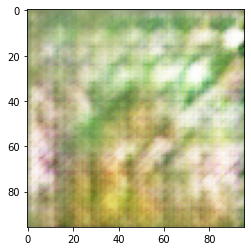

In [23]:
noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator(noise, training=False)
generated_image = 0.5 * generated_image + 0.5
plt.imshow(generated_image[0, :, :, :])

In [27]:
import numpy as np


In [28]:
x=500 # no of samples to be generated
for i in range(x):
  if not os.path.exists('/content/drive/My Drive/minor/cropped castor semilooper_out/result'):
      os.makedirs('/content/drive/My Drive/minor/cropped castor semilooper_out/result')
  noise = tf.random.normal([1, SEED_SIZE])
  generated_image = generator(noise, training=False)
  generated_image = 0.5 * generated_image + 0.5
  generated_image=generated_image[0, :, :, :]
  filename = os.path.join('/content/drive/My Drive/minor/cropped castor semilooper_out/result',f"castor_semilooper_generated-{i}.png")
  generated_image=np.asarray(generated_image)
  im = Image.fromarray((generated_image * 255).astype(np.uint8))
  im.save(filename)
